<a href="https://colab.research.google.com/github/dafnep4/Dafne-Petrelli-s-coding/blob/main/Work_sheet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# defining the libraries

import random
import struct
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

In [ ]:
# Julia and Julia dependencies are installed at first import
!pip install -U pysr
import pysr
from pysr import PySRRegressor


phi = sp.Symbol("phi")
c0 = 1e-5 # needs to be a fixed constant as long that V vanishes at a minimum.
c1 = random.uniform(-1e-6, 1e-6)
c2 = random.uniform(-1e-7, 1e-7)
c3 = random.uniform(-1e-8, 1e-8)

# building the skeleton of the potential as a polynomial.
def skeleton(parameters):
  c0, c1, c2, c3 = parameters
  V = c0 + c1*phi + c2*(phi**2) + c3*(phi**3)
  return V

parameters = [c0, c1, c2, c3]
c = skeleton(parameters)

phi_values = np.linspace(-5, 5, 100)

inflationary_potentials = []
for i in phi_values:
  inflationary_potentials.append(float(c.subs(phi, i)))
inflationary_potentials = np.array(inflationary_potentials)

coeffs = np.polyfit(phi_values, inflationary_potentials, 3)
V_fit = np.poly1d(coeffs)


X = phi_values.reshape(-1, 1)
y = inflationary_potentials


model = PySRRegressor(
    niterations=10,
    binary_operators=["+", "*"],
    unary_operators=[],  # No sin, log, etc.
    maxsize=10,
    model_selection="best"
)

# Run symbolic regression
model.fit(X, y)

# Get best expression (already a string)
best_expr_str = model.get_best()

# Convert to SymPy expression
best_expr_sympy = sp.sympify(best_expr_str)

# Substitute x0 with φ
phi_expr = best_expr_sympy.subs(sp.Symbol("x0"), phi)

# Show result
print("\nBest symbolic formula found by PySR:")
sp.pprint(phi_expr)


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           5.224e-12  0.000e+00  y = 1.0098e-05
5           3.493e-14  1.252e+00  y = (x₀ * -7.8126e-07) + 1.0098e-05
7           3.493e-14  2.086e-07  y = ((x₀ + x₀) * -3.9063e-07) + 1.0098e-05
9           2.721e-14  1.249e-01  y = (x₀ * ((x₀ * 1.1433e-08) + -7.8113e-07)) + 1.0001e-05
───────────────────────────────────────────────────────────────────────────────────────────────────


[ Info: Final population:
[ Info: Results saved to:


TypeError: cannot convert the series to <class 'float'>

  - outputs/20250630_143215_fVPO6o/hall_of_fame.csv


In [ ]:
# step 1 : converting the floats into binary strings (to allow crossover to be performed).
def float_to_binary(b):
    x = struct.unpack("!Q", struct.pack("!d", b))[0]
    binary_string = format(x, "064b")
    return binary_string

# the number of partitions is equal to the number of bits.
# so this code converts the floats into an 8 byte binary format.
# I used the same number of partitions as in the paper on cosmic inflation.

In [ ]:
# step 2 : computing a random population.
def geno_random():
  float_random = random.uniform(0.1,100)
  return float_to_binary(float_random)

N = 100 # population size.
population=[]

for i in range(N):
  geno = geno_random() # genotypes are formed to then be passed on to the population.
  population.append(geno)

population

['0100000001000100100011011110011101101000110011011101011001010010',
 '0100000001010000001110001001100111000111000111101001101100101000',
 '0100000001000100100101011001010000011010010010010000111100010100',
 '0100000001001010101111010101011111000110100010111011100111101100',
 '0100000000011111111000000001010110010101110010011011101000101110',
 '0100000001010100010110101011110100101001111000110010101100100010',
 '0100000001010000000100010110001110111000100000110100010111000101',
 '0100000001010101110000000100001000110011111101010001101110010001',
 '0100000001010001011101011110100000000010111001000011111000100111',
 '0100000000100111100011001110000110111011100001100101111001001010',
 '0100000001001000100110111010000111111010101101010010010100110011',
 '0100000001010011000100100010100100011001101100011010001010001000',
 '0100000001010100110110110101100110000100010100011110101010011101',
 '0100000001010010110011101001100001101101001100000110100111001000',
 '01000000010000001001100110101010

In [ ]:
# step 3 : M point function, to perform a random crossover.
# implemented a M-point cross-over by which two binary sequences (the two parents) are cut at the same M random points.
def M_point(geno1, geno2, M=2, iterations = 100):
  assert len(geno1) == len(geno2) # imposing that parent 1 and parent 2 will have the same length (even though they arleady should have).
  for _ in range(iterations):
    crossover = sorted(random.sample(range(1,len(geno1)),M)) # point at which crossover will perform.
    geno3 = ""
    toggle = False
    last = 0
    for i in crossover + [len(geno1)]:
      if toggle: # the toggle function controls which parent to take from each crossover segment ---> starts with parent 1 then goes to parent 2 and flips back.
        geno3 += geno2[last:i]
      else:
        geno3 += geno1[last:i]
      toggle = not toggle
      last = i
    if geno3 != geno1 and geno3 != geno2:
      return geno3


# this function above aims to crossover two distinct binary strings, to create a "child" which fills the purpose of the crossover.
# now Idk if that's if it works in the long term, but hopefully it does otherwise I will crash out :)

def breeding(population, M=2): # this function instead focuses on the breeding across the whole population to generate a new population.
  random.shuffle(population)

  new_population = []

  for i in range(0, (len(population) - 1), 2):
    geno1 = population[i]
    geno2 = population[i + 1]
    geno3 = M_point(geno1, geno2, M)
    new_population.append(geno3) # appending the "children" which were generated to form the new population.
  if len(population) % 2 != 0:
    new_population.append(population[-1])

  return new_population

crossover = breeding(population, M=2)
crossover

['0100000001000111001001000011101000110001011011111011101001000110',
 '0100000001010111111110110101110010011100000101001000100011101000',
 '0100000000111101100000011111110001010111100110100100100001010111',
 '0100000001001010101111010101011111000110100010111011100111110000',
 '0100000001000111111111100000010010011110010101010010111010011100',
 '0100000001010011000100100010100100011001101100011010011010001100',
 '0100000001000100100101011001010000011010010010010000111010010100',
 '0100000001011010110000001111110000000100110101001000001000010100',
 '0100000001010110001010010110111101001001000010011001100111000001',
 '0100000001010101101111010110011110101110011001101111100011010001',
 '0100000001001101110110001101110000100110100011101011101111101101',
 '0100000001001000100110001101100110010101010100111011100010100110',
 '0100000001001000111100101110100000000011100111000110111010101001',
 '0011111111101101001011011010000010001011010100101110110010111100',
 '01000000010011001000111110000100

In [ ]:
# step 4 : mutation of the "child".
# this is performed to ensure that the population does not cease to exist.
def mutation(geno3, mutation_rate = 0.01): # tbh I just picked a random mutation rate.
  mutated_geno = ""
  for i in geno3:
    if random.random() < mutation_rate: # for each bit in the binary string in the "child" (geno3) there will be a probability (mutation_rate) that it will flip ---> mutating.
      if i == "1":
        mutated_geno += "0"
      else:
        mutated_geno += "1"
    else:
      mutated_geno += i
  return mutated_geno

def mutated_newpop(new_population, mutation_rate = 0.01): # performs the mutation on the whole new population which was generated above.
  spiderman = []
  for i in new_population:
    mutated_geno = mutation(i, mutation_rate)
    spiderman.append(mutated_geno)
  return spiderman

poppop = mutated_newpop(crossover, mutation_rate = 0.01)
poppop

['0100000001000111001001010011101000110001010011111011101001000110',
 '0100000001010111111110110101110010011100000101001000100011101000',
 '0100000000111001100000011111110001010111100110100100100001010111',
 '0100000001001010101111010101011111000110100010111011100111110000',
 '0100000001000111111111100000010010011110010101010010111010011100',
 '0110000001010011000100100010100100011001101100011010011110001100',
 '0100000001000100100101011001010000011010010010010000111010010100',
 '0100000001011010110000001111100001000100110101001000001000010100',
 '0100000001010110001010010110111101001001000010011001100111000001',
 '0100000001010101101111010110011110101110011001101111100011010001',
 '0100000001001101110110001101110000100010100011101010101111101101',
 '0100000001001010100110001101100110010101010100111011100000100110',
 '0100000001001000111100101110100001000011100111000110111010101001',
 '0011111111101101001011011010000010001011010100101110110010111100',
 '01000000010011001000111110000100

In [ ]:
# step 5 : converting the binary strings into floats.
def binary_to_float(binary_string):
    x = int(binary_string, 2)
    return struct.unpack("!d", struct.pack("!Q", x))[0]

float_population = []
for i in poppop:
  float_population.append(binary_to_float(i)) # converts the new population which was obtained though GA into floats again.

float_population


[46.29083839791251,
 95.92752744679785,
 25.507756686369557,
 53.47924119780134,
 47.98451594504624,
 1.022797983044798e+156,
 41.16858223502382,
 107.01515312912699,
 88.64741731584128,
 86.9594532018266,
 59.69421798673998,
 53.19414011562212,
 49.89771313799185,
 0.9118197175188452,
 57.12123033367453,
 3.069289035194525,
 nan,
 48.44219292635381,
 72.56674297318628,
 82.33902702745578,
 98.85009351536206,
 27.054375495739784,
 75.34662917294179,
 7.534887505998481,
 85.54898715324587,
 95.54389687348335,
 93.36686309097269,
 81.65888206818083,
 90.72376726161893,
 50.173575651830724,
 29.38658996874173,
 18.354588200286994,
 88.57647530878499,
 75.22802810409405,
 20.421448752180364,
 59.64094031100127,
 19.36936140329007,
 1.2498295565463283e+155,
 113.41780530048393,
 3.421929942824829e+20,
 66.19407201633106,
 2.8416844437103768,
 76.08251290484986,
 89.32974844675495,
 71.16843430994709,
 50.22784352593612,
 73.46156610211082,
 93.63318772478722,
 90.67925773323694,
 123.500464

In [ ]:
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split

!pip install -U pysr
import pysr
from pysr import PySRRegressor

# using Starobinsky inflation parameters and constraints.
# applying Hamilton - Jacobi formalism.

M_PI = 1.0
V_0 = 1.071e-10 * (M_PI)**4

# generating the data which will be based on known value of N (number of e-folds) and the Hubble parameters.
# this is because they are physical constraints which are already been formulated, from which I can reconstruct a potential and calculate its spectral index to check if it works.
# therefore I will try and work backwards.

N_values = np.linspace(50, 60, 1000)
H_0 = 1e-5
H_values = H_0 * (1 - (1/ 2 * N_values))

# reshaping to convert 1D array into a 2D vector
X = N_values.reshape(-1,1)
Y = H_values

# applying symbolic regression, which includes genetic algorthim

model = PySRRegressor(
    niterations=1000,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["exp", "log"],
    model_selection="best",
    maxsize=20,
    loss="loss(x, y) = (x - y)^2",
)

model.fit(X, Y)

# print generated potential

best_inflanatory_potential = model.get_best()["sympy_format"]
print(best_inflanatory_potential)

N = sp.Symbol("N")
phi = sp.Symbol("phi")

# computing the inverse of N(phi)
phi_N = sp.sqrt(3/2) * sp.log(4 * (N/3))

# to get H(phi), will subsitute N(phi) into the reconstructed H(N) which the model computed.
H_N = sp.sympify(best_inflanatory_potential)

H_phi = H_N.subs(N, 3/4 * sp.exp(sp.sqrt(2/3) * phi))

print("\nSymbolic reconstructed H(φ):")
sp.pprint(H_phi)

# now reconstructing potential in terms of phi, using Friedmann equation to satisfy the high-limit friction H^2 >> M^2
V_phi = 3 * (H_phi**2)
V_phi = sp.simplify(V_phi)

print("\nReconstructed potential V(φ):")
sp.pprint(V_phi)



/usr/local/lib/python3.11/dist-packages/pysr/sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 7.500e+04
Progress: 415 / 31000 total iterations (1.339%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.088e-10  0.000e+00  y = -0.000265
3           2.753e-13  3.316e+00  y = x₀ * -4.8187e-06
5           2.420e-20  8.124e+00  y = 1.0003e-05 - (x₀ * 5.0001e-06)
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 5.960e+04
Progress: 644 / 31000 total iterations (2.077%)
════════════════════════════════════════════════════════════════════════════════════════════════════
────────────────────────────────────────────

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.088e-10  0.000e+00  y = -0.000265
3           2.753e-13  3.316e+00  y = x₀ * -4.8187e-06
5           1.353e-22  1.072e+01  y = (x₀ - 2) * -5e-06
───────────────────────────────────────────────────────────────────────────────────────────────────
(x0 - 1*2.0000033)*(-5.0000003e-6)

Symbolic reconstructed H(φ):
(x₀ - 2.0000033)⋅-5.0000003e-6

Reconstructed potential V(φ):
                                               2
3.00001026000937e-10⋅(0.499999175001361⋅x₀ - 1) 
  - outputs/20250702_150832_JNlSNe/hall_of_fame.csv


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.570e+04
Progress: 244 / 3100 total iterations (7.871%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.853e-22  0.000e+00  y = 5.0743e-11
3           1.409e-23  2.010e+00  y = x₀ * 3.2763e-11
10          1.209e-24  3.507e-01  y = exp((x₀ ^ -0.81487) * (x₀ + -1.3342)) * 4.6744e-11
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.640e+04
Progress: 475 / 3100 total iterations (15.323%)
════════════════════════════════════════════════════════════════════════════════════════════════════
─────────────────────────

[ Info: Final population:
[ Info: Results saved to:
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2217: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.853e-22  0.000e+00  y = 5.0614e-11
3           1.408e-23  2.010e+00  y = x₀ * 3.2745e-11
7           6.554e-24  1.913e-01  y = (x₀ ^ (x₀ ^ -0.10404)) * 3.5134e-11
8           6.539e-24  2.200e-03  y = (x₀ - (exp(x₀) * 0.041131)) * 4.0396e-11
10          1.142e-24  8.724e-01  y = exp((x₀ + -1.3278) * (x₀ ^ -0.81624)) * 4.6744e-11
12          6.192e-25  3.062e-01  y = exp((1.6873 - (x₀ ^ -0.73816)) - (x₀ ^ -0.50859)) * 4....
                                      6744e-11
───────────────────────────────────────────────────────────────────────────────────────────────────
Best inflationary potential:
exp(-1/x0**0.7381624 - 1/x0**0.5085922 + 1.6873218)*4.6743533e-11
  - outputs/20250708_161812_YUNpZm/hall_of_fame.csv

Expressions evaluated per second: 4.010e+04
Progress: 255 / 3100 total iterations (8.226%)
══════════════════════════════

[ Info: Started!



Expressions evaluated per second: 3.600e+04
Progress: 927 / 3100 total iterations (29.903%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.262e-22  0.000e+00  y = 5.0869e-11
3           4.670e-23  1.437e+00  y = x₀ * 3.2916e-11
5           4.655e-23  1.588e-03  y = (x₀ + -0.023269) * 3.3296e-11
7           4.521e-23  1.468e-02  y = (x₀ ^ (x₀ ^ -0.014077)) * 3.3296e-11
8           4.321e-23  4.520e-02  y = (x₀ - (0.010773 * exp(x₀))) * 3.4639e-11
9           4.140e-23  4.285e-02  y = (x₀ - ((x₀ ^ x₀) * 0.010773)) * 3.4639e-11
11          4.041e-23  1.203e-02  y = (x₀ + ((-2.8363 - (x₀ ^ x₀)) * 0.010773)) * 3.4639e-11
13          4.014e-23  3.336e-03  y = (x₀ + (((x₀ * 1.9248) - (x₀ ^ x₀)) * 0.016545)) * 3.40...
                                      56e-11
15          3.939e-23  

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           8.262e-22  0.000e+00  y = 5.0869e-11
3           4.670e-23  1.437e+00  y = x₀ * 3.2916e-11
5           4.597e-23  7.920e-03  y = (x₀ ^ 0.96556) * 3.3752e-11
7           3.939e-23  7.718e-02  y = (x₀ ^ (x₀ ^ -0.1301)) * 3.5971e-11
9           3.934e-23  6.239e-04  y = ((x₀ ^ (x₀ ^ -0.1301)) * 3.5971e-11) * 0.9972
10          3.551e-23  1.025e-01  y = (x₀ * 4.2384e-11) - ((exp(x₀) + 2.7183) * 1.6048e-12)
12          3.536e-23  2.126e-03  y = (x₀ * 4.2384e-11) - (((exp(x₀) - x₀) + 3.2364) * 1.803...
                                      e-12)
14          3.522e-23  1.930e-03  y = (x₀ * 4.2384e-11) - ((exp(x₀) + ((x₀ * -0.74271) + 2.8...
                                      361)) * 1.803e-12)
───────────────────────────────────────────────────────────────────────────────────────────────────

Best fit on noisy data:
x0*3.2915785e-11


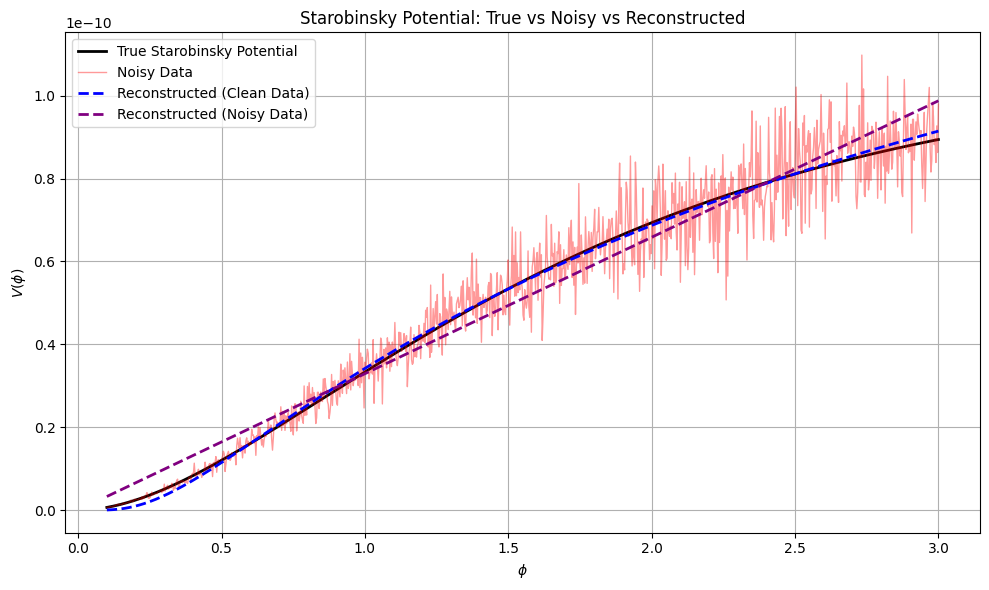

  - outputs/20250708_161952_gaou6J/hall_of_fame.csv


In [ ]:
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sympy.utilities.lambdify import lambdify


!pip install -U pysr
from pysr import PySRRegressor


# using Starobinsky inflation parameters and constraints.
M_PI = 1.0
V_0 = 1.071e-10 * (M_PI)**4

# generating the data which will be based on known value of N (number of e-folds) and the Hubble parameters.
# this is because they are physical constraints which are already been formulated, from which I can reconstruct a potential and calculate its spectral index to check if it works.
# therefore I will try and work backwards.

phi = sp.Symbol("x0")

phi_values = np.linspace(0.1, 3, 1000)

def V_starobinsky(phi):
  return V_0 * (1 - np.exp(-np.sqrt(2/3) * phi))**2

V_values = V_starobinsky(phi_values)

# reshaping to convert 1D array into a 2D vector.
X = phi_values.reshape(-1,1)
Y = V_values

# applying symbolic regression, which includes genetic algorthim.
model = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "^"],
    unary_operators=["exp"],
    model_selection="best",
    maxsize=15,
    constraints={"^": (1, 3)},
    random_state=0,
    parallelism="serial",
    deterministic=True,
    verbosity=1,
)


model.fit(X, Y)

# print generated potential.
best_inflationary_potential = model.get_best()["sympy_format"]
print("Best inflationary potential:")
print(best_inflationary_potential)

V_phi_func = sp.lambdify(phi, best_inflationary_potential, "numpy")



# adding noise to the data , 10% relative to the data.
noise_percentage = 0.10
noise = noise_percentage * V_values * np.random.randn(len(V_values))
V_noisy = V_values + noise

model.fit(X, V_noisy)

# print generated noisy potential.
best_noisy_expr = model.get_best()["sympy_format"]
print("\nBest fit on noisy data:")
print(best_noisy_expr)

V_noisy_func = sp.lambdify(phi, best_noisy_expr, "numpy")

# calculating the error between the clean and noisy data.
mae = mean_absolute_error(V_values, V_noisy)
mse = mean_squared_error(V_values, V_noisy)
rmse = np.sqrt(mse)
relative_error = np.mean(np.abs((V_noisy - V_values) / V_values))

print(f"Mean Absolute Error (MAE): {mae:.3e}")
print(f"Mean Squared Error (MSE): {mse:.3e}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3e}")
print(f"Mean Relative Error: {relative_error:.3%}")

# plotting
plt.figure(figsize=(10, 6))
plt.plot(phi_values, V_values, label="True Starobinsky Potential", linewidth=2, color="black")
plt.plot(phi_values, V_noisy, label="Noisy Data", linewidth=1, color="red", alpha=0.4)
plt.plot(phi_values, V_phi_func(phi_values), "--", label="Reconstructed (Clean Data)", linewidth=2, color="blue")
plt.plot(phi_values, V_noisy_func(phi_values), "--", label="Reconstructed (Noisy Data)", linewidth=2, color="purple")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$V(\phi)$")
plt.title("Starobinsky Potential: True vs Noisy vs Reconstructed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



In [ ]:
# this code will focus on calculating parameters from the previous potential generated.
# focus will be r, N and n_s

from scipy.optimize import root_scalar
from scipy.integrate import quad

# first I compute the derivatives of the inflanatory potetential that I obtained.
V_phi_expr = sp.sympify(best_inflanatory_potential)
V_first = sp.diff(V_phi_expr, phi)
V_second = sp.diff(V_first, phi)

V = sp.lambdify(phi, V_phi_expr, "numpy")
V_1 = sp.lambdify(phi, V_first, "numpy")
V_2 = sp.lambdify(phi, V_second, "numpy")


# here I am computing the values for the slow-roll parameters which are based on the derivatives computed above.
# these will be used to obtain the different parameters to study the accuracy of the potential reconstructed.
def epsilon(phi_val):
  return 1/2 * ((V_1(phi_val)) / (V(phi_val)))**2

def eta(phi_val):
  return (V_2(phi_val)) / (V(phi_val))

# finding limit : phi_end.
# value needs to be approximately close to 1.
phi_end = root_scalar(lambda phi: epsilon(phi) - 1, bracket=[0.01, 3])
phi_end = phi_end.root
print("Phi_end:", phi_end)

# finding the value of N e-folds, which measure the expansion rate of the universe during inflation.
def integral(phi_val):
  return (V(phi_val)) / (V_1(phi_val))

def N(phi_start):
  return quad(integral, phi_end, phi_start)[0]

print("N(phi=3):", N(3))

# finding the value for n_s, which corresponds to the spectral index.
# and finding the value for r, which corresponds to the tensor-to-scalar ratio.
def n_s(phi_value):
  return 1 - (6 * (epsilon(phi_value))) + (2 * (eta(phi_value)))

def r(phi_value):
  return 16 * epsilon(phi_value)

print("n_s(phi=3):", n_s(3))
print("r(phi=3):", r(3))

Phi_end: 0.9440268333899021
N(phi=3): 5.807143585861989
n_s(phi=3): 0.5348412820267328
r(phi=3): 0.16061168370560036


In [ ]:
# code to calculate A and ns from the primordial power spectrums at two different scales.

import numpy as np

# defining the value for k_s0 as 0.05 Mpc^-1 (taken from paper "Reconstructing the primordial power spectrum 2018").
k_s0 = 0.05

# defining values of the 2 primordial power spectrums P(k1) and P(k2).
p1 = 2.1e-9
p2 = 2.05e-9

# defining values of the two different k's.
k_1 = 0.055
k_2 = 0.09

# computing the ns value, which was proven mathematically.
n_s = 1 + (np.log(p2 / p1)) / (np.log(k_2 / k_1))

# computing As using for both k's to check if it is the same.
A_s1 = p1 / ((k_1 / k_s0) ** (n_s - 1))
A_s2 = p2 / ((k_2 / k_s0) ** (n_s - 1))


print("ns:" , n_s)
print("As for k1:" , A_s1)
print("As for k2:" ,  A_s2)

# the range for the k's was chosen since it is withing the CMB range and they are not too close to each other.
# the values for both A's are almost identical and if the square root of 2.10e-09 is taken , the value of 4.58e-5 is obtained which is approximately what they got in the paper (5.0e-5)

ns: 0.9510686249836369
As for k1: 2.1098165548526197e-09
As for k2: 2.1098165548526193e-09


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 3.060e+04
Progress: 221 / 3100 total iterations (7.129%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.853e-22  0.000e+00  y = 5.0743e-11
3           1.409e-23  2.010e+00  y = x₀ * 3.2763e-11
10          1.209e-24  3.507e-01  y = exp((x₀ ^ -0.81487) * (x₀ + -1.3342)) * 4.6744e-11
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.330e+04
Progress: 414 / 3100 total iterations (13.355%)
════════════════════════════════════════════════════════════════════════════════════════════════════
─────────────────────────

[ Info: Final population:
[ Info: Results saved to:
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2217: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.853e-22  0.000e+00  y = 5.0614e-11
3           1.408e-23  2.010e+00  y = x₀ * 3.2745e-11
7           6.554e-24  1.913e-01  y = (x₀ ^ (x₀ ^ -0.10404)) * 3.5134e-11
8           6.539e-24  2.200e-03  y = (x₀ - (exp(x₀) * 0.041131)) * 4.0396e-11
10          1.142e-24  8.724e-01  y = exp((x₀ + -1.3278) * (x₀ ^ -0.81624)) * 4.6744e-11
12          6.192e-25  3.062e-01  y = exp((1.6873 - (x₀ ^ -0.73816)) - (x₀ ^ -0.50859)) * 4....
                                      6744e-11
───────────────────────────────────────────────────────────────────────────────────────────────────
Best inflationary potential:
exp(-1/x0**0.7381624 - 1/x0**0.5085922 + 1.6873218)*4.6743533e-11
  - outputs/20250709_101830_M2RKaa/hall_of_fame.csv

Expressions evaluated per second: 5.760e+04
Progress: 356 / 3100 total iterations (11.484%)
═════════════════════════════

[ Info: Started!



Expressions evaluated per second: 3.150e+04
Progress: 1145 / 3100 total iterations (36.935%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.899e-22  0.000e+00  y = 5.051e-11
3           1.821e-23  1.885e+00  y = x₀ * 3.2767e-11
5           1.793e-23  7.683e-03  y = (x₀ ^ 0.98976) * 3.3153e-11
7           1.521e-23  8.246e-02  y = (x₀ ^ (0.94121 ^ x₀)) * 3.6411e-11
9           1.381e-23  4.820e-02  y = (x₀ * 3.3426e-11) - ((x₀ ^ x₀) * 2.5643e-13)
10          7.186e-24  6.533e-01  y = exp(x₀ * -0.13521) * ((x₀ + -0.20396) * 4.9449e-11)
12          7.182e-24  2.805e-04  y = (4.9449e-11 * (-0.20396 + x₀)) * exp((x₀ - 0.015209) *...
                                       -0.13521)
14          4.935e-24  1.876e-01  y = (x₀ * (x₀ + 0.16329)) * (exp((x₀ * 0.44233) - x₀) * 4....
       

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.899e-22  0.000e+00  y = 5.07e-11
3           1.821e-23  1.885e+00  y = x₀ * 3.2767e-11
5           1.761e-23  1.692e-02  y = (x₀ ^ 0.97614) * 3.3288e-11
7           1.084e-23  2.427e-01  y = (x₀ ^ (x₀ ^ -0.13941)) * 3.6194e-11
9           1.036e-23  2.254e-02  y = ((x₀ ^ (x₀ ^ -0.13941)) + -0.0056166) * 3.6194e-11
10          7.172e-24  3.676e-01  y = (4.9449e-11 * exp(x₀ * -0.13521)) * (x₀ + -0.20069)
11          5.328e-24  2.972e-01  y = ((x₀ ^ 0.23841) * (x₀ ^ (x₀ ^ -0.37652))) * 3.4025e-11
14          4.910e-24  2.723e-02  y = (exp((x₀ * 0.44287) - x₀) * ((x₀ + 0.15731) * x₀)) * 4...
                                      .9449e-11
───────────────────────────────────────────────────────────────────────────────────────────────────

Best fit on noisy data:
4.9448837e-11*(x0 - 0.20069367)*exp(x0*(-0.13520688))
Mean Absolute Error (

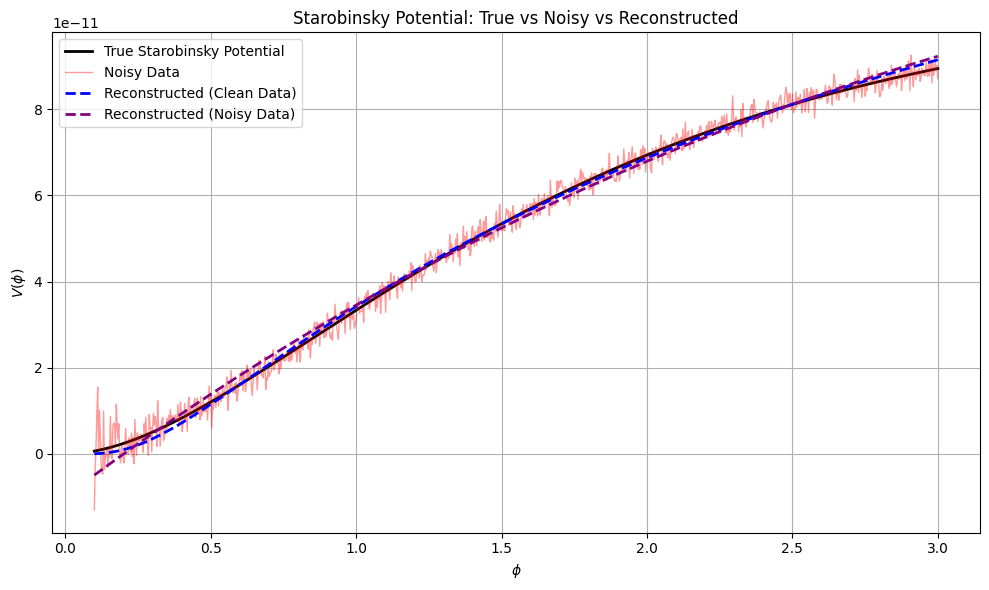

  - outputs/20250709_102014_gaou6J/hall_of_fame.csv


In [ ]:
###################################### CODE FOR NOISE ∝ 1 / σ^2 #####################################


from sklearn.metrics import mean_absolute_error, mean_squared_error
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sympy.utilities.lambdify import lambdify


!pip install -U pysr
from pysr import PySRRegressor


# using Starobinsky inflation parameters and constraints.
M_PI = 1.0
V_0 = 1.071e-10 * (M_PI)**4

# generating the data which will be based on known value of N (number of e-folds) and the Hubble parameters.
# this is because they are physical constraints which are already been formulated, from which I can reconstruct a potential and calculate its spectral index to check if it works.
# therefore I will try and work backwards.

phi = sp.Symbol("x0")

phi_values = np.linspace(0.1, 3, 1000)

def V_starobinsky(phi):
  return V_0 * (1 - np.exp(-np.sqrt(2/3) * phi))**2

V_values = V_starobinsky(phi_values)

# reshaping to convert 1D array into a 2D vector.
X = phi_values.reshape(-1,1)
Y = V_values

# applying symbolic regression, which includes genetic algorthim.
model = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "^"],
    unary_operators=["exp"],
    model_selection="best",
    maxsize=15,
    constraints={"^": (1, 3)},
    random_state=0,
    parallelism="serial",
    deterministic=True,
    verbosity=1,
)


model.fit(X, Y)

# print generated potential.
best_inflationary_potential = model.get_best()["sympy_format"]
print("Best inflationary potential:")
print(best_inflationary_potential)

V_phi_func = sp.lambdify(phi, best_inflationary_potential, "numpy")



# adding noise ∝ 1 / σ^2.
epsilon = 1e-3
scaling = (1 / (np.maximum(phi_values, epsilon))**2)
max = np.max(scaling)
relative_scaling = scaling / max
relative_scaling = 0.2 + 0.8 * relative_scaling
noise = relative_scaling * (0.1 * np.max(V_values)) * np.random.randn(len(V_values))
V_noisy = V_values + noise

model.fit(X, V_noisy)

# print generated noisy potential.
best_noisy_expr = model.get_best()["sympy_format"]
print("\nBest fit on noisy data:")
print(best_noisy_expr)

V_noisy_func = sp.lambdify(phi, best_noisy_expr, "numpy")

# calculating error between clean and noisy data.
mae = mean_absolute_error(V_values, V_noisy)
mse = mean_squared_error(V_values, V_noisy)
rmse = np.sqrt(mse)
relative_error = np.mean(np.abs((V_noisy - V_values) / V_values))

print(f"Mean Absolute Error (MAE): {mae:.3e}")
print(f"Mean Squared Error (MSE): {mse:.3e}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3e}")
print(f"Mean Relative Error: {relative_error:.3%}")

# plotting
plt.figure(figsize=(10, 6))
plt.plot(phi_values, V_values, label="True Starobinsky Potential", linewidth=2, color="black")
plt.plot(phi_values, V_noisy, label="Noisy Data", linewidth=1, color="red", alpha=0.4)
plt.plot(phi_values, V_phi_func(phi_values), "--", label="Reconstructed (Clean Data)", linewidth=2, color="blue")
plt.plot(phi_values, V_noisy_func(phi_values), "--", label="Reconstructed (Noisy Data)", linewidth=2, color="purple")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$V(\phi)$")
plt.title("Starobinsky Potential: True vs Noisy vs Reconstructed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
INFO:pysr.sr:Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 3.520e+04
Progress: 222 / 3100 total iterations (7.161%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.853e-22  0.000e+00  y = 5.0743e-11
3           1.409e-23  2.010e+00  y = x₀ * 3.2763e-11
10          1.209e-24  3.507e-01  y = exp((x₀ ^ -0.81487) * (x₀ + -1.3342)) * 4.6744e-11
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 3.210e+04
Progress: 456 / 3100 total iterations (14.710%)
════════════════════════════════════════════════════════════════════════════════════════════════════
─────────────────────────

[ Info: Final population:
[ Info: Results saved to:


Best inflationary potential:
exp(-1/x0**0.7381624 - 1/x0**0.5085922 + 1.6873218)*4.6743533e-11


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2217: UserWarning: The discovered expressions are being reset. Please set `warm_start=True` if you wish to continue to start a search where you left off.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(


  - outputs/20250709_102813_MFmCFD/hall_of_fame.csv


[ Info: Started!



Expressions evaluated per second: 3.910e+04
Progress: 259 / 3100 total iterations (8.355%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.839e-22  0.000e+00  y = 5.0685e-11
3           1.725e-23  1.908e+00  y = x₀ * 3.2709e-11
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 4.000e+04
Progress: 480 / 3100 total iterations (15.484%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Lo

[ Info: Final population:
[ Info: Results saved to:


───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           7.839e-22  0.000e+00  y = 5.0564e-11
3           1.725e-23  1.908e+00  y = x₀ * 3.2712e-11
5           1.642e-23  2.464e-02  y = (x₀ ^ 0.96634) * 3.3562e-11
7           9.307e-24  2.839e-01  y = (x₀ ^ (x₀ ^ -0.13623)) * 3.573e-11
10          6.071e-24  1.424e-01  y = ((x₀ - 0.21377) * 5.1464e-11) * exp(x₀ * -0.15061)
12          6.068e-24  2.593e-04  y = exp((0.0068033 + x₀) * -0.15039) * (5.1464e-11 * (x₀ -...
                                       0.21377))
13          4.722e-24  2.509e-01  y = 4.3327e-11 * ((exp(exp(x₀ + -2.293) * -0.15039) * x₀) ...
                                      - 0.19219)
15          4.666e-24  5.930e-03  y = (((exp(exp(x₀ + -2.293) * -0.15039) * 0.84189) * x₀) -...
                                       0.15885) * 5.1464e-11
───────────────────────────────────────────────────────────────────────────────

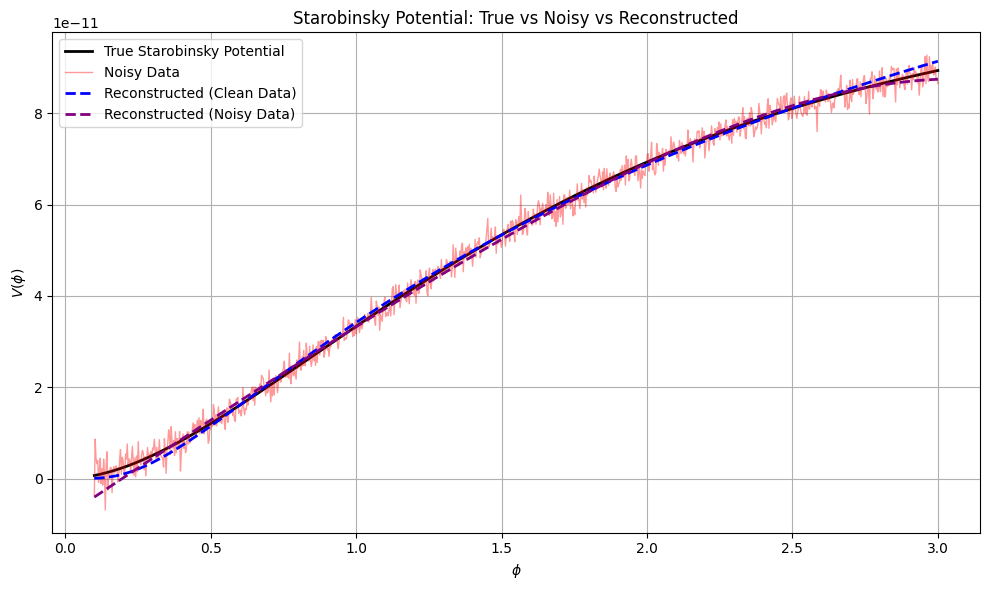

  - outputs/20250709_103010_gaou6J/hall_of_fame.csv


In [ ]:
###################################### CODE FOR NOISE ∝ 1 / σ^4 #####################################


from sklearn.metrics import mean_absolute_error, mean_squared_error
import sympy as sp
import numpy as np
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sympy.utilities.lambdify import lambdify


!pip install -U pysr
from pysr import PySRRegressor


# using Starobinsky inflation parameters and constraints.
M_PI = 1.0
V_0 = 1.071e-10 * (M_PI)**4

# generating the data which will be based on known value of N (number of e-folds) and the Hubble parameters.
# this is because they are physical constraints which are already been formulated, from which I can reconstruct a potential and calculate its spectral index to check if it works.
# therefore I will try and work backwards.

phi = sp.Symbol("x0")

phi_values = np.linspace(0.1, 3, 1000)

def V_starobinsky(phi):
  return V_0 * (1 - np.exp(-np.sqrt(2/3) * phi))**2

V_values = V_starobinsky(phi_values)

# reshaping to convert 1D array into a 2D vector.
X = phi_values.reshape(-1,1)
Y = V_values

# applying symbolic regression, which includes genetic algorthim.
model = PySRRegressor(
    niterations=100,
    binary_operators=["+", "-", "*", "^"],
    unary_operators=["exp"],
    model_selection="best",
    maxsize=15,
    constraints={"^": (1, 3)},
    random_state=0,
    parallelism="serial",
    deterministic=True,
    verbosity=1,
)


model.fit(X, Y)

# print generated potential.
best_inflationary_potential = model.get_best()["sympy_format"]
print("Best inflationary potential:")
print(best_inflationary_potential)

V_phi_func = sp.lambdify(phi, best_inflationary_potential, "numpy")



# adding noise ∝ 1 / σ^4.
epsilon = 1e-3 # acts as a lower bound for phi_values to prevent it ---> 0.
scaling = (1 / (np.maximum(phi_values, epsilon))**4) # for each element it is taking the max. value between the element and epsilon and then it is put to a power of n.
# inverse square law noise ∝ 1 / σ^n, states that there will be stronger noise at small σ and weaker noise when it is at larger σ.

max = np.max(scaling) # finding maximum value of the scaling.
relative_scaling = scaling / max # normalizing scaling.
relative_scaling = 0.2 + 0.8 * relative_scaling # rescales the scaling to ensure that noise amplitude will be at least always of the maximum 20% noise level.
noise = relative_scaling * (0.1 * np.max(V_values)) * np.random.randn(len(V_values)) # genrating Guassian noise, in which the magnitude of the noise follows the current distribuition.
V_noisy = V_values + noise

model.fit(X, V_noisy)

# print generated noisy potential.
best_noisy_expr = model.get_best()["sympy_format"]
print("\nBest fit on noisy data:")
print(best_noisy_expr)

V_noisy_func = sp.lambdify(phi, best_noisy_expr, "numpy")

# calculating error between clean and noisy data.
mae = mean_absolute_error(V_values, V_noisy)
mse = mean_squared_error(V_values, V_noisy)
rmse = np.sqrt(mse)
relative_error = np.mean(np.abs((V_noisy - V_values) / V_values))

print(f"Mean Absolute Error (MAE): {mae:.3e}")
print(f"Mean Squared Error (MSE): {mse:.3e}")
print(f"Root Mean Squared Error (RMSE): {rmse:.3e}")
print(f"Mean Relative Error: {relative_error:.3%}")

# plotting
plt.figure(figsize=(10, 6))
plt.plot(phi_values, V_values, label="True Starobinsky Potential", linewidth=2, color="black")
plt.plot(phi_values, V_noisy, label="Noisy Data", linewidth=1, color="red", alpha=0.4)
plt.plot(phi_values, V_phi_func(phi_values), "--", label="Reconstructed (Clean Data)", linewidth=2, color="blue")
plt.plot(phi_values, V_noisy_func(phi_values), "--", label="Reconstructed (Noisy Data)", linewidth=2, color="purple")
plt.xlabel(r"$\phi$")
plt.ylabel(r"$V(\phi)$")
plt.title("Starobinsky Potential: True vs Noisy vs Reconstructed")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
################################### trying to reconstruct potentials from stratch with an initial parameter of 60 e-folds ###################################
!pip install -U pysr

import numpy as np
import sympy as sp
from pysr import PySRRegressor
from scipy.integrate import quad
from scipy.optimize import root_scalar
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

# 1. Symbolic variable
phi = sp.Symbol("x0")


X = np.linspace(0.1, 5.5, 1000).reshape(-1, 1)

# 👇 Dummy target, just to push variation
y = np.exp(-X).flatten()

model = PySRRegressor(
    niterations=500,
    population_size=1000,
    binary_operators=["+", "-", "*", "/"],
    unary_operators=["sin", "cos", "exp", "log", "sqrt"],
    loss="loss(x, y) = 0.0",  # Ignore fitting error
    parsimony=1e-5,           # Allow complex expressions
    maxsize=30,
    maxdepth=10,
    turbo=True,
    verbosity=1,
    model_selection="best",
)

model.fit(X, y)

model.fit(X, y)

# 4. Load equations
equations_df = model.equations_.copy()
if "equation" not in equations_df:
    print("No equations found.")
    exit()

print(f"\n🔍 Raw equations from PySR:\n{equations_df[['equation', 'complexity']].head(10)}")

# 5. Physics-based fitness function
def evaluate_potential(expr_str):
    try:
        expr = sp.sympify(expr_str)
        V = sp.lambdify(phi, expr, "numpy")
        V_1 = sp.lambdify(phi, sp.diff(expr, phi), "numpy")
        V_2 = sp.lambdify(phi, sp.diff(expr, phi, 2), "numpy")

        def epsilon(phi_val):
            return 0.5 * (V_1(phi_val)/V(phi_val))**2

        def eta(phi_val):
            return V_2(phi_val) / V(phi_val)

        # Try root-finding for phi_end
        try:
            result = root_scalar(lambda x: epsilon(x) - 1, bracket=[0.01, 6], method='brentq')
            phi_end = result.root
        except Exception:
            return 1e6  # fail

        # N_e folds
        try:
            integrand = lambda x: V(x) / V_1(x)
            N = quad(integrand, phi_end, 5.5)[0]
        except Exception:
            return 1e6

        if not (50 <= N <= 70):
            return 1e6

        e_val = epsilon(5.5)
        eta_val = eta(5.5)
        ns = 1 - 6*e_val + 2*eta_val
        r = 16 * e_val

        # squared distance from desired
        return (ns - 0.965)**2 + (r - 0.06)**2

    except Exception:
        return 1e6

# 6. Apply filtering
print("\n⏳ Evaluating equations by physics fitness...")
equations_df["physics_fitness"] = equations_df["equation"].apply(evaluate_potential)
filtered = equations_df[equations_df["physics_fitness"] < 1e5].sort_values("physics_fitness")

# 7. Show top candidates
print("\n✅ Top candidate potentials ranked by physics fitness:")
print(filtered[["equation", "complexity", "physics_fitness"]].head(10))


[ Info: Started!


Streaming output truncated to the last 5000 lines.

Expressions evaluated per second: 7.600e+04
Progress: 2111 / 15500 total iterations (13.619%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           0.000e+00  0.000e+00  y = 1.1128
───────────────────────────────────────────────────────────────────────────────────────────────────
════════════════════════════════════════════════════════════════════════════════════════════════════
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 7.540e+04
Progress: 2128 / 15500 total iterations (13.729%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss

In [ ]:
import sympy as sp
import numpy as np
import subprocess
#################################################################
from PyTransport.PyTransPy import PyTransSetup, PyTransScripts

PyTransSetup.pathSet()
#############################################################

def str_pot(V):
    # Function that writes the potential in a suitable string for the ModelSetup.py
    params = [arg for arg in sp.postorder_traversal(V) if (arg.is_number and np.abs(arg) != 1)]
    pvalues = []
    for p in params:
        if np.abs(p) not in pvalues:
            pvalues.append(p)
    print(f'Pvalues = {pvalues}')
    params = pvalues
    symbols = [arg for arg in sp.postorder_traversal(V) if arg.is_symbol]
    operations = [arg for arg in sp.postorder_traversal(V) if arg.is_Function]
    symbols = list(set(symbols))

    V_string = str(V)
    # Replace the functions
    for i in range(len(operations)):
        op = 'sym.'+str(operations[i])
        V_string = V_string.replace(str(operations[i]), op)

    # Replace the parameters
    for i in range(len(params)):
        try:
            formatted_number_str = f"{params[i]:g}"
        except TypeError:
            formatted_number_str = str(params[i])

        V_string = V_string.replace(formatted_number_str, f'p[{i}]')

        try:
            formatted_number_str = f"{float(params[i])}"
        except TypeError:
            formatted_number_str = str(params[i])

        V_string = V_string.replace(formatted_number_str, f'p[{i}]')

    # Replace symbols
    for i in range(len(symbols)):
        symbol = str(symbols[i])
        V_string = V_string.replace(symbol, f'f[{i}]')

    nF = len(symbols)
    nP = len(params)

    return V_string, nF, nP

def write_setup(name, V_string, nF, nP, G_string=None):
    # Function that writes the ModelSetup.py
    read_file = open('setup_template.py')
    lines = read_file.readlines()

    with open(name+'setup.py', 'w') as write_file:
        for line in lines:
            if line.endswith('#nF\n'):
                write_file.write(f'nF={nF}\n')
            elif line.endswith('#nP\n'):
                write_file.write(f'nP={nP}\n')
            elif line.endswith('#potential\n'):
                write_file.write(f'V = {V_string}\n')
            elif line.endswith('#metric\n') and G_string != None:
                write_file.write(f'G = {G_string}\n')
            elif line.endswith('#metric\n') and G_string == None:
                print('no metric')
            elif line.endswith('#setup\n') and G_string == None:
                write_file.write('PyTransSetup.potential(V,nF,nP,True)\n')
            elif line.endswith('#setup\n') and G_string != None:
                write_file.write('PyTransSetup.potential(V,nF,nP,False,G)\n')
            elif line.endswith('#compile'):
                write_file.write(f'PyTransSetup.compileName("{name}") ')
            else:
                write_file.write(line)

def computations(PyT, V, initial, sr=True):
    # Function to compute the background evolution of the model and n_s
    import PyTransScripts as PyS
    ############################################## Set initial values ##################################################################
    # Check the number of parameters and the number of fields
    print(f'V = {V}')
    params = [arg for arg in sp.postorder_traversal(V) if (arg.is_number and np.abs(arg) != 1.)]
    pvalues = []
    for p in params:
        if np.abs(p) not in pvalues:
            print(f'Type = {type(p)}, Native p = {p}, np p = {np.float32(p)}, python p = {float(p)}')
            pvalues.append(np.float64(p))
    params = pvalues
    symbols = list(set([arg for arg in sp.postorder_traversal(V) if arg.is_symbol]))
    nF = PyT.nF()
    if len(symbols) != nF:
        print('Error with number of Fields')
        return None
    nP = PyT.nP()
    if len(params) != nP:
        print('Error with number of parameters')
        return None

    # Set the parameters' and initial conditions' arrays
    params = np.array(params)
    # if sr = True, the velocity will be computed with Slow-roll conditions
    if sr:
        fields = initial[:nF]
        v = PyT.V(fields, params)
        dv = PyT.dV(fields, params)
        initial = np.concatenate([fields, -dv/np.sqrt(3.*v)])
    else:
        initial = initial


    ############################################## Background run ##################################################################
    Nstart = 0.
    Nend = 600.
    t = np.linspace(Nstart, Nend, 1000)
    tols = np.array([10**-10,10**-10])
    back = PyT.backEvolve(t, initial, params, tols, True)

    # Make sure the inflation last at least 60 efolds
    print(f'Inflation ends at N = {back[-1, 0]}')
    if back[-1,0] < 60:
        print('Inflation too short')
        return 0

    ############################################## Set 2pt and and compute n_s ##################################################################
    tols = np.array([10**-10,10**-10])
    NB = 6.0
    Nexit = back[-1, 0] - 50.0
    k = PyS.kexitN(Nexit, back, params, PyT)


    Nstart, backExit = PyS.ICsBE(NB, k, back, params, PyT)
    tsig = np.linspace(Nstart, back[-1, 0], 1000)


    PyT_twoPt = PyT.sigEvolve(tsig, k, backExit, params, tols, True)
    pz1 = PyT_twoPt[-1,1]
    Nstart, backExit = PyS.ICsBE(NB, k*(1.001), back, params, PyT)
    tsig = np.linspace(Nstart, back[-1, 0], 1000)
    PyT_twoPt = PyT.sigEvolve(tsig, k*(1.001), backExit, params, tols, True)
    pz2 = PyT_twoPt[-1,1]
    n_s = (np.log(pz2)-np.log(pz1))/(np.log( k*(1.001))-np.log(k)) + 4.0
    return n_s

def main():
    phi = sp.Symbol('x0')
    #V_0 = 2.4078784e-11
    V_0 = 1.071e-10
    #V = V_0*(phi**0.94424653 - (sp.exp(phi*(0.48191538 - phi)) - 0.9756909))
    V = V_0 * (1 - sp.exp(-np.sqrt(2/3)*phi))**2
    # Get the string for the potential, the number of fields and number of parameters
    V_str, nF, nP = str_pot(V)
    # Write the ModelSetup.py
    write_setup('Dafne', V_str, nF, nP)
    # Install the Model
    subprocess.run(['python Dafnesetup.py'], shell=True)
    # Import model
    import PyTransDafne as PyT
    # Define initial conditions
    initial = np.array([6., 0.])
    # Compute n_s
    n_s = computations(PyT, V, initial)
    print(f'n_s = {n_s}')



if __name__ == '__main__':
    main()

ModuleNotFoundError: No module named 'PyTransport'

In [ ]:
############################## Set up file for the Axion Monodromy Quadratic ###########################
import sympy as sym
from gravipy import *

#################################################################
from PyTransport.PyTransPy import PyTransSetup, PyTransScripts

PyTransSetup.pathSet()
#############################################################
nF = 2 #nF
nP = 6 #nP
f = sym.symarray('f', nF)
p = sym.symarray('p', nP)

V = 0.5*p[1]*f[0]**2 + p[2]*sym.cos(f[0]/p[3]) + 0.5*p[4]*(f[1] - p[5])**2  #potential
G = sym.Matrix( [ [sym.exp(f[1]/p[0]), 0], [0, 1] ] )                       #metric
#############################################################
PyTransSetup.potential(V,nF,nP,False,G)                                     #setup
PyTransSetup.compileName("AMQ")                                       #compile

In [ ]:
!pip install pygad

import pygad
import numpy

function_inputs = [1e-11, 1e-10, 1e-9, 1e-8]
desired_output = 1.1e-8

def fitness_func(ga_instance, solution, solution_idx):
    output = numpy.sum(solution*function_inputs)
    fitness = 1.0 / numpy.abs(output - desired_output)
    return fitness

fitness_function = fitness_func

num_generations = 50
num_parents_mating = 4

sol_per_pop = 8
num_genes = len(function_inputs)

init_range_low = -1e-11
init_range_high = 1e-11

parent_selection_type = "sss"
keep_parents = 1

crossover_type = "single_point"

mutation_type = "random"
mutation_percent_genes = 10

ga_instance = pygad.GA(num_generations=num_generations,
                       num_parents_mating=num_parents_mating,
                       fitness_func=fitness_function,
                       sol_per_pop=sol_per_pop,
                       num_genes=num_genes,
                       init_range_low=init_range_low,
                       init_range_high=init_range_high,
                       parent_selection_type=parent_selection_type,
                       keep_parents=keep_parents,
                       crossover_type=crossover_type,
                       mutation_type=mutation_type,
                       mutation_percent_genes=mutation_percent_genes)

ga_instance.run()

solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

prediction = numpy.sum(numpy.array(function_inputs)*solution)
print("Predicted output based on the best solution : {prediction}".format(prediction=prediction))

Parameters of the best solution : [-2.70303699  1.15864641  1.41020906  0.95009497]
Fitness value of the best solution = 143464867374302.47
Predicted output based on the best solution : 1.0999993029652357e-08


[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[SKIP] epsilon doesn't cross 1: eps(0.5)=100.0, eps(3)=1000000.0
[BAD] Evaluation failed: [ 3.25970074e-07 -3.86232069e-07 -4.47919046e-07  2.84303488e-07
 -6.63190312e-07]
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[SKIP] epsilon doesn't cross 1: eps(0.5)=1.4567870546466941, eps(3)=1000000.0
[BAD] Evaluation failed: [ 2.31200233e-07 -8.11026357e-08  5.19749441e-07  8.94959656e-07
 -9.45034355e-07]
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[eta ERROR] name 'V' is not defined
[REJECT] N out of range: 11.92
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[eta ERROR] name 'V' is not defined
[REJECT] N out of range: 14.80
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[SKIP] epsilon doesn't cross 1: eps(0.5)=1000000.0, eps(3)=1000000.0
[BAD] Evaluation failed: [ 3.75897691e-07 -9.45272881e-07 -5.38339498e-07 -2.23469920e-07
 -4.47991087e-07]
[epsilon] V(ϕ) ≤ 0 at ϕ=

/tmp/ipython-input-27-4178152519.py:103: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val = quad(integrand, phi_end, 3)[0]


[eta ERROR] name 'V' is not defined
[REJECT] N out of range: 14.22
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[SKIP] epsilon doesn't cross 1: eps(0.5)=1000000.0, eps(3)=1000000.0
[BAD] Evaluation failed: [-7.66359530e-07  7.00597829e-07  5.79108312e-07  5.33245529e-07
 -1.62526116e-01]
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[SKIP] epsilon doesn't cross 1: eps(0.5)=1000000.0, eps(3)=1000000.0
[BAD] Evaluation failed: [-3.43125157e-01  9.07196806e-07  8.02327075e-07  5.33245529e-07
  8.97188333e-07]
[eta ERROR] name 'V' is not defined
[REJECT] N out of range: 14.22
[eta ERROR] name 'V' is not defined
[REJECT] N out of range: 3.55
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[SKIP] epsilon doesn't cross 1: eps(0.5)=1000000.0, eps(3)=1000000.0
[BAD] Evaluation failed: [-9.07722683e-01 -8.11026357e-08  5.19749441e-07  8.94959656e-07
  8.97188333e-07]
[eta ERROR] name 'V' is not defined
[REJE

/tmp/ipython-input-27-4178152519.py:103: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val = quad(integrand, phi_end, 3)[0]


[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=3.0, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[eta ERROR] name 'V' is not defined
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[REJECT] N out of range: 16000000.00
[SKIP] Coefficients too large: [ 3.13340053e-01 -8.11026357e-08 -7.53760062e-01  1.52335319e+00
  6.94137290e-07]
[SKIP] Coefficients too large: [ 2.31200233e-07 -8.11026357e-08 -1.41711882e+00  5.33245529e-07
  6.94137290e-07]
[eta ERROR] name 'V' is not defined
[REJECT] N out of range: 7.50
[epsilon] V(ϕ) ≤ 0 at ϕ=0.5, skipping.
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[SKIP] epsilon doesn't cross 1: eps(0.5)=1000000.0, eps(3)=1000000.0
[BAD] Evaluation failed: [-1.02286337e-01 -8.11026357e-08 -2.44680939e-01 -7.98902198e-07
  4.16862384e-07]
[epsilon] V(ϕ) ≤ 0 at ϕ=3, skipping.
[SKIP] epsilon doesn't cross 1: eps(0.5)=8.95888779157667, eps(3)=1000000.0
[BAD] Evaluation failed: [ 3.13340053e-01 -8.11026357e-08 -3.07511468e-01 -7.98902198e-07
 -9.06951086e-01]
[epsilon]

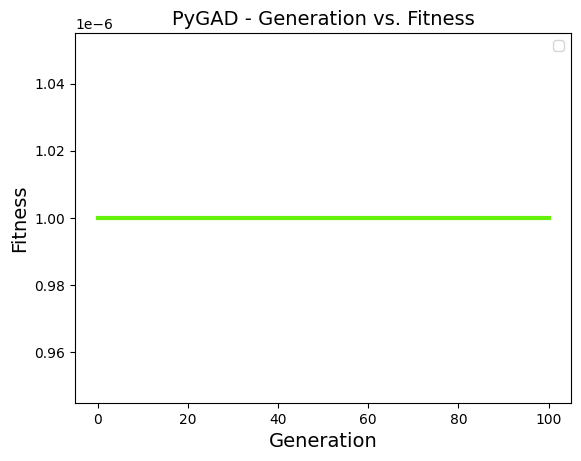

[SKIP] Coefficients too large: [ 2.297793    2.04877613  0.62939612  0.84836198 -3.28273027]
[SKIP] Coefficients too large: [ 2.297793    1.76748185  0.0764209  -0.28201444 -3.224499  ]
[SKIP] Coefficients too large: [ 2.297793    2.68732126  0.62939612  0.80526083 -3.77284391]
[SKIP] Coefficients too large: [ 2.297793    2.68732126  0.07041364  0.84836198 -3.28273027]
[SKIP] Coefficients too large: [ 2.297793    3.02438544  0.62939612 -0.28201444 -3.224499  ]
[SKIP] Coefficients too large: [ 2.297793    2.76611057  0.62939612  2.42659365 -3.46605378]
[SKIP] Coefficients too large: [ 2.297793    2.46488177  0.62939612  0.80526083 -3.97511039]
[SKIP] Coefficients too large: [ 2.297793    3.47387707  0.62939612  0.84836198 -3.28273027]
[SKIP] Coefficients too large: [ 2.76849906  2.68732126  0.0764209   0.84836198 -3.97511039]
[SKIP] Coefficients too large: [ 2.297793    2.34863713  0.0764209   2.1930906  -3.46605378]
[SKIP] Coefficients too large: [ 2.297793    2.68732126  0.62939612 -0

In [ ]:
!pip install pygad sympy scipy numpy

# importing libraries.
import numpy as np
import sympy as sp
from scipy.optimize import root_scalar
from scipy.integrate import quad
import pygad

phi = sp.Symbol('phi')

# choosing the costraints.
num_genes = 5
phi_sample = 3
target_ns = 0.965
target_r = 0.266
target_N = 60

def polynomial(coefficients): # fuction which aims at computing coefficients for the polynomial of the inflationary potential.
    c0, c1, c2, c3, c4 = coefficients


    V_phi_expr = c0 + (c1 * (phi)) + (c2 * (phi**2)) + (c3 * (phi**3)) + (c4 * (phi**4)) # inflationary potential expression.
    V_first = sp.diff(V_phi_expr, phi) # first derivative.
    V_second = sp.diff(V_first, phi) # second derivative.

    V = sp.lambdify(phi, V_phi_expr, 'numpy')
    V_1 = sp.lambdify(phi, V_first, 'numpy')
    V_2 = sp.lambdify(phi, V_second, 'numpy')

    # computing the slow-roll parameters to build the model.
    def epsilon(phi_val):
      try:
        v = V(phi_val)
        v1 = V_1(phi_val)

        # === Safety and sanity checks ===
        if v <= 0:
            print(f"[epsilon] V(ϕ) ≤ 0 at ϕ={phi_val}, skipping.")
            return 1e6
        if np.isnan(v) or np.isnan(v1):
            print(f"[epsilon] NaN encountered at ϕ={phi_val}, skipping.")
            return 1e6
        if np.abs(v) > 1e6:
            print(f"[epsilon] V(ϕ) too large at ϕ={phi_val}, skipping.")
            return 1e6
        if np.abs(v1) < 1e-10 or np.abs(v1) > 1e6:
            print(f"[epsilon] V'(ϕ) unstable at ϕ={phi_val}, skipping.")
            return 1e6

        eps = 0.5 * (v1 / v)**2
        return min(eps, 100.0)  # Clamp to avoid blowing up r
      except Exception as e:
        print(f"[epsilon ERROR] {e}")
        return 1e6

    def eta(phi_val):
      try:
        v = V(phi_val)
        v2 = V_2(phi_val)

        # === Safety and sanity checks ===
        if v == 0:
          print(f"[eta] V(ϕ) = 0 at ϕ={phi_val}, skipping.")
          return 1e6
        if np.isnan(v) or np.isnan(v2):
          print(f"[eta] NaN encountered at ϕ={phi_val}, skipping.")
          return 1e6
        if np.abs(v) > 1e6 or np.abs(v2) > 1e6:
          print(f"[eta] V(ϕ) or V''(ϕ) too large at ϕ={phi_val}, skipping.")
          return 1e6

        eta_val = v2 / v
        return max(min(eta_val, 100.0), -100.0)  # Clamp within [-100, 100]
      except Exception as e:
        print(f"[eta ERROR] {e}")
        return 1e6


    # --- Safe Root Finding ---
    try:
        eps_a = epsilon(0.5)
        eps_b = epsilon(3)
        if (eps_a - 1) * (eps_b - 1) > 0:
            print(f"[SKIP] epsilon doesn't cross 1: eps(0.5)={eps_a}, eps(3)={eps_b}")
            return None, None, None

        phi_end_result = root_scalar(lambda p: epsilon(p) - 1, bracket=[0.5, 3], method='brentq')
        phi_end = phi_end_result.root
    except Exception as e:
        print(f"[ERROR] Root finding failed: {e}")
        return None, None, None


    def integrand(p):
        return V(p) / V_1(p)

    try:
        N_val = quad(integrand, phi_end, 3)[0]
        ns = 1 - 6 * epsilon(3) + 2 * eta(3)
        r_val = 16 * epsilon(3)
    except Exception as e:
        print(f"[ERROR] Integral or slow-roll calc failed: {e}")
        return None, None, None

    return ns, r_val, N_val

def fitness_func(ga, solution, idx):
    # === 1. Hard bounds on coefficients ===
    if np.any(np.abs(solution) > 1):  # skip unstable models with huge coeffs
        print("[SKIP] Coefficients too large:", solution)
        return 1e-6

    # === 2. Evaluate observables ===
    ns, r_val, N_val = polynomial(solution)

    if None in (ns, r_val, N_val):
        print("[BAD] Evaluation failed:", solution)
        return 1e-6

    # === 3. Reject unphysical observables ===
    if not (50 <= N_val <= 70):
        print(f"[REJECT] N out of range: {N_val:.2f}")
        return 1e-6
    if not (0.9 <= ns <= 1.05):
        print(f"[REJECT] n_s out of range: {ns:.3f}")
        return 1e-6
    if r_val > 0.3:
        print(f"[REJECT] r too large: {r_val:.3f}")
        return 1e-6

    # === 4. Regularization penalty (L2 norm) ===
    reg = np.sum(np.square(solution))  # penalize large coeffs

    # === 5. Loss function ===
    loss = (
        abs(ns - target_ns) +
        abs(r_val - target_r) +
        abs(N_val - target_N) / 100.0 +
        1e6 * reg  # strong regularization
    )

    return 1.0 / (loss + 1e-6)



ga = pygad.GA(
    num_generations=100,
    sol_per_pop=20,
    num_parents_mating=5,
    num_genes=num_genes,
    fitness_func=fitness_func,
    init_range_low=-0.1,
    init_range_high=0.1,
    mutation_percent_genes=20,
    crossover_type="single_point",
    mutation_type="random",
    parent_selection_type="rank",
    keep_parents=1
)

ga.run() # running the genetic algorithm model.
ga.plot_fitness()

solution, fitness, idx = ga.best_solution()
print("\nBest Coefficients:", solution)
print("Fitness Score:", fitness)

N_best, ns_best, r_best = polynomial(solution)
print(f"n_s: {ns_best}, r: {r_best}, N: {N_best}")


/usr/local/lib/python3.11/dist-packages/pygad/pygad.py:1149: UserWarning: Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.
  warnings.warn("Use the 'save_best_solutions' parameter with caution as it may cause memory overflow when either the number of generations or number of genes is large.")


Promising solution: ns=0.943, r=0.303, N=52.8, fitness=1.05
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.27
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.13


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.296, N=53.8, fitness=1.22
Promising solution: ns=0.948, r=0.274, N=55.4, fitness=2.08
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.291, N=54.2, fitness=1.37
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.27
Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.19
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.32
Promising solution: ns=0.951, r=0.257, N=57.4, fitness=2.81
Promising solution: ns=0.945, r=0.291, N=54.4, fitness=1.38
Promising solution: ns=0.943, r=0.304, N=52.6, fitness=1.03
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.291, N=54.2, fitness=1.37
Promising solution: ns=0.943, r=0.301, N=52.3, fitness=1.05
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.08


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.952, r=0.254, N=57.9, fitness=2.79
Promising solution: ns=0.945, r=0.290, N=53.4, fitness=1.30
Promising solution: ns=0.945, r=0.293, N=52.9, fitness=1.21
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.02
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.2, fitness=1.07
Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.18
Promising solution: ns=0.944, r=0.296, N=53.6, fitness=1.21


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.952, r=0.250, N=57.7, fitness=2.47
Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.19
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.15


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.286, N=54.4, fitness=1.50
Promising solution: ns=0.945, r=0.295, N=53.4, fitness=1.22
Promising solution: ns=0.945, r=0.291, N=53.9, fitness=1.32
Promising solution: ns=0.949, r=0.267, N=56.2, fitness=2.83
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.946, r=0.290, N=54.8, fitness=1.44
Promising solution: ns=0.949, r=0.272, N=56.3, fitness=2.44
Promising solution: ns=0.944, r=0.298, N=52.5, fitness=1.10
Promising solution: ns=0.943, r=0.303, N=52.7, fitness=1.05
Promising solution: ns=0.948, r=0.276, N=54.6, fitness=1.86
Promising solution: ns=0.943, r=0.304, N=52.6, fitness=1.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.05
Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.20
Promising solution: ns=0.947, r=0.281, N=56.2, fitness=1.94


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.285, N=55.1, fitness=1.63
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.04
Promising solution: ns=0.945, r=0.296, N=53.9, fitness=1.24
Promising solution: ns=0.952, r=0.254, N=58.8, fitness=3.25
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.07
Promising solution: ns=0.946, r=0.289, N=53.5, fitness=1.34


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.285, N=54.3, fitness=1.50
Promising solution: ns=0.943, r=0.304, N=52.7, fitness=1.04
Promising solution: ns=0.948, r=0.277, N=55.9, fitness=2.05
Promising solution: ns=0.952, r=0.250, N=59.5, fitness=3.24
Promising solution: ns=0.943, r=0.302, N=51.8, fitness=1.02
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.32
Promising solution: ns=0.945, r=0.290, N=53.7, fitness=1.34
Promising solution: ns=0.944, r=0.300, N=52.4, fitness=1.07
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.943, r=0.303, N=52.8, fitness=1.05
Promising solution: ns=0.945, r=0.294, N=53.7, fitness=1.25
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.946, r=0.285, N=54.8, fitness=1.56
Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.947, r=0.282, N=55.3, fitness=1.72
Promising solution: ns=0.945, r=0.290, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.06
Promising solution: ns=0.945, r=0.291, N=53.0, fitness=1.25
Promising solution: ns=0.944, r=0.298, N=53.3, fitness=1.15


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.276, N=55.8, fitness=2.09
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.07


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.297, N=52.5, fitness=1.11
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.944, r=0.296, N=52.5, fitness=1.14
Promising solution: ns=0.945, r=0.291, N=53.6, fitness=1.30
Promising solution: ns=0.948, r=0.275, N=56.4, fitness=2.30
Promising solution: ns=0.944, r=0.300, N=53.3, fitness=1.12
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.04
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.03
Promising solution: ns=0.946, r=0.289, N=54.5, fitness=1.42


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.288, N=54.1, fitness=1.41
Promising solution: ns=0.945, r=0.293, N=54.0, fitness=1.30
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.947, r=0.282, N=54.7, fitness=1.64
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.290, N=53.4, fitness=1.31
Promising solution: ns=0.945, r=0.294, N=53.5, fitness=1.24
Promising solution: ns=0.943, r=0.304, N=52.9, fitness=1.05
Promising solution: ns=0.944, r=0.296, N=52.8, fitness=1.15
Promising solution: ns=0.951, r=0.258, N=57.9, fitness=3.14
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.05
Promising solution: ns=0.946, r=0.288, N=53.7, fitness=1.38


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.6, fitness=1.17
Promising solution: ns=0.944, r=0.297, N=52.9, fitness=1.15
Promising solution: ns=0.944, r=0.299, N=52.4, fitness=1.08
Promising solution: ns=0.944, r=0.297, N=52.5, fitness=1.12
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.948, r=0.277, N=55.9, fitness=2.06
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.16
Promising solution: ns=0.949, r=0.269, N=56.3, fitness=2.70
Promising solution: ns=0.946, r=0.288, N=53.9, fitness=1.40
Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.09
Promising solution: ns=0.943, r=0.301, N=51.8, fitness=1.02
Promising solution: ns=0.947, r=0.280, N=55.4, fitness=1.84
Promising solution: ns=0.943, r=0.302, N=51.9, fitness=1.02
Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.78
Promising solution: ns=0.944, r=0.296, N=53.6, fitness=1.21
Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.28
Promising solution: ns=0.945, r=0.293, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.291, N=54.5, fitness=1.39
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.01
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.76
Promising solution: ns=0.949, r=0.268, N=55.9, fitness=2.60
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.02
Promising solution: ns=0.943, r=0.303, N=52.9, fitness=1.06
Promising solution: ns=0.946, r=0.289, N=54.0, fitness=1.39
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03
Promising solution: ns=0.948, r=0.275, N=54.9, fitness=1.95
Promising solution: ns=0.946, r=0.289, N=54.5, fitness=1.43
Promising solution: ns=0.943, r=0.304, N=52.8, fitness=1.05
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.02
Promising solution: ns=0.944, r=0.296, N=53.1, fitness=1.17
Promising solution: ns=0.947, r=0.284, N=54.4, fitness=1.57
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.12
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.38
Promising solution: ns=0.943, r=0.304, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.10
Promising solution: ns=0.946, r=0.286, N=54.7, fitness=1.53
Promising solution: ns=0.949, r=0.272, N=56.2, fitness=2.41
Promising solution: ns=0.947, r=0.282, N=55.7, fitness=1.80


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.26
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.04
Promising solution: ns=0.951, r=0.258, N=58.8, fitness=3.55
Promising solution: ns=0.945, r=0.294, N=54.0, fitness=1.28
Promising solution: ns=0.945, r=0.291, N=54.1, fitness=1.34
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.943, r=0.304, N=52.7, fitness=1.04
Promising solution: ns=0.943, r=0.304, N=52.6, fitness=1.03
Promising solution: ns=0.945, r=0.291, N=53.0, fitness=1.25
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.04
Promising solution: ns=0.946, r=0.290, N=54.4, fitness=1.41
Promising solution: ns=0.949, r=0.271, N=56.1, fitness=2.48
Promising solution: ns=0.944, r=0.299, N=53.1, fitness=1.13
Promising solution: ns=0.947, r=0.283, N=55.1, fitness=1.67
Promising solution: ns=0.943, r=0.304, N=52.5, fitness=1.02
Promising solution: ns=0.945, r=0.294, N=53.5, fitness=1.24
Promising solution: ns=0.943, r=0.304, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.285, N=55.4, fitness=1.64
Promising solution: ns=0.944, r=0.300, N=53.0, fitness=1.11
Promising solution: ns=0.945, r=0.291, N=53.7, fitness=1.31
Promising solution: ns=0.945, r=0.290, N=53.5, fitness=1.31


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.953, r=0.246, N=58.6, fitness=2.55
Promising solution: ns=0.955, r=0.228, N=59.4, fitness=1.97
Promising solution: ns=0.949, r=0.269, N=57.6, fitness=3.23
Promising solution: ns=0.948, r=0.276, N=55.9, fitness=2.12
Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.19
Promising solution: ns=0.946, r=0.287, N=55.5, fitness=1.62
Promising solution: ns=0.945, r=0.291, N=53.6, fitness=1.29
Promising solution: ns=0.945, r=0.294, N=53.6, fitness=1.25
Promising solution: ns=0.944, r=0.297, N=51.1, fitness=1.04
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.5, fitness=1.18
Promising solution: ns=0.946, r=0.286, N=55.0, fitness=1.56
Promising solution: ns=0.947, r=0.283, N=54.3, fitness=1.57


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=53.8, fitness=1.42
Promising solution: ns=0.946, r=0.290, N=54.7, fitness=1.43
Promising solution: ns=0.954, r=0.243, N=59.0, fitness=2.51
Promising solution: ns=0.953, r=0.249, N=59.1, fitness=2.98
Promising solution: ns=0.946, r=0.284, N=54.3, fitness=1.53
Promising solution: ns=0.945, r=0.290, N=52.9, fitness=1.26
Promising solution: ns=0.943, r=0.307, N=53.3, fitness=1.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.283, N=54.2, fitness=1.55
Promising solution: ns=0.943, r=0.301, N=52.2, fitness=1.05
Promising solution: ns=0.953, r=0.246, N=59.0, fitness=2.67
Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.12
Promising solution: ns=0.945, r=0.295, N=52.9, fitness=1.17
Promising solution: ns=0.947, r=0.283, N=55.1, fitness=1.68
Promising solution: ns=0.944, r=0.299, N=53.4, fitness=1.15
Promising solution: ns=0.943, r=0.302, N=52.9, fitness=1.07
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.24
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.01


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.03
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.16
Promising solution: ns=0.946, r=0.289, N=54.5, fitness=1.45
Promising solution: ns=0.945, r=0.295, N=53.2, fitness=1.20
Promising solution: ns=0.946, r=0.284, N=53.9, fitness=1.50
Promising solution: ns=0.950, r=0.263, N=56.9, fitness=2.97
Promising solution: ns=0.945, r=0.294, N=54.2, fitness=1.30
Promising solution: ns=0.944, r=0.296, N=53.5, fitness=1.20
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.14
Promising solution: ns=0.953, r=0.248, N=58.6, fitness=2.65
Promising solution: ns=0.947, r=0.280, N=55.0, fitness=1.77


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.301, N=53.0, fitness=1.09
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.10
Promising solution: ns=0.951, r=0.258, N=58.3, fitness=3.30
Promising solution: ns=0.947, r=0.285, N=55.0, fitness=1.59
Promising solution: ns=0.943, r=0.304, N=52.5, fitness=1.03
Promising solution: ns=0.951, r=0.257, N=57.0, fitness=2.60
Promising solution: ns=0.944, r=0.297, N=54.3, fitness=1.26
Promising solution: ns=0.944, r=0.299, N=53.1, fitness=1.13
Promising solution: ns=0.948, r=0.277, N=56.7, fitness=2.24
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.946, r=0.286, N=55.2, fitness=1.59
Promising solution: ns=0.943, r=0.302, N=52.1, fitness=1.03
Promising solution: ns=0.946, r=0.286, N=54.3, fitness=1.49
Promising solution: ns=0.953, r=0.246, N=59.8, fitness=3.01
Promising solution: ns=0.943, r=0.303, N=53.2, fitness=1.08
Promising solution: ns=0.947, r=0.285, N=56.0, fitness=1.75
Promising solution: ns=0.944, r=0.298, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.953, r=0.245, N=59.3, fitness=2.74
Promising solution: ns=0.948, r=0.277, N=56.2, fitness=2.12
Promising solution: ns=0.946, r=0.285, N=53.8, fitness=1.45
Promising solution: ns=0.946, r=0.287, N=54.0, fitness=1.43
Promising solution: ns=0.943, r=0.302, N=51.9, fitness=1.02
Promising solution: ns=0.948, r=0.276, N=56.0, fitness=2.16


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.10
Promising solution: ns=0.943, r=0.303, N=53.4, fitness=1.09
Promising solution: ns=0.947, r=0.283, N=54.1, fitness=1.55
Promising solution: ns=0.944, r=0.301, N=51.9, fitness=1.03
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.08
Promising solution: ns=0.946, r=0.287, N=54.8, fitness=1.52
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.04
Promising solution: ns=0.943, r=0.306, N=52.5, fitness=1.00
Promising solution: ns=0.949, r=0.272, N=56.7, fitness=2.60
Promising solution: ns=0.945, r=0.291, N=53.1, fitness=1.26
Promising solution: ns=0.943, r=0.305, N=54.9, fitness=1.15
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.951, r=0.253, N=56.8, fitness=2.35
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.11
Promising solution: ns=0.944, r=0.299, N=53.8, fitness=1.18
Promising solution: ns=0.945, r=0.291, N=53.2, fitness=1.27
Promising solution: ns=0.944, r=0.299, N=53.1, fitness=1.14
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.74
Promising solution: ns=0.944, r=0.295, N=53.1, fitness=1.18
Promising solution: ns=0.945, r=0.296, N=53.6, fitness=1.22
Promising solution: ns=0.945, r=0.295, N=53.2, fitness=1.19
Promising solution: ns=0.947, r=0.284, N=54.9, fitness=1.61
Promising solution: ns=0.947, r=0.283, N=55.7, fitness=1.76
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.12
Promising solution: ns=0.948, r=0.275, N=56.4, fitness=2.27
Promising solution: ns=0.952, r=0.253, N=57.7, fitness=2.62


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.16
Promising solution: ns=0.947, r=0.282, N=54.9, fitness=1.68
Promising solution: ns=0.945, r=0.292, N=54.2, fitness=1.33
Promising solution: ns=0.950, r=0.262, N=57.2, fitness=3.06
Promising solution: ns=0.947, r=0.282, N=54.9, fitness=1.70
Promising solution: ns=0.954, r=0.242, N=59.4, fitness=2.65
Promising solution: ns=0.947, r=0.280, N=55.6, fitness=1.86


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.23
Promising solution: ns=0.946, r=0.290, N=54.4, fitness=1.40
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09
Promising solution: ns=0.946, r=0.286, N=53.7, fitness=1.41
Promising solution: ns=0.946, r=0.289, N=54.1, fitness=1.39
Promising solution: ns=0.947, r=0.282, N=55.4, fitness=1.77


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.281, N=55.5, fitness=1.80


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.294, N=53.2, fitness=1.21
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.25
Promising solution: ns=0.945, r=0.295, N=54.3, fitness=1.29
Promising solution: ns=0.943, r=0.303, N=52.7, fitness=1.05
Promising solution: ns=0.943, r=0.301, N=52.4, fitness=1.06
Promising solution: ns=0.945, r=0.291, N=53.6, fitness=1.30
Promising solution: ns=0.947, r=0.280, N=54.8, fitness=1.75
Promising solution: ns=0.948, r=0.275, N=56.6, fitness=2.35
Promising solution: ns=0.947, r=0.284, N=54.6, fitness=1.58
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.13
Promising solution: ns=0.946, r=0.287, N=54.1, fitness=1.44
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.04
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.17
Promising solution: ns=0.948, r=0.278, N=56.5, fitness=2.15
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.945, r=0.296, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.290, N=53.1, fitness=1.29
Promising solution: ns=0.945, r=0.293, N=53.9, fitness=1.30
Promising solution: ns=0.944, r=0.299, N=52.5, fitness=1.09
Promising solution: ns=0.944, r=0.300, N=52.3, fitness=1.06
Promising solution: ns=0.944, r=0.296, N=54.2, fitness=1.25


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.278, N=55.4, fitness=1.91
Promising solution: ns=0.943, r=0.301, N=52.5, fitness=1.06
Promising solution: ns=0.944, r=0.299, N=53.5, fitness=1.17
Promising solution: ns=0.948, r=0.279, N=55.9, fitness=1.96
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.05
Promising solution: ns=0.946, r=0.287, N=50.5, fitness=1.13


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.00
Promising solution: ns=0.943, r=0.303, N=52.7, fitness=1.06
Promising solution: ns=0.948, r=0.276, N=56.0, fitness=2.11
Promising solution: ns=0.945, r=0.291, N=54.3, fitness=1.37
Promising solution: ns=0.946, r=0.287, N=55.2, fitness=1.57
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.77
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.951, r=0.259, N=58.4, fitness=3.44
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.35
Promising solution: ns=0.943, r=0.306, N=52.4, fitness=1.00
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.03
Promising solution: ns=0.949, r=0.270, N=56.0, fitness=2.52
Promising solution: ns=0.944, r=0.299, N=55.8, fitness=1.33
Promising solution: ns=0.945, r=0.294, N=54.9, fitness=1.37
Promising solution: ns=0.947, r=0.282, N=55.0, fitness=1.69
Promising solution: ns=0.943, r=0.306, N=52.6, fitness=1.01
Promising solution: ns=0.943, r=0.302, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.272, N=56.2, fitness=2.45
Promising solution: ns=0.948, r=0.277, N=54.9, fitness=1.85
Promising solution: ns=0.944, r=0.301, N=52.9, fitness=1.09
Promising solution: ns=0.945, r=0.294, N=53.7, fitness=1.25
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.946, r=0.286, N=54.7, fitness=1.54
Promising solution: ns=0.947, r=0.278, N=54.8, fitness=1.79
Promising solution: ns=0.942, r=0.310, N=53.8, fitness=1.02
Promising solution: ns=0.944, r=0.298, N=52.9, fitness=1.13


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.07
Promising solution: ns=0.949, r=0.273, N=56.6, fitness=2.50
Promising solution: ns=0.948, r=0.278, N=56.4, fitness=2.12
Promising solution: ns=0.947, r=0.285, N=54.9, fitness=1.60
Promising solution: ns=0.945, r=0.293, N=52.7, fitness=1.20
Promising solution: ns=0.949, r=0.271, N=56.6, fitness=2.68
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.12
Promising solution: ns=0.944, r=0.297, N=52.5, fitness=1.12
Promising solution: ns=0.945, r=0.292, N=53.5, fitness=1.27
Promising solution: ns=0.947, r=0.282, N=55.0, fitness=1.69
Promising solution: ns=0.946, r=0.286, N=54.6, fitness=1.53
Promising solution: ns=0.944, r=0.295, N=52.8, fitness=1.17
Promising solution: ns=0.943, r=0.303, N=53.5, fitness=1.10
Promising solution: ns=0.947, r=0.283, N=55.1, fitness=1.67
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.946, r=0.286, N=54.3, fitness=1.48
Promising solution: ns=0.944, r=0.298, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.9, fitness=1.68
Promising solution: ns=0.943, r=0.302, N=53.3, fitness=1.10
Promising solution: ns=0.944, r=0.301, N=53.2, fitness=1.11
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.05
Promising solution: ns=0.946, r=0.286, N=54.4, fitness=1.49
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.10
Promising solution: ns=0.948, r=0.274, N=56.4, fitness=2.32
Promising solution: ns=0.945, r=0.294, N=54.2, fitness=1.30
Promising solution: ns=0.946, r=0.285, N=55.0, fitness=1.59
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.79
Promising solution: ns=0.947, r=0.283, N=54.1, fitness=1.56
Promising solution: ns=0.945, r=0.294, N=54.3, fitness=1.30
Promising solution: ns=0.948, r=0.277, N=55.6, fitness=2.01
Promising solution: ns=0.948, r=0.279, N=55.9, fitness=1.98
Promising solution: ns=0.946, r=0.286, N=55.0, fitness=1.56
Promising solution: ns=0.943, r=0.305, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.954, r=0.236, N=59.3, fitness=2.29
Promising solution: ns=0.953, r=0.247, N=59.0, fitness=2.79
Promising solution: ns=0.953, r=0.247, N=59.8, fitness=3.10
Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.23
Promising solution: ns=0.946, r=0.288, N=53.5, fitness=1.35
Promising solution: ns=0.947, r=0.285, N=55.4, fitness=1.66
Promising solution: ns=0.944, r=0.303, N=54.8, fitness=1.19
Promising solution: ns=0.947, r=0.281, N=54.8, fitness=1.71
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.12
Promising solution: ns=0.949, r=0.273, N=56.9, fitness=2.60
Promising solution: ns=0.943, r=0.304, N=53.1, fitness=1.05
Promising solution: ns=0.947, r=0.283, N=54.6, fitness=1.61
Promising solution: ns=0.947, r=0.281, N=55.0, fitness=1.75
Promising solution: ns=0.946, r=0.284, N=53.9, fitness=1.50
Promising solution: ns=0.944, r=0.302, N=54.1, fitness=1.15
Promising solution: ns=0.951, r=0.259, N=56.9, fitness=2.74
Promising solution: ns=0.944, r=0.300, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.283, N=55.3, fitness=1.70


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.301, N=53.2, fitness=1.11
Promising solution: ns=0.947, r=0.283, N=54.7, fitness=1.62
Promising solution: ns=0.944, r=0.301, N=54.2, fitness=1.17
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.16
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.23
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.02
Promising solution: ns=0.946, r=0.285, N=54.3, fitness=1.52
Promising solution: ns=0.945, r=0.295, N=53.5, fitness=1.23
Promising solution: ns=0.950, r=0.264, N=57.5, fitness=3.37
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.11
Promising solution: ns=0.950, r=0.262, N=57.2, fitness=3.09


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.04
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.04
Promising solution: ns=0.948, r=0.275, N=56.1, fitness=2.19
Promising solution: ns=0.948, r=0.279, N=56.3, fitness=2.02
Promising solution: ns=0.948, r=0.278, N=56.4, fitness=2.10
Promising solution: ns=0.948, r=0.277, N=55.2, fitness=1.90
Promising solution: ns=0.947, r=0.283, N=54.1, fitness=1.56
Promising solution: ns=0.947, r=0.283, N=54.8, fitness=1.62
Promising solution: ns=0.952, r=0.251, N=58.8, fitness=2.92
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.08
Promising solution: ns=0.945, r=0.295, N=53.6, fitness=1.22
Promising solution: ns=0.946, r=0.285, N=55.3, fitness=1.63


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.11
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.01
Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.08
Promising solution: ns=0.948, r=0.277, N=55.8, fitness=2.03
Promising solution: ns=0.948, r=0.275, N=56.0, fitness=2.16
Promising solution: ns=0.947, r=0.283, N=53.9, fitness=1.50
Promising solution: ns=0.947, r=0.282, N=54.2, fitness=1.59
Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.09
Promising solution: ns=0.947, r=0.284, N=54.8, fitness=1.62
Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.10
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.09
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.78
Promising solution: ns=0.948, r=0.279, N=56.3, fitness=2.03
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.02
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.16


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.279, N=55.9, fitness=1.96
Promising solution: ns=0.944, r=0.298, N=53.3, fitness=1.16
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.04
Promising solution: ns=0.950, r=0.265, N=57.3, fitness=3.37
Promising solution: ns=0.945, r=0.294, N=53.0, fitness=1.19
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.33
Promising solution: ns=0.948, r=0.277, N=56.0, fitness=2.07
Promising solution: ns=0.947, r=0.279, N=55.4, fitness=1.86
Promising solution: ns=0.946, r=0.287, N=54.6, fitness=1.51
Promising solution: ns=0.947, r=0.280, N=55.3, fitness=1.81
Promising solution: ns=0.944, r=0.296, N=53.5, fitness=1.20
Promising solution: ns=0.955, r=0.230, N=59.8, fitness=2.15
Promising solution: ns=0.948, r=0.278, N=55.6, fitness=1.96
Promising solution: ns=0.948, r=0.279, N=55.9, fitness=1.99
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.944, r=0.299, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.290, N=54.9, fitness=1.45
Promising solution: ns=0.947, r=0.282, N=54.6, fitness=1.63
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.03
Promising solution: ns=0.944, r=0.298, N=52.3, fitness=1.10
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.943, r=0.302, N=52.8, fitness=1.06


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.5, fitness=1.60
Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.81
Promising solution: ns=0.945, r=0.292, N=54.3, fitness=1.35
Promising solution: ns=0.945, r=0.293, N=54.2, fitness=1.32
Promising solution: ns=0.947, r=0.279, N=55.5, fitness=1.88
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.04
Promising solution: ns=0.943, r=0.301, N=52.5, fitness=1.06
Promising solution: ns=0.948, r=0.275, N=56.1, fitness=2.23
Promising solution: ns=0.948, r=0.278, N=55.4, fitness=1.92
Promising solution: ns=0.946, r=0.287, N=54.9, fitness=1.53


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.946, r=0.286, N=53.7, fitness=1.43
Promising solution: ns=0.945, r=0.292, N=54.4, fitness=1.36
Promising solution: ns=0.945, r=0.294, N=53.6, fitness=1.25
Promising solution: ns=0.943, r=0.306, N=52.4, fitness=1.00
Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.11
Promising solution: ns=0.944, r=0.297, N=53.7, fitness=1.20
Promising solution: ns=0.944, r=0.297, N=53.2, fitness=1.17
Promising solution: ns=0.948, r=0.278, N=56.0, fitness=2.05
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.78
Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.73
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.28
Promising solution: ns=0.946, r=0.287, N=54.8, fitness=1.53
Promising solution: ns=0.946, r=0.285, N=54.9, fitness=1.59
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.11
Promising solution: ns=0.943, r=0.305, N=52.2, fitness=1.00
Promising solution: ns=0.944, r=0.297, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.10
Promising solution: ns=0.944, r=0.296, N=53.4, fitness=1.19
Promising solution: ns=0.944, r=0.299, N=53.1, fitness=1.13
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.22
Promising solution: ns=0.947, r=0.280, N=55.3, fitness=1.81
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.290, N=54.5, fitness=1.42
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.07
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.00
Promising solution: ns=0.948, r=0.278, N=55.4, fitness=1.90
Promising solution: ns=0.943, r=0.306, N=53.9, fitness=1.08
Promising solution: ns=0.951, r=0.260, N=58.4, fitness=3.58
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.947, r=0.282, N=55.5, fitness=1.77
Promising solution: ns=0.947, r=0.283, N=54.6, fitness=1.61
Promising solution: ns=0.948, r=0.278, N=55.4, fitness=1.90


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.275, N=55.6, fitness=2.11
Promising solution: ns=0.943, r=0.302, N=52.8, fitness=1.07
Promising solution: ns=0.950, r=0.263, N=58.5, fitness=3.99
Promising solution: ns=0.947, r=0.282, N=54.4, fitness=1.61
Promising solution: ns=0.945, r=0.291, N=53.6, fitness=1.30
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.28
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.34
Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.00
Promising solution: ns=0.945, r=0.295, N=53.2, fitness=1.19
Promising solution: ns=0.943, r=0.307, N=53.0, fitness=1.01
Promising solution: ns=0.944, r=0.296, N=53.9, fitness=1.22
Promising solution: ns=0.948, r=0.279, N=55.4, fitness=1.88
Promising solution: ns=0.946, r=0.286, N=54.4, fitness=1.50
Promising solution: ns=0.945, r=0.295, N=52.8, fitness=1.17
Promising solution: ns=0.947, r=0.281, N=55.0, fitness=1.74
Promising solution: ns=0.949, r=0.270, N=56.3, fitness=2.58
Promising solution: ns=0.944, r=0.300, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.10
Promising solution: ns=0.944, r=0.297, N=52.6, fitness=1.12
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.17
Promising solution: ns=0.949, r=0.272, N=56.9, fitness=2.65
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.18
Promising solution: ns=0.951, r=0.261, N=57.9, fitness=3.36
Promising solution: ns=0.951, r=0.261, N=58.1, fitness=3.46
Promising solution: ns=0.945, r=0.294, N=53.5, fitness=1.23
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.18
Promising solution: ns=0.945, r=0.294, N=54.0, fitness=1.28
Promising solution: ns=0.945, r=0.293, N=54.2, fitness=1.32
Promising solution: ns=0.943, r=0.304, N=52.6, fitness=1.04
Promising solution: ns=0.945, r=0.293, N=53.2, fitness=1.23
Promising solution: ns=0.945, r=0.293, N=53.9, fitness=1.30
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.06
Promising solution: ns=0.947, r=0.282, N=54.3, fitness=1.59
Promising solution: ns=0.947, r=0.283, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.288, N=54.7, fitness=1.48
Promising solution: ns=0.945, r=0.293, N=53.9, fitness=1.29
Promising solution: ns=0.943, r=0.304, N=52.7, fitness=1.04
Promising solution: ns=0.949, r=0.268, N=56.5, fitness=2.86
Promising solution: ns=0.948, r=0.278, N=55.6, fitness=1.94
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.15
Promising solution: ns=0.946, r=0.289, N=54.3, fitness=1.41
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.05
Promising solution: ns=0.946, r=0.290, N=54.1, fitness=1.37
Promising solution: ns=0.949, r=0.271, N=56.1, fitness=2.45
Promising solution: ns=0.944, r=0.296, N=53.6, fitness=1.21
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.10
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.30
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.30
Promising solution: ns=0.949, r=0.268, N=56.4, fitness=2.87
Promising solution: ns=0.944, r=0.298, N=52.4, fitness=1.10
Promising solution: ns=0.947, r=0.279, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.948, r=0.278, N=55.9, fitness=2.00
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.01
Promising solution: ns=0.948, r=0.279, N=55.4, fitness=1.89
Promising solution: ns=0.947, r=0.279, N=53.9, fitness=1.63
Promising solution: ns=0.949, r=0.272, N=56.3, fitness=2.43


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.5, fitness=1.08
Promising solution: ns=0.945, r=0.295, N=53.4, fitness=1.22
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.945, r=0.295, N=53.4, fitness=1.22
Promising solution: ns=0.949, r=0.271, N=56.2, fitness=2.52
Promising solution: ns=0.951, r=0.260, N=58.5, fitness=3.61
Promising solution: ns=0.948, r=0.279, N=55.4, fitness=1.88
Promising solution: ns=0.944, r=0.296, N=52.6, fitness=1.13
Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.12
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.17
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.945, r=0.295, N=53.5, fitness=1.22


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.19
Promising solution: ns=0.946, r=0.289, N=54.8, fitness=1.48
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.26
Promising solution: ns=0.947, r=0.281, N=55.9, fitness=1.87
Promising solution: ns=0.947, r=0.283, N=54.9, fitness=1.63
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09
Promising solution: ns=0.948, r=0.278, N=55.6, fitness=1.95
Promising solution: ns=0.943, r=0.305, N=52.6, fitness=1.03
Promising solution: ns=0.947, r=0.283, N=54.1, fitness=1.55
Promising solution: ns=0.946, r=0.288, N=54.2, fitness=1.42
Promising solution: ns=0.947, r=0.284, N=55.4, fitness=1.69
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.09
Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.19
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.31
Promising solution: ns=0.950, r=0.263, N=55.5, fitness=2.49
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.07
Promising solution: ns=0.947, r=0.282, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.297, N=53.6, fitness=1.19
Promising solution: ns=0.945, r=0.296, N=53.3, fitness=1.20
Promising solution: ns=0.944, r=0.301, N=52.0, fitness=1.04
Promising solution: ns=0.948, r=0.279, N=55.8, fitness=1.96
Promising solution: ns=0.948, r=0.279, N=56.2, fitness=2.01
Promising solution: ns=0.947, r=0.282, N=54.4, fitness=1.60
Promising solution: ns=0.950, r=0.263, N=57.0, fitness=3.10
Promising solution: ns=0.944, r=0.297, N=53.2, fitness=1.17
Promising solution: ns=0.945, r=0.294, N=53.3, fitness=1.23
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.00
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.65
Promising solution: ns=0.944, r=0.299, N=52.5, fitness=1.09
Promising solution: ns=0.943, r=0.301, N=52.8, fitness=1.08


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.301, N=53.5, fitness=1.12
Promising solution: ns=0.945, r=0.295, N=53.4, fitness=1.22
Promising solution: ns=0.946, r=0.285, N=54.1, fitness=1.48
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.27
Promising solution: ns=0.948, r=0.278, N=55.7, fitness=1.97


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.286, N=54.0, fitness=1.44
Promising solution: ns=0.945, r=0.293, N=53.1, fitness=1.22
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.08
Promising solution: ns=0.950, r=0.267, N=57.4, fitness=3.38
Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.78
Promising solution: ns=0.945, r=0.295, N=53.6, fitness=1.22
Promising solution: ns=0.944, r=0.298, N=52.9, fitness=1.13


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.7, fitness=1.64
Promising solution: ns=0.946, r=0.290, N=55.0, fitness=1.47
Promising solution: ns=0.945, r=0.296, N=53.4, fitness=1.21
Promising solution: ns=0.952, r=0.253, N=59.9, fitness=3.85
Promising solution: ns=0.944, r=0.298, N=52.5, fitness=1.10
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.09
Promising solution: ns=0.950, r=0.265, N=57.1, fitness=3.28
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.948, r=0.277, N=55.9, fitness=2.06
Promising solution: ns=0.947, r=0.281, N=54.7, fitness=1.68
Promising solution: ns=0.944, r=0.300, N=53.0, fitness=1.11


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.296, N=53.7, fitness=1.23
Promising solution: ns=0.947, r=0.282, N=55.4, fitness=1.76
Promising solution: ns=0.948, r=0.279, N=55.8, fitness=1.93
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.37
Promising solution: ns=0.947, r=0.278, N=55.0, fitness=1.84
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.17
Promising solution: ns=0.952, r=0.250, N=59.3, fitness=3.14
Promising solution: ns=0.947, r=0.282, N=54.4, fitness=1.59
Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.08
Promising solution: ns=0.946, r=0.287, N=55.1, fitness=1.54
Promising solution: ns=0.946, r=0.289, N=54.5, fitness=1.43
Promising solution: ns=0.946, r=0.288, N=54.9, fitness=1.49
Promising solution: ns=0.945, r=0.294, N=53.3, fitness=1.22
Promising solution: ns=0.945, r=0.296, N=53.6, fitness=1.22
Promising solution: ns=0.948, r=0.274, N=56.2, fitness=2.31
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.04
Promising solution: ns=0.947, r=0.284, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=53.2, fitness=1.12
Promising solution: ns=0.948, r=0.277, N=56.0, fitness=2.09
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.947, r=0.279, N=55.1, fitness=1.81
Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.19
Promising solution: ns=0.944, r=0.297, N=52.9, fitness=1.14
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.00
Promising solution: ns=0.945, r=0.295, N=52.8, fitness=1.17
Promising solution: ns=0.950, r=0.266, N=56.3, fitness=2.95
Promising solution: ns=0.947, r=0.279, N=55.3, fitness=1.85
Promising solution: ns=0.948, r=0.279, N=56.0, fitness=2.02
Promising solution: ns=0.951, r=0.257, N=57.8, fitness=2.97
Promising solution: ns=0.946, r=0.289, N=54.6, fitness=1.43


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.02
Promising solution: ns=0.947, r=0.281, N=54.7, fitness=1.69
Promising solution: ns=0.952, r=0.255, N=57.9, fitness=2.89
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.27
Promising solution: ns=0.945, r=0.296, N=53.1, fitness=1.18
Promising solution: ns=0.947, r=0.280, N=54.9, fitness=1.74
Promising solution: ns=0.943, r=0.305, N=52.6, fitness=1.03
Promising solution: ns=0.946, r=0.289, N=54.3, fitness=1.42
Promising solution: ns=0.944, r=0.296, N=53.3, fitness=1.19
Promising solution: ns=0.946, r=0.285, N=53.9, fitness=1.46
Promising solution: ns=0.946, r=0.289, N=54.8, fitness=1.47
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.15


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.273, N=55.8, fitness=2.23
Promising solution: ns=0.943, r=0.302, N=52.1, fitness=1.02
Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.22
Promising solution: ns=0.948, r=0.277, N=55.8, fitness=2.03
Promising solution: ns=0.947, r=0.282, N=54.1, fitness=1.57
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.15
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.25
Promising solution: ns=0.954, r=0.240, N=58.9, fitness=2.35
Promising solution: ns=0.947, r=0.281, N=54.7, fitness=1.67
Promising solution: ns=0.944, r=0.298, N=52.5, fitness=1.11
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.11
Promising solution: ns=0.946, r=0.286, N=55.7, fitness=1.66
Promising solution: ns=0.947, r=0.281, N=54.7, fitness=1.70
Promising solution: ns=0.946, r=0.290, N=53.9, fitness=1.36
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.25
Promising solution: ns=0.949, r=0.271, N=56.1, fitness=2.46
Promising solution: ns=0.944, r=0.300, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.285, N=53.9, fitness=1.46
Promising solution: ns=0.947, r=0.279, N=55.8, fitness=1.92
Promising solution: ns=0.945, r=0.296, N=53.5, fitness=1.21
Promising solution: ns=0.948, r=0.273, N=55.1, fitness=2.08
Promising solution: ns=0.945, r=0.293, N=53.1, fitness=1.22
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.77
Promising solution: ns=0.947, r=0.282, N=54.5, fitness=1.63
Promising solution: ns=0.946, r=0.290, N=54.4, fitness=1.40
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.15
Promising solution: ns=0.945, r=0.294, N=52.8, fitness=1.18


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=52.5, fitness=1.10
Promising solution: ns=0.947, r=0.280, N=54.9, fitness=1.74
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.04
Promising solution: ns=0.944, r=0.297, N=52.9, fitness=1.14
Promising solution: ns=0.952, r=0.251, N=58.4, fitness=2.76
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.72
Promising solution: ns=0.949, r=0.272, N=56.0, fitness=2.38
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.30


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.269, N=56.6, fitness=2.83
Promising solution: ns=0.944, r=0.299, N=52.4, fitness=1.08
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.47
Promising solution: ns=0.949, r=0.272, N=56.6, fitness=2.53
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.00
Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.80
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.949, r=0.269, N=56.1, fitness=2.61
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.39
Promising solution: ns=0.945, r=0.290, N=54.0, fitness=1.36
Promising solution: ns=0.951, r=0.259, N=58.1, fitness=3.31
Promising solution: ns=0.947, r=0.284, N=55.0, fitness=1.64
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.18
Promising solution: ns=0.946, r=0.287, N=54.7, fitness=1.51
Promising solution: ns=0.944, r=0.296, N=53.6, fitness=1.21
Promising solution: ns=0.944, r=0.297, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.275, N=56.0, fitness=2.18
Promising solution: ns=0.947, r=0.280, N=55.2, fitness=1.79
Promising solution: ns=0.946, r=0.290, N=54.5, fitness=1.41
Promising solution: ns=0.945, r=0.295, N=54.0, fitness=1.27
Promising solution: ns=0.945, r=0.293, N=54.0, fitness=1.29
Promising solution: ns=0.948, r=0.276, N=55.5, fitness=2.00
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.947, r=0.281, N=55.0, fitness=1.71
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.29
Promising solution: ns=0.948, r=0.275, N=55.8, fitness=2.14
Promising solution: ns=0.947, r=0.280, N=55.1, fitness=1.80
Promising solution: ns=0.946, r=0.285, N=54.8, fitness=1.57
Promising solution: ns=0.950, r=0.263, N=57.1, fitness=3.12
Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.00
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.10
Promising solution: ns=0.945, r=0.291, N=53.5, fitness=1.31
Promising solution: ns=0.952, r=0.249, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.290, N=53.8, fitness=1.34
Promising solution: ns=0.949, r=0.272, N=56.6, fitness=2.53
Promising solution: ns=0.953, r=0.248, N=58.8, fitness=2.77
Promising solution: ns=0.944, r=0.301, N=52.0, fitness=1.04
Promising solution: ns=0.947, r=0.279, N=55.3, fitness=1.85
Promising solution: ns=0.944, r=0.299, N=52.4, fitness=1.08


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.267, N=56.4, fitness=2.95
Promising solution: ns=0.948, r=0.278, N=55.5, fitness=1.90
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.28
Promising solution: ns=0.947, r=0.284, N=54.3, fitness=1.53
Promising solution: ns=0.950, r=0.266, N=56.9, fitness=3.25
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.17
Promising solution: ns=0.945, r=0.293, N=53.5, fitness=1.25
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.03
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.24
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.20
Promising solution: ns=0.948, r=0.277, N=56.1, fitness=2.09
Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.00
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.31
Promising solution: ns=0.950, r=0.264, N=56.7, fitness=2.95
Promising solution: ns=0.948, r=0.278, N=55.6, fitness=1.94
Promising solution: ns=0.946, r=0.289, N=54.2, fitness=1.40
Promising solution: ns=0.945, r=0.291, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.16


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.290, N=54.0, fitness=1.36
Promising solution: ns=0.948, r=0.279, N=55.7, fitness=1.92
Promising solution: ns=0.947, r=0.281, N=56.1, fitness=1.92
Promising solution: ns=0.947, r=0.285, N=55.6, fitness=1.69
Promising solution: ns=0.947, r=0.279, N=55.7, fitness=1.91
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.26
Promising solution: ns=0.948, r=0.279, N=55.7, fitness=1.92
Promising solution: ns=0.946, r=0.286, N=54.7, fitness=1.55
Promising solution: ns=0.948, r=0.279, N=55.4, fitness=1.87
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.10
Promising solution: ns=0.948, r=0.278, N=55.7, fitness=1.95
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.15
Promising solution: ns=0.947, r=0.282, N=55.3, fitness=1.75
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.04
Promising solution: ns=0.949, r=0.269, N=57.3, fitness=3.14
Promising solution: ns=0.944, r=0.299, N=52.4, fitness=1.08
Promising solution: ns=0.943, r=0.303, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.00
Promising solution: ns=0.943, r=0.302, N=51.9, fitness=1.01
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.27
Promising solution: ns=0.946, r=0.284, N=54.3, fitness=1.53
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.26
Promising solution: ns=0.945, r=0.293, N=53.5, fitness=1.26
Promising solution: ns=0.950, r=0.263, N=56.7, fitness=2.93
Promising solution: ns=0.945, r=0.295, N=53.8, fitness=1.24
Promising solution: ns=0.944, r=0.301, N=53.1, fitness=1.10
Promising solution: ns=0.945, r=0.294, N=54.0, fitness=1.28
Promising solution: ns=0.944, r=0.296, N=52.3, fitness=1.11
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.944, r=0.296, N=53.5, fitness=1.21
Promising solution: ns=0.947, r=0.279, N=55.5, fitness=1.88
Promising solution: ns=0.947, r=0.280, N=54.8, fitness=1.71
Promising solution: ns=0.945, r=0.293, N=52.9, fitness=1.21
Promising solution: ns=0.948, r=0.276, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.280, N=55.6, fitness=1.87
Promising solution: ns=0.947, r=0.283, N=55.2, fitness=1.68
Promising solution: ns=0.946, r=0.290, N=54.6, fitness=1.42
Promising solution: ns=0.946, r=0.287, N=53.7, fitness=1.39
Promising solution: ns=0.949, r=0.270, N=56.2, fitness=2.55
Promising solution: ns=0.944, r=0.298, N=52.5, fitness=1.10
Promising solution: ns=0.947, r=0.283, N=54.1, fitness=1.53
Promising solution: ns=0.949, r=0.268, N=56.2, fitness=2.72
Promising solution: ns=0.944, r=0.297, N=53.6, fitness=1.20
Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.29
Promising solution: ns=0.946, r=0.287, N=53.4, fitness=1.36
Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.00
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.21
Promising solution: ns=0.948, r=0.279, N=55.6, fitness=1.93
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.27


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.295, N=53.0, fitness=1.19
Promising solution: ns=0.944, r=0.297, N=53.9, fitness=1.21
Promising solution: ns=0.944, r=0.300, N=52.2, fitness=1.06
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.15
Promising solution: ns=0.949, r=0.272, N=55.9, fitness=2.33
Promising solution: ns=0.946, r=0.289, N=54.0, fitness=1.37
Promising solution: ns=0.952, r=0.249, N=58.3, fitness=2.66


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.3, fitness=1.08
Promising solution: ns=0.947, r=0.281, N=54.7, fitness=1.67
Promising solution: ns=0.943, r=0.301, N=52.3, fitness=1.05
Promising solution: ns=0.949, r=0.271, N=56.3, fitness=2.52
Promising solution: ns=0.947, r=0.281, N=55.1, fitness=1.73
Promising solution: ns=0.945, r=0.292, N=53.4, fitness=1.27
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.944, r=0.297, N=53.7, fitness=1.21
Promising solution: ns=0.944, r=0.298, N=52.6, fitness=1.11
Promising solution: ns=0.944, r=0.296, N=52.6, fitness=1.14
Promising solution: ns=0.950, r=0.264, N=57.7, fitness=3.50
Promising solution: ns=0.947, r=0.282, N=54.7, fitness=1.64
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.25
Promising solution: ns=0.943, r=0.302, N=51.8, fitness=1.01
Promising solution: ns=0.949, r=0.271, N=56.3, fitness=2.51
Promising solution: ns=0.948, r=0.277, N=55.8, fitness=2.02
Promising solution: ns=0.944, r=0.297, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.56
Promising solution: ns=0.944, r=0.298, N=52.9, fitness=1.12
Promising solution: ns=0.943, r=0.301, N=52.6, fitness=1.08
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.948, r=0.273, N=55.0, fitness=2.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.293, N=53.9, fitness=1.30
Promising solution: ns=0.944, r=0.299, N=53.1, fitness=1.14
Promising solution: ns=0.947, r=0.281, N=54.9, fitness=1.69
Promising solution: ns=0.947, r=0.284, N=55.0, fitness=1.65
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.10
Promising solution: ns=0.948, r=0.278, N=55.2, fitness=1.87
Promising solution: ns=0.947, r=0.282, N=54.4, fitness=1.61
Promising solution: ns=0.945, r=0.295, N=52.7, fitness=1.17
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.24
Promising solution: ns=0.943, r=0.301, N=52.7, fitness=1.07
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.16
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.946, r=0.289, N=54.7, fitness=1.44
Promising solution: ns=0.943, r=0.303, N=52.7, fitness=1.05
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.04
Promising solution: ns=0.944, r=0.301, N=52.1, fitness=1.05
Promising solution: ns=0.947, r=0.281, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.290, N=54.4, fitness=1.40
Promising solution: ns=0.950, r=0.263, N=57.4, fitness=3.24
Promising solution: ns=0.949, r=0.271, N=55.8, fitness=2.36
Promising solution: ns=0.944, r=0.299, N=52.3, fitness=1.09
Promising solution: ns=0.951, r=0.258, N=58.4, fitness=3.36
Promising solution: ns=0.944, r=0.298, N=52.5, fitness=1.10
Promising solution: ns=0.948, r=0.272, N=55.6, fitness=2.23
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02
Promising solution: ns=0.948, r=0.279, N=55.4, fitness=1.87
Promising solution: ns=0.948, r=0.278, N=56.1, fitness=2.06
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.09
Promising solution: ns=0.943, r=0.302, N=52.0, fitness=1.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.283, N=54.0, fitness=1.54
Promising solution: ns=0.947, r=0.282, N=54.5, fitness=1.61
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.950, r=0.263, N=56.7, fitness=2.89
Promising solution: ns=0.948, r=0.278, N=55.9, fitness=2.00
Promising solution: ns=0.952, r=0.250, N=58.1, fitness=2.59


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.301, N=51.5, fitness=1.01
Promising solution: ns=0.949, r=0.270, N=55.9, fitness=2.49
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.19
Promising solution: ns=0.948, r=0.279, N=56.0, fitness=1.97
Promising solution: ns=0.944, r=0.298, N=52.8, fitness=1.12
Promising solution: ns=0.949, r=0.271, N=56.6, fitness=2.62
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.15
Promising solution: ns=0.949, r=0.269, N=55.8, fitness=2.48
Promising solution: ns=0.945, r=0.295, N=53.1, fitness=1.19
Promising solution: ns=0.950, r=0.264, N=57.6, fitness=3.49
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.946, r=0.290, N=53.6, fitness=1.33
Promising solution: ns=0.945, r=0.293, N=54.3, fitness=1.33


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.295, N=53.8, fitness=1.25
Promising solution: ns=0.948, r=0.272, N=55.4, fitness=2.19
Promising solution: ns=0.950, r=0.261, N=56.6, fitness=2.77
Promising solution: ns=0.945, r=0.292, N=53.1, fitness=1.24
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.07
Promising solution: ns=0.946, r=0.287, N=54.6, fitness=1.49
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.945, r=0.292, N=53.5, fitness=1.28
Promising solution: ns=0.950, r=0.264, N=57.7, fitness=3.53
Promising solution: ns=0.945, r=0.294, N=55.3, fitness=1.40
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.949, r=0.270, N=56.2, fitness=2.52
Promising solution: ns=0.946, r=0.289, N=54.7, fitness=1.44
Promising solution: ns=0.945, r=0.294, N=53.5, fitness=1.24
Promising solution: ns=0.948, r=0.272, N=55.3, fitness=2.15
Promising solution: ns=0.947, r=0.282, N=54.5, fitness=1.61
Promising solution: ns=0.945, r=0.294, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09
Promising solution: ns=0.945, r=0.293, N=53.8, fitness=1.28
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.944, r=0.299, N=52.1, fitness=1.07
Promising solution: ns=0.954, r=0.241, N=59.8, fitness=2.73
Promising solution: ns=0.944, r=0.296, N=53.6, fitness=1.20
Promising solution: ns=0.946, r=0.284, N=54.4, fitness=1.54
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.32
Promising solution: ns=0.952, r=0.250, N=58.0, fitness=2.61
Promising solution: ns=0.949, r=0.268, N=56.7, fitness=2.92
Promising solution: ns=0.944, r=0.296, N=53.3, fitness=1.19
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=53.8, fitness=1.41
Promising solution: ns=0.948, r=0.276, N=56.0, fitness=2.17
Promising solution: ns=0.943, r=0.306, N=52.7, fitness=1.01
Promising solution: ns=0.948, r=0.276, N=56.7, fitness=2.31
Promising solution: ns=0.946, r=0.291, N=57.3, fitness=1.75
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.46
Promising solution: ns=0.948, r=0.279, N=56.3, fitness=2.05
Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.21
Promising solution: ns=0.950, r=0.263, N=56.7, fitness=2.89
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.04
Promising solution: ns=0.948, r=0.272, N=55.6, fitness=2.23
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.10
Promising solution: ns=0.943, r=0.302, N=51.9, fitness=1.02
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.03
Promising solution: ns=0.950, r=0.265, N=56.9, fitness=3.18
Promising solution: ns=0.944, r=0.297, N=52.6, fitness=1.13
Promising solution: ns=0.945, r=0.295, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.24
Promising solution: ns=0.947, r=0.284, N=54.9, fitness=1.60
Promising solution: ns=0.944, r=0.297, N=53.6, fitness=1.20
Promising solution: ns=0.945, r=0.290, N=53.9, fitness=1.35
Promising solution: ns=0.943, r=0.303, N=51.9, fitness=1.01
Promising solution: ns=0.946, r=0.287, N=54.2, fitness=1.46
Promising solution: ns=0.945, r=0.293, N=54.7, fitness=1.36
Promising solution: ns=0.945, r=0.291, N=54.2, fitness=1.36
Promising solution: ns=0.949, r=0.268, N=56.0, fitness=2.67
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.943, r=0.305, N=52.6, fitness=1.01
Promising solution: ns=0.946, r=0.287, N=55.6, fitness=1.63
Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.78
Promising solution: ns=0.944, r=0.300, N=52.4, fitness=1.07
Promising solution: ns=0.949, r=0.270, N=56.7, fitness=2.77
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.949, r=0.273, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.268, N=56.4, fitness=2.82
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.00
Promising solution: ns=0.949, r=0.271, N=55.3, fitness=2.22
Promising solution: ns=0.949, r=0.272, N=55.8, fitness=2.28
Promising solution: ns=0.947, r=0.281, N=54.6, fitness=1.66
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.11
Promising solution: ns=0.950, r=0.267, N=56.9, fitness=3.13
Promising solution: ns=0.945, r=0.291, N=53.5, fitness=1.29
Promising solution: ns=0.950, r=0.264, N=57.0, fitness=3.18
Promising solution: ns=0.943, r=0.303, N=51.9, fitness=1.01
Promising solution: ns=0.946, r=0.287, N=54.9, fitness=1.53
Promising solution: ns=0.946, r=0.287, N=54.2, fitness=1.44
Promising solution: ns=0.946, r=0.285, N=54.1, fitness=1.48
Promising solution: ns=0.945, r=0.294, N=53.6, fitness=1.24
Promising solution: ns=0.947, r=0.284, N=54.7, fitness=1.58
Promising solution: ns=0.947, r=0.280, N=54.9, fitness=1.76
Promising solution: ns=0.944, r=0.299, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.946, r=0.288, N=54.2, fitness=1.42
Promising solution: ns=0.947, r=0.280, N=55.1, fitness=1.78
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.20
Promising solution: ns=0.949, r=0.268, N=56.6, fitness=2.87
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.67
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03
Promising solution: ns=0.944, r=0.298, N=53.4, fitness=1.16
Promising solution: ns=0.946, r=0.290, N=53.7, fitness=1.34
Promising solution: ns=0.948, r=0.278, N=55.2, fitness=1.86
Promising solution: ns=0.945, r=0.294, N=54.1, fitness=1.29
Promising solution: ns=0.946, r=0.286, N=55.4, fitness=1.63


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.294, N=53.9, fitness=1.27
Promising solution: ns=0.943, r=0.302, N=53.0, fitness=1.08
Promising solution: ns=0.949, r=0.271, N=55.8, fitness=2.36
Promising solution: ns=0.948, r=0.274, N=55.2, fitness=2.06
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.17
Promising solution: ns=0.950, r=0.266, N=56.4, fitness=2.96
Promising solution: ns=0.946, r=0.289, N=53.8, fitness=1.35
Promising solution: ns=0.947, r=0.284, N=54.6, fitness=1.57
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.945, r=0.296, N=53.4, fitness=1.20


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.0, fitness=1.02
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.946, r=0.290, N=55.5, fitness=1.51
Promising solution: ns=0.944, r=0.298, N=53.5, fitness=1.17
Promising solution: ns=0.947, r=0.283, N=55.4, fitness=1.74
Promising solution: ns=0.945, r=0.294, N=53.9, fitness=1.28
Promising solution: ns=0.947, r=0.279, N=54.2, fitness=1.67
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.944, r=0.300, N=54.0, fitness=1.17
Promising solution: ns=0.947, r=0.282, N=55.8, fitness=1.82
Promising solution: ns=0.948, r=0.277, N=55.8, fitness=2.03
Promising solution: ns=0.949, r=0.269, N=56.8, fitness=2.86
Promising solution: ns=0.948, r=0.275, N=56.6, fitness=2.32
Promising solution: ns=0.945, r=0.293, N=53.9, fitness=1.28
Promising solution: ns=0.949, r=0.268, N=56.8, fitness=2.96
Promising solution: ns=0.952, r=0.250, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.30
Promising solution: ns=0.947, r=0.283, N=55.0, fitness=1.67
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.16
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.950, r=0.267, N=57.1, fitness=3.20
Promising solution: ns=0.945, r=0.295, N=53.2, fitness=1.21
Promising solution: ns=0.947, r=0.283, N=54.3, fitness=1.58
Promising solution: ns=0.944, r=0.299, N=52.5, fitness=1.09
Promising solution: ns=0.947, r=0.281, N=54.7, fitness=1.68
Promising solution: ns=0.949, r=0.268, N=56.3, fitness=2.74
Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.23


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=54.9, fitness=1.54
Promising solution: ns=0.944, r=0.297, N=53.7, fitness=1.21


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.266, N=57.3, fitness=3.49
Promising solution: ns=0.944, r=0.299, N=52.5, fitness=1.10
Promising solution: ns=0.945, r=0.294, N=53.7, fitness=1.25
Promising solution: ns=0.950, r=0.265, N=57.3, fitness=3.38
Promising solution: ns=0.944, r=0.299, N=53.2, fitness=1.13
Promising solution: ns=0.947, r=0.282, N=54.3, fitness=1.61
Promising solution: ns=0.943, r=0.301, N=52.4, fitness=1.06
Promising solution: ns=0.946, r=0.289, N=53.9, fitness=1.37
Promising solution: ns=0.947, r=0.280, N=55.3, fitness=1.82
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.02
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.24
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.30
Promising solution: ns=0.949, r=0.271, N=56.3, fitness=2.52


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.268, N=56.6, fitness=2.89
Promising solution: ns=0.944, r=0.298, N=52.3, fitness=1.08
Promising solution: ns=0.947, r=0.280, N=55.5, fitness=1.86
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.07
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.15
Promising solution: ns=0.948, r=0.278, N=55.6, fitness=1.93
Promising solution: ns=0.947, r=0.280, N=55.2, fitness=1.82
Promising solution: ns=0.945, r=0.290, N=53.8, fitness=1.33
Promising solution: ns=0.944, r=0.296, N=53.5, fitness=1.20
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.10
Promising solution: ns=0.949, r=0.267, N=55.9, fitness=2.70
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.33
Promising solution: ns=0.951, r=0.255, N=57.8, fitness=2.80
Promising solution: ns=0.947, r=0.283, N=55.7, fitness=1.76
Promising solution: ns=0.945, r=0.293, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.261, N=56.8, fitness=2.81
Promising solution: ns=0.945, r=0.294, N=54.1, fitness=1.30
Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.24
Promising solution: ns=0.946, r=0.286, N=54.7, fitness=1.52
Promising solution: ns=0.953, r=0.245, N=59.6, fitness=2.85


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=53.6, fitness=1.39
Promising solution: ns=0.950, r=0.265, N=57.7, fitness=3.61
Promising solution: ns=0.950, r=0.263, N=56.5, fitness=2.84
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.08
Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.71
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.950, r=0.263, N=57.4, fitness=3.31
Promising solution: ns=0.949, r=0.272, N=56.0, fitness=2.33
Promising solution: ns=0.946, r=0.290, N=54.5, fitness=1.40
Promising solution: ns=0.947, r=0.283, N=54.7, fitness=1.63
Promising solution: ns=0.950, r=0.264, N=57.6, fitness=3.46
Promising solution: ns=0.947, r=0.280, N=55.2, fitness=1.77
Promising solution: ns=0.944, r=0.296, N=53.6, fitness=1.20
Promising solution: ns=0.947, r=0.283, N=54.7, fitness=1.63
Promising solution: ns=0.950, r=0.262, N=57.8, fitness=3.37
Promising solution: ns=0.943, r=0.302, N=52.8, fitness=1.07
Promising solution: ns=0.943, r=0.301, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.268, N=56.5, fitness=2.86
Promising solution: ns=0.947, r=0.282, N=53.9, fitness=1.53
Promising solution: ns=0.944, r=0.297, N=54.3, fitness=1.24


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.278, N=54.1, fitness=1.68
Promising solution: ns=0.946, r=0.284, N=54.0, fitness=1.50
Promising solution: ns=0.944, r=0.299, N=52.4, fitness=1.08
Promising solution: ns=0.949, r=0.269, N=56.1, fitness=2.57


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=53.2, fitness=1.09
Promising solution: ns=0.950, r=0.264, N=57.7, fitness=3.55
Promising solution: ns=0.950, r=0.266, N=57.3, fitness=3.44
Promising solution: ns=0.943, r=0.301, N=52.3, fitness=1.05
Promising solution: ns=0.947, r=0.279, N=55.3, fitness=1.84
Promising solution: ns=0.945, r=0.295, N=53.4, fitness=1.22
Promising solution: ns=0.945, r=0.290, N=54.2, fitness=1.37
Promising solution: ns=0.943, r=0.302, N=52.0, fitness=1.02
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.28
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.947, r=0.282, N=55.5, fitness=1.77
Promising solution: ns=0.946, r=0.290, N=54.7, fitness=1.43
Promising solution: ns=0.947, r=0.279, N=55.5, fitness=1.87
Promising solution: ns=0.945, r=0.295, N=53.5, fitness=1.22
Promising solution: ns=0.948, r=0.277, N=56.0, fitness=2.09
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.05
Promising solution: ns=0.944, r=0.301, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=54.5, fitness=1.49
Promising solution: ns=0.947, r=0.283, N=55.5, fitness=1.75
Promising solution: ns=0.950, r=0.264, N=57.3, fitness=3.33
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.04
Promising solution: ns=0.944, r=0.298, N=52.9, fitness=1.13


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.04
Promising solution: ns=0.947, r=0.283, N=55.0, fitness=1.65
Promising solution: ns=0.947, r=0.280, N=55.3, fitness=1.80
Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.23
Promising solution: ns=0.946, r=0.289, N=54.4, fitness=1.43
Promising solution: ns=0.944, r=0.300, N=52.3, fitness=1.06
Promising solution: ns=0.950, r=0.262, N=57.1, fitness=3.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.6, fitness=1.64
Promising solution: ns=0.947, r=0.279, N=55.6, fitness=1.89
Promising solution: ns=0.949, r=0.272, N=56.1, fitness=2.39
Promising solution: ns=0.944, r=0.298, N=53.4, fitness=1.16
Promising solution: ns=0.946, r=0.287, N=55.3, fitness=1.59
Promising solution: ns=0.950, r=0.264, N=57.2, fitness=3.29
Promising solution: ns=0.951, r=0.262, N=57.9, fitness=3.42
Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.57
Promising solution: ns=0.951, r=0.258, N=57.9, fitness=3.11
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.25
Promising solution: ns=0.950, r=0.265, N=57.3, fitness=3.36
Promising solution: ns=0.946, r=0.285, N=54.9, fitness=1.58
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.949, r=0.271, N=56.0, fitness=2.42
Promising solution: ns=0.942, r=0.307, N=53.0, fitness=1.01
Promising solution: ns=0.944, r=0.297, N=53.9, fitness=1.22
Promising solution: ns=0.950, r=0.264, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.3, fitness=1.58
Promising solution: ns=0.944, r=0.298, N=52.4, fitness=1.10
Promising solution: ns=0.944, r=0.298, N=53.3, fitness=1.16
Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.00
Promising solution: ns=0.946, r=0.287, N=53.8, fitness=1.41
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.16
Promising solution: ns=0.950, r=0.262, N=57.0, fitness=3.02
Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.18
Promising solution: ns=0.950, r=0.265, N=57.5, fitness=3.47
Promising solution: ns=0.949, r=0.272, N=55.7, fitness=2.29
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.11
Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.30
Promising solution: ns=0.950, r=0.267, N=57.0, fitness=3.15
Promising solution: ns=0.947, r=0.284, N=54.4, fitness=1.55
Promising solution: ns=0.946, r=0.284, N=54.6, fitness=1.57
Promising solution: ns=0.950, r=0.266, N=56.4, fitness=3.00
Promising solution: ns=0.946, r=0.285, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.267, N=57.0, fitness=3.20
Promising solution: ns=0.946, r=0.289, N=54.3, fitness=1.42
Promising solution: ns=0.944, r=0.298, N=53.6, fitness=1.19
Promising solution: ns=0.952, r=0.254, N=58.7, fitness=3.13
Promising solution: ns=0.951, r=0.259, N=58.4, fitness=3.42
Promising solution: ns=0.948, r=0.277, N=54.5, fitness=1.79
Promising solution: ns=0.946, r=0.284, N=54.0, fitness=1.50
Promising solution: ns=0.952, r=0.252, N=57.7, fitness=2.59
Promising solution: ns=0.949, r=0.272, N=56.2, fitness=2.41
Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.08
Promising solution: ns=0.944, r=0.297, N=53.9, fitness=1.21
Promising solution: ns=0.949, r=0.272, N=55.3, fitness=2.16
Promising solution: ns=0.944, r=0.300, N=53.0, fitness=1.11
Promising solution: ns=0.947, r=0.281, N=55.5, fitness=1.79
Promising solution: ns=0.945, r=0.291, N=53.7, fitness=1.31
Promising solution: ns=0.943, r=0.301, N=52.7, fitness=1.07
Promising solution: ns=0.946, r=0.284, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.296, N=54.4, fitness=1.28
Promising solution: ns=0.943, r=0.302, N=52.8, fitness=1.08
Promising solution: ns=0.947, r=0.285, N=55.1, fitness=1.62
Promising solution: ns=0.947, r=0.279, N=54.2, fitness=1.68
Promising solution: ns=0.950, r=0.264, N=57.2, fitness=3.23
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.08
Promising solution: ns=0.943, r=0.303, N=51.9, fitness=1.00
Promising solution: ns=0.946, r=0.289, N=53.8, fitness=1.36
Promising solution: ns=0.948, r=0.272, N=55.6, fitness=2.25
Promising solution: ns=0.947, r=0.283, N=55.0, fitness=1.66
Promising solution: ns=0.947, r=0.280, N=55.5, fitness=1.87


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.12
Promising solution: ns=0.949, r=0.268, N=55.9, fitness=2.58
Promising solution: ns=0.946, r=0.285, N=55.0, fitness=1.60
Promising solution: ns=0.953, r=0.247, N=59.4, fitness=2.91
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.944, r=0.300, N=53.7, fitness=1.15
Promising solution: ns=0.947, r=0.279, N=54.2, fitness=1.65
Promising solution: ns=0.944, r=0.301, N=52.9, fitness=1.09
Promising solution: ns=0.947, r=0.281, N=54.1, fitness=1.61
Promising solution: ns=0.948, r=0.276, N=54.7, fitness=1.85
Promising solution: ns=0.950, r=0.263, N=57.9, fitness=3.53
Promising solution: ns=0.947, r=0.284, N=55.0, fitness=1.64
Promising solution: ns=0.945, r=0.295, N=53.1, fitness=1.19


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.02
Promising solution: ns=0.944, r=0.299, N=52.1, fitness=1.07
Promising solution: ns=0.948, r=0.274, N=56.2, fitness=2.31
Promising solution: ns=0.945, r=0.290, N=53.3, fitness=1.30
Promising solution: ns=0.946, r=0.285, N=54.9, fitness=1.59
Promising solution: ns=0.947, r=0.283, N=55.2, fitness=1.70
Promising solution: ns=0.949, r=0.268, N=55.9, fitness=2.64
Promising solution: ns=0.950, r=0.267, N=56.7, fitness=3.07
Promising solution: ns=0.948, r=0.274, N=56.7, fitness=2.44
Promising solution: ns=0.949, r=0.272, N=55.9, fitness=2.31
Promising solution: ns=0.950, r=0.267, N=56.8, fitness=3.05
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.950, r=0.267, N=56.4, fitness=2.96
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.05
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.944, r=0.296, N=53.1, fitness=1.17
Promising solution: ns=0.948, r=0.275, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=53.2, fitness=1.14
Promising solution: ns=0.947, r=0.281, N=55.6, fitness=1.81
Promising solution: ns=0.948, r=0.275, N=55.3, fitness=2.04


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.279, N=54.1, fitness=1.64
Promising solution: ns=0.951, r=0.258, N=58.2, fitness=3.31
Promising solution: ns=0.947, r=0.284, N=54.3, fitness=1.54
Promising solution: ns=0.948, r=0.274, N=55.8, fitness=2.20
Promising solution: ns=0.947, r=0.284, N=54.4, fitness=1.55


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.293, N=53.8, fitness=1.27
Promising solution: ns=0.944, r=0.299, N=53.6, fitness=1.15
Promising solution: ns=0.949, r=0.271, N=55.9, fitness=2.39
Promising solution: ns=0.949, r=0.273, N=56.2, fitness=2.33
Promising solution: ns=0.944, r=0.297, N=52.8, fitness=1.14
Promising solution: ns=0.943, r=0.301, N=51.9, fitness=1.03
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.12
Promising solution: ns=0.949, r=0.268, N=56.6, fitness=2.83
Promising solution: ns=0.945, r=0.293, N=54.3, fitness=1.31
Promising solution: ns=0.949, r=0.273, N=56.3, fitness=2.40
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.01
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.275, N=55.7, fitness=2.09
Promising solution: ns=0.946, r=0.288, N=54.4, fitness=1.44
Promising solution: ns=0.949, r=0.269, N=57.3, fitness=3.18
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.75
Promising solution: ns=0.947, r=0.281, N=55.0, fitness=1.71
Promising solution: ns=0.947, r=0.280, N=54.6, fitness=1.69
Promising solution: ns=0.944, r=0.301, N=52.5, fitness=1.06
Promising solution: ns=0.946, r=0.287, N=54.5, fitness=1.48
Promising solution: ns=0.950, r=0.264, N=57.3, fitness=3.32
Promising solution: ns=0.945, r=0.296, N=53.9, fitness=1.24
Promising solution: ns=0.947, r=0.280, N=54.0, fitness=1.63


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.291, N=54.6, fitness=1.40
Promising solution: ns=0.949, r=0.269, N=56.5, fitness=2.71
Promising solution: ns=0.946, r=0.286, N=54.5, fitness=1.51
Promising solution: ns=0.950, r=0.263, N=57.1, fitness=3.07
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.27
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.13
Promising solution: ns=0.944, r=0.298, N=53.4, fitness=1.17
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.944, r=0.301, N=52.9, fitness=1.09
Promising solution: ns=0.946, r=0.285, N=54.5, fitness=1.55
Promising solution: ns=0.947, r=0.284, N=54.7, fitness=1.61
Promising solution: ns=0.950, r=0.264, N=57.4, fitness=3.36
Promising solution: ns=0.949, r=0.272, N=56.4, fitness=2.47
Promising solution: ns=0.947, r=0.283, N=54.6, fitness=1.62
Promising solution: ns=0.946, r=0.289, N=53.6, fitness=1.34
Promising solution: ns=0.944, r=0.299, N=54.2, fitness=1.20
Promising solution: ns=0.950, r=0.267, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.276, N=55.4, fitness=1.99
Promising solution: ns=0.942, r=0.308, N=53.1, fitness=1.01
Promising solution: ns=0.948, r=0.275, N=55.5, fitness=2.06
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03
Promising solution: ns=0.944, r=0.297, N=52.6, fitness=1.12
Promising solution: ns=0.950, r=0.264, N=57.9, fitness=3.63
Promising solution: ns=0.950, r=0.267, N=57.3, fitness=3.37
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.13
Promising solution: ns=0.949, r=0.269, N=56.4, fitness=2.73
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.12
Promising solution: ns=0.943, r=0.302, N=53.0, fitness=1.08
Promising solution: ns=0.950, r=0.265, N=57.1, fitness=3.26
Promising solution: ns=0.945, r=0.295, N=54.3, fitness=1.28
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.04
Promising solution: ns=0.950, r=0.264, N=57.3, fitness=3.25


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.941, r=0.326, N=58.6, fitness=1.10
Promising solution: ns=0.947, r=0.283, N=55.3, fitness=1.70
Promising solution: ns=0.945, r=0.290, N=53.5, fitness=1.31
Promising solution: ns=0.949, r=0.269, N=55.8, fitness=2.49
Promising solution: ns=0.949, r=0.271, N=56.4, fitness=2.54
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.946, r=0.289, N=54.3, fitness=1.41
Promising solution: ns=0.946, r=0.288, N=53.9, fitness=1.40


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.284, N=54.3, fitness=1.54
Promising solution: ns=0.950, r=0.264, N=57.7, fitness=3.51
Promising solution: ns=0.948, r=0.276, N=55.0, fitness=1.91
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.12
Promising solution: ns=0.944, r=0.297, N=53.7, fitness=1.20
Promising solution: ns=0.945, r=0.292, N=54.7, fitness=1.38
Promising solution: ns=0.944, r=0.300, N=53.0, fitness=1.12
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.946, r=0.285, N=54.1, fitness=1.49
Promising solution: ns=0.946, r=0.284, N=54.1, fitness=1.50
Promising solution: ns=0.949, r=0.269, N=55.6, fitness=2.46
Promising solution: ns=0.951, r=0.260, N=57.9, fitness=3.20
Promising solution: ns=0.946, r=0.285, N=54.3, fitness=1.52
Promising solution: ns=0.947, r=0.280, N=55.8, fitness=1.89
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.29
Promising solution: ns=0.946, r=0.288, N=54.8, fitness=1.50
Promising solution: ns=0.949, r=0.271, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.951, r=0.261, N=58.5, fitness=3.76
Promising solution: ns=0.948, r=0.275, N=55.1, fitness=1.98
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.949, r=0.271, N=56.6, fitness=2.64
Promising solution: ns=0.945, r=0.291, N=54.0, fitness=1.35
Promising solution: ns=0.953, r=0.247, N=59.4, fitness=2.95
Promising solution: ns=0.950, r=0.261, N=57.3, fitness=3.05
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.10
Promising solution: ns=0.946, r=0.287, N=54.7, fitness=1.50
Promising solution: ns=0.950, r=0.264, N=57.2, fitness=3.24
Promising solution: ns=0.945, r=0.293, N=54.1, fitness=1.31
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.05
Promising solution: ns=0.947, r=0.280, N=55.3, fitness=1.81
Promising solution: ns=0.951, r=0.263, N=58.7, fitness=4.20
Promising solution: ns=0.945, r=0.295, N=52.9, fitness=1.18
Promising solution: ns=0.944, r=0.296, N=53.4, fitness=1.19
Promising solution: ns=0.948, r=0.279, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.277, N=55.7, fitness=2.00
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.38
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.14
Promising solution: ns=0.949, r=0.268, N=56.3, fitness=2.80
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.33
Promising solution: ns=0.943, r=0.301, N=52.6, fitness=1.07


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.283, N=55.4, fitness=1.70
Promising solution: ns=0.948, r=0.274, N=56.0, fitness=2.27
Promising solution: ns=0.946, r=0.286, N=54.9, fitness=1.54
Promising solution: ns=0.947, r=0.283, N=54.3, fitness=1.56
Promising solution: ns=0.950, r=0.263, N=57.1, fitness=3.11
Promising solution: ns=0.949, r=0.268, N=56.6, fitness=2.92
Promising solution: ns=0.947, r=0.285, N=55.1, fitness=1.62
Promising solution: ns=0.946, r=0.284, N=54.1, fitness=1.51
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.33
Promising solution: ns=0.945, r=0.294, N=52.7, fitness=1.18
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.944, r=0.298, N=53.6, fitness=1.18
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03
Promising solution: ns=0.946, r=0.288, N=54.8, fitness=1.50
Promising solution: ns=0.952, r=0.253, N=58.4, fitness=2.94
Promising solution: ns=0.951, r=0.260, N=58.4, fitness=3.53
Promising solution: ns=0.949, r=0.269, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.267, N=57.3, fitness=3.35
Promising solution: ns=0.946, r=0.289, N=53.9, fitness=1.37
Promising solution: ns=0.947, r=0.281, N=55.0, fitness=1.74
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.31
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.09
Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.00
Promising solution: ns=0.945, r=0.296, N=53.8, fitness=1.24
Promising solution: ns=0.946, r=0.288, N=54.1, fitness=1.43
Promising solution: ns=0.949, r=0.271, N=56.4, fitness=2.54
Promising solution: ns=0.951, r=0.258, N=57.2, fitness=2.78
Promising solution: ns=0.949, r=0.272, N=56.2, fitness=2.44


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.276, N=54.4, fitness=1.79
Promising solution: ns=0.953, r=0.248, N=58.8, fitness=2.72
Promising solution: ns=0.950, r=0.265, N=57.0, fitness=3.16
Promising solution: ns=0.944, r=0.300, N=54.0, fitness=1.17
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.00
Promising solution: ns=0.950, r=0.265, N=56.8, fitness=3.10
Promising solution: ns=0.945, r=0.294, N=54.2, fitness=1.30
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.31
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.28


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.952, r=0.254, N=57.5, fitness=2.61
Promising solution: ns=0.943, r=0.302, N=52.1, fitness=1.02
Promising solution: ns=0.947, r=0.278, N=55.0, fitness=1.83
Promising solution: ns=0.945, r=0.295, N=53.5, fitness=1.22


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.289, N=53.9, fitness=1.38
Promising solution: ns=0.949, r=0.269, N=56.1, fitness=2.59
Promising solution: ns=0.947, r=0.281, N=55.7, fitness=1.85
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.00
Promising solution: ns=0.946, r=0.286, N=54.6, fitness=1.52
Promising solution: ns=0.949, r=0.271, N=56.9, fitness=2.73
Promising solution: ns=0.943, r=0.303, N=52.8, fitness=1.05
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.12
Promising solution: ns=0.947, r=0.282, N=55.6, fitness=1.78
Promising solution: ns=0.948, r=0.274, N=56.1, fitness=2.23
Promising solution: ns=0.948, r=0.273, N=55.5, fitness=2.16
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.03
Promising solution: ns=0.950, r=0.263, N=57.4, fitness=3.27
Promising solution: ns=0.949, r=0.270, N=56.6, fitness=2.71
Promising solution: ns=0.948, r=0.273, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.268, N=55.9, fitness=2.60
Promising solution: ns=0.944, r=0.298, N=54.2, fitness=1.23
Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.20
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.36
Promising solution: ns=0.949, r=0.267, N=56.5, fitness=2.91
Promising solution: ns=0.949, r=0.269, N=55.5, fitness=2.42
Promising solution: ns=0.951, r=0.261, N=57.8, fitness=3.34
Promising solution: ns=0.949, r=0.270, N=57.0, fitness=2.84
Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.55
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02
Promising solution: ns=0.949, r=0.267, N=56.6, fitness=2.98
Promising solution: ns=0.946, r=0.288, N=54.0, fitness=1.41
Promising solution: ns=0.949, r=0.270, N=57.1, fitness=2.88
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.36
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.944, r=0.297, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.264, N=57.6, fitness=3.47
Promising solution: ns=0.946, r=0.288, N=54.4, fitness=1.44
Promising solution: ns=0.952, r=0.249, N=58.9, fitness=2.85
Promising solution: ns=0.950, r=0.264, N=56.8, fitness=2.99
Promising solution: ns=0.947, r=0.283, N=55.6, fitness=1.77


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.271, N=56.3, fitness=2.55
Promising solution: ns=0.945, r=0.291, N=55.2, fitness=1.44
Promising solution: ns=0.949, r=0.269, N=57.0, fitness=2.93
Promising solution: ns=0.950, r=0.266, N=56.5, fitness=3.04
Promising solution: ns=0.947, r=0.283, N=54.9, fitness=1.64
Promising solution: ns=0.944, r=0.297, N=52.9, fitness=1.15
Promising solution: ns=0.950, r=0.264, N=57.8, fitness=3.56
Promising solution: ns=0.949, r=0.270, N=56.8, fitness=2.77
Promising solution: ns=0.946, r=0.285, N=54.5, fitness=1.54
Promising solution: ns=0.949, r=0.269, N=56.4, fitness=2.76
Promising solution: ns=0.943, r=0.303, N=51.9, fitness=1.01


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.952, r=0.249, N=58.4, fitness=2.69
Promising solution: ns=0.951, r=0.262, N=57.4, fitness=3.15
Promising solution: ns=0.943, r=0.306, N=53.4, fitness=1.06
Promising solution: ns=0.946, r=0.284, N=54.6, fitness=1.57
Promising solution: ns=0.953, r=0.246, N=58.3, fitness=2.48
Promising solution: ns=0.950, r=0.264, N=57.0, fitness=3.09
Promising solution: ns=0.950, r=0.266, N=56.5, fitness=3.01
Promising solution: ns=0.946, r=0.288, N=53.9, fitness=1.40
Promising solution: ns=0.943, r=0.304, N=53.4, fitness=1.08


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=54.4, fitness=1.24
Promising solution: ns=0.949, r=0.271, N=56.1, fitness=2.49
Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.08
Promising solution: ns=0.953, r=0.245, N=59.0, fitness=2.66
Promising solution: ns=0.950, r=0.268, N=57.7, fitness=3.42
Promising solution: ns=0.950, r=0.263, N=57.2, fitness=3.15
Promising solution: ns=0.945, r=0.292, N=54.4, fitness=1.35
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.270, N=57.0, fitness=2.87
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.293, N=54.8, fitness=1.36
Promising solution: ns=0.947, r=0.281, N=54.9, fitness=1.71
Promising solution: ns=0.943, r=0.303, N=51.8, fitness=1.01
Promising solution: ns=0.947, r=0.284, N=55.1, fitness=1.65
Promising solution: ns=0.943, r=0.302, N=52.1, fitness=1.02
Promising solution: ns=0.948, r=0.276, N=56.5, fitness=2.29
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.13
Promising solution: ns=0.949, r=0.272, N=56.2, fitness=2.39
Promising solution: ns=0.948, r=0.273, N=55.6, fitness=2.20
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.79
Promising solution: ns=0.944, r=0.300, N=53.2, fitness=1.12
Promising solution: ns=0.950, r=0.264, N=57.1, fitness=3.16
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.04


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.05
Promising solution: ns=0.943, r=0.303, N=52.8, fitness=1.06
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.05
Promising solution: ns=0.949, r=0.268, N=56.0, fitness=2.68
Promising solution: ns=0.945, r=0.295, N=54.6, fitness=1.32
Promising solution: ns=0.951, r=0.260, N=58.5, fitness=3.59
Promising solution: ns=0.944, r=0.297, N=52.7, fitness=1.13
Promising solution: ns=0.946, r=0.289, N=54.7, fitness=1.47
Promising solution: ns=0.945, r=0.290, N=53.4, fitness=1.31
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.06
Promising solution: ns=0.950, r=0.262, N=57.4, fitness=3.19
Promising solution: ns=0.944, r=0.295, N=53.6, fitness=1.22
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.02
Promising solution: ns=0.947, r=0.284, N=55.1, fitness=1.65
Promising solution: ns=0.943, r=0.301, N=52.7, fitness=1.07
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.952, r=0.250, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.13
Promising solution: ns=0.949, r=0.269, N=56.7, fitness=2.79
Promising solution: ns=0.946, r=0.289, N=54.3, fitness=1.41
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.07
Promising solution: ns=0.953, r=0.245, N=58.6, fitness=2.52
Promising solution: ns=0.949, r=0.268, N=56.7, fitness=2.91
Promising solution: ns=0.949, r=0.270, N=56.0, fitness=2.47
Promising solution: ns=0.944, r=0.299, N=53.1, fitness=1.13
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.17
Promising solution: ns=0.946, r=0.289, N=53.4, fitness=1.32
Promising solution: ns=0.953, r=0.247, N=58.7, fitness=2.69
Promising solution: ns=0.948, r=0.274, N=55.9, fitness=2.23
Promising solution: ns=0.947, r=0.281, N=58.0, fitness=2.38
Promising solution: ns=0.944, r=0.296, N=52.9, fitness=1.16
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.10
Promising solution: ns=0.945, r=0.291, N=53.9, fitness=1.32
Promising solution: ns=0.951, r=0.262, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.264, N=57.2, fitness=3.19
Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.947, r=0.283, N=55.6, fitness=1.73
Promising solution: ns=0.945, r=0.291, N=54.0, fitness=1.35
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.10
Promising solution: ns=0.950, r=0.262, N=57.3, fitness=3.15
Promising solution: ns=0.947, r=0.282, N=54.1, fitness=1.56
Promising solution: ns=0.944, r=0.299, N=53.3, fitness=1.13
Promising solution: ns=0.943, r=0.301, N=52.6, fitness=1.06
Promising solution: ns=0.950, r=0.265, N=57.0, fitness=3.21
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.13
Promising solution: ns=0.944, r=0.300, N=52.0, fitness=1.05
Promising solution: ns=0.944, r=0.301, N=52.4, fitness=1.06
Promising solution: ns=0.949, r=0.269, N=56.0, fitness=2.59
Promising solution: ns=0.946, r=0.287, N=54.3, fitness=1.47
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.948, r=0.274, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=51.9, fitness=1.01
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.30
Promising solution: ns=0.946, r=0.288, N=54.1, fitness=1.43
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.10
Promising solution: ns=0.944, r=0.298, N=52.9, fitness=1.14
Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.72
Promising solution: ns=0.949, r=0.267, N=55.9, fitness=2.70
Promising solution: ns=0.950, r=0.262, N=57.5, fitness=3.20
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.04
Promising solution: ns=0.949, r=0.268, N=56.1, fitness=2.70
Promising solution: ns=0.948, r=0.276, N=56.1, fitness=2.14
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.05
Promising solution: ns=0.949, r=0.270, N=55.8, fitness=2.45
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.19
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.943, r=0.303, N=51.9, fitness=1.01
Promising solution: ns=0.944, r=0.299, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.946, r=0.284, N=54.6, fitness=1.57
Promising solution: ns=0.950, r=0.265, N=56.7, fitness=3.07
Promising solution: ns=0.945, r=0.290, N=53.1, fitness=1.28
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.943, r=0.301, N=52.3, fitness=1.05
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.02
Promising solution: ns=0.944, r=0.301, N=52.3, fitness=1.06
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.953, r=0.248, N=58.8, fitness=2.76
Promising solution: ns=0.946, r=0.285, N=54.5, fitness=1.53
Promising solution: ns=0.951, r=0.260, N=58.0, fitness=3.34
Promising solution: ns=0.950, r=0.265, N=56.7, fitness=3.06
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.949, r=0.272, N=58.1, fitness=3.18
Promising solution: ns=0.949, r=0.268, N=56.0, fitness=2.67
Promising solution: ns=0.945, r=0.295, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.263, N=57.3, fitness=3.19
Promising solution: ns=0.945, r=0.293, N=53.2, fitness=1.24
Promising solution: ns=0.947, r=0.286, N=55.9, fitness=1.70
Promising solution: ns=0.944, r=0.300, N=52.2, fitness=1.06
Promising solution: ns=0.943, r=0.301, N=52.8, fitness=1.08
Promising solution: ns=0.948, r=0.272, N=55.2, fitness=2.14
Promising solution: ns=0.950, r=0.264, N=56.9, fitness=3.12
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.953, r=0.246, N=58.8, fitness=2.65
Promising solution: ns=0.949, r=0.268, N=56.7, fitness=2.91
Promising solution: ns=0.945, r=0.290, N=53.4, fitness=1.30
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.08
Promising solution: ns=0.948, r=0.280, N=56.4, fitness=2.03
Promising solution: ns=0.946, r=0.288, N=54.6, fitness=1.47
Promising solution: ns=0.953, r=0.249, N=58.5, fitness=2.67
Promising solution: ns=0.946, r=0.290, N=54.6, fitness=1.43
Promising solution: ns=0.949, r=0.269, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.277, N=53.3, fitness=1.62
Promising solution: ns=0.944, r=0.300, N=53.6, fitness=1.14
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.33
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.14
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02
Promising solution: ns=0.947, r=0.284, N=54.3, fitness=1.54
Promising solution: ns=0.947, r=0.281, N=55.5, fitness=1.82
Promising solution: ns=0.947, r=0.279, N=54.3, fitness=1.70
Promising solution: ns=0.950, r=0.265, N=56.8, fitness=3.12
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.949, r=0.270, N=57.5, fitness=3.10


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.289, N=54.8, fitness=1.45
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03
Promising solution: ns=0.948, r=0.273, N=53.7, fitness=1.80
Promising solution: ns=0.947, r=0.282, N=55.1, fitness=1.69
Promising solution: ns=0.950, r=0.266, N=56.9, fitness=3.22
Promising solution: ns=0.945, r=0.292, N=53.5, fitness=1.28
Promising solution: ns=0.944, r=0.300, N=52.4, fitness=1.06


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.951, r=0.260, N=58.3, fitness=3.52
Promising solution: ns=0.952, r=0.252, N=58.4, fitness=2.83
Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.12
Promising solution: ns=0.951, r=0.259, N=58.1, fitness=3.26
Promising solution: ns=0.944, r=0.298, N=52.6, fitness=1.11


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.951, r=0.259, N=57.6, fitness=3.03
Promising solution: ns=0.945, r=0.291, N=54.0, fitness=1.33
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.09
Promising solution: ns=0.945, r=0.292, N=53.5, fitness=1.28
Promising solution: ns=0.943, r=0.301, N=52.6, fitness=1.06
Promising solution: ns=0.947, r=0.283, N=54.6, fitness=1.62
Promising solution: ns=0.949, r=0.269, N=56.8, fitness=2.87
Promising solution: ns=0.949, r=0.267, N=56.2, fitness=2.85
Promising solution: ns=0.944, r=0.300, N=52.3, fitness=1.06
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.946, r=0.288, N=53.7, fitness=1.38
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.12
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.29
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.950, r=0.267, N=57.3, fitness=3.28
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.944, r=0.297, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.280, N=55.2, fitness=1.80
Promising solution: ns=0.950, r=0.262, N=57.9, fitness=3.49
Promising solution: ns=0.944, r=0.296, N=53.3, fitness=1.18
Promising solution: ns=0.947, r=0.282, N=56.0, fitness=1.87
Promising solution: ns=0.946, r=0.285, N=54.4, fitness=1.51
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.945, r=0.291, N=53.9, fitness=1.33
Promising solution: ns=0.944, r=0.301, N=52.3, fitness=1.06
Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.18
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.03
Promising solution: ns=0.946, r=0.291, N=55.3, fitness=1.47
Promising solution: ns=0.949, r=0.268, N=55.8, fitness=2.59
Promising solution: ns=0.949, r=0.273, N=56.6, fitness=2.45
Promising solution: ns=0.949, r=0.271, N=55.5, fitness=2.26
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.951, r=0.257, N=58.6, fitness=3.39
Promising solution: ns=0.944, r=0.297, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.09
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.05
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.20
Promising solution: ns=0.946, r=0.287, N=54.4, fitness=1.47
Promising solution: ns=0.947, r=0.284, N=54.9, fitness=1.63
Promising solution: ns=0.950, r=0.266, N=56.8, fitness=3.20
Promising solution: ns=0.943, r=0.302, N=52.9, fitness=1.07
Promising solution: ns=0.950, r=0.264, N=57.1, fitness=3.22
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.11
Promising solution: ns=0.944, r=0.297, N=54.5, fitness=1.27


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.951, r=0.261, N=57.8, fitness=3.33
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.944, r=0.298, N=52.8, fitness=1.12
Promising solution: ns=0.948, r=0.272, N=55.9, fitness=2.34
Promising solution: ns=0.950, r=0.266, N=56.7, fitness=3.10
Promising solution: ns=0.945, r=0.296, N=53.8, fitness=1.22
Promising solution: ns=0.943, r=0.302, N=52.1, fitness=1.03
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.945, r=0.294, N=52.7, fitness=1.17
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.946, r=0.284, N=54.4, fitness=1.53
Promising solution: ns=0.948, r=0.273, N=54.8, fitness=2.00
Promising solution: ns=0.946, r=0.285, N=54.3, fitness=1.50
Promising solution: ns=0.946, r=0.287, N=54.6, fitness=1.49
Promising solution: ns=0.946, r=0.285, N=54.9, fitness=1.58
Promising solution: ns=0.944, r=0.301, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.15
Promising solution: ns=0.947, r=0.283, N=55.4, fitness=1.72
Promising solution: ns=0.947, r=0.283, N=54.8, fitness=1.64
Promising solution: ns=0.948, r=0.273, N=55.2, fitness=2.07
Promising solution: ns=0.949, r=0.269, N=55.6, fitness=2.47
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.947, r=0.284, N=55.3, fitness=1.67
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.40
Promising solution: ns=0.944, r=0.300, N=52.4, fitness=1.07
Promising solution: ns=0.945, r=0.290, N=54.0, fitness=1.35
Promising solution: ns=0.949, r=0.268, N=56.6, fitness=2.82
Promising solution: ns=0.946, r=0.288, N=55.0, fitness=1.51
Promising solution: ns=0.952, r=0.253, N=57.7, fitness=2.65
Promising solution: ns=0.946, r=0.284, N=54.5, fitness=1.55
Promising solution: ns=0.945, r=0.295, N=53.8, fitness=1.24
Promising solution: ns=0.943, r=0.302, N=53.0, fitness=1.08
Promising solution: ns=0.943, r=0.302, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.948, r=0.278, N=55.5, fitness=1.92
Promising solution: ns=0.951, r=0.260, N=58.0, fitness=3.28
Promising solution: ns=0.944, r=0.300, N=53.0, fitness=1.11
Promising solution: ns=0.946, r=0.286, N=54.3, fitness=1.48


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.8, fitness=1.07
Promising solution: ns=0.943, r=0.303, N=52.9, fitness=1.06
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.67
Promising solution: ns=0.943, r=0.302, N=52.8, fitness=1.07
Promising solution: ns=0.949, r=0.269, N=55.5, fitness=2.38
Promising solution: ns=0.946, r=0.288, N=55.2, fitness=1.55
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.08
Promising solution: ns=0.946, r=0.289, N=53.8, fitness=1.36
Promising solution: ns=0.945, r=0.292, N=53.6, fitness=1.30
Promising solution: ns=0.945, r=0.291, N=54.0, fitness=1.34
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.11
Promising solution: ns=0.950, r=0.266, N=55.9, fitness=2.78
Promising solution: ns=0.947, r=0.281, N=55.1, fitness=1.73
Promising solution: ns=0.950, r=0.264, N=57.1, fitness=3.23
Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.00


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=53.2, fitness=1.09
Promising solution: ns=0.950, r=0.266, N=57.6, fitness=3.60
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.25


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.290, N=53.4, fitness=1.30
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.11
Promising solution: ns=0.947, r=0.283, N=54.9, fitness=1.65
Promising solution: ns=0.953, r=0.248, N=59.3, fitness=3.00
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.950, r=0.262, N=57.5, fitness=3.27
Promising solution: ns=0.944, r=0.298, N=54.5, fitness=1.25
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.05
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.04
Promising solution: ns=0.944, r=0.297, N=53.2, fitness=1.16
Promising solution: ns=0.946, r=0.285, N=54.3, fitness=1.51
Promising solution: ns=0.948, r=0.276, N=54.3, fitness=1.77
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.02
Promising solution: ns=0.950, r=0.268, N=57.3, fitness=3.25
Promising solution: ns=0.954, r=0.238, N=59.7, fitness=2.49
Promising solution: ns=0.949, r=0.271, N=55.8, fitness=2.41
Promising solution: ns=0.944, r=0.299, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.290, N=54.5, fitness=1.41
Promising solution: ns=0.951, r=0.260, N=58.4, fitness=3.52
Promising solution: ns=0.943, r=0.303, N=53.5, fitness=1.10
Promising solution: ns=0.946, r=0.285, N=54.9, fitness=1.58
Promising solution: ns=0.946, r=0.284, N=53.9, fitness=1.48
Promising solution: ns=0.945, r=0.292, N=53.6, fitness=1.29
Promising solution: ns=0.950, r=0.270, N=58.0, fitness=3.41
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.03
Promising solution: ns=0.950, r=0.263, N=57.2, fitness=3.16
Promising solution: ns=0.948, r=0.274, N=55.6, fitness=2.17
Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.946, r=0.290, N=54.7, fitness=1.43
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.12
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.944, r=0.295, N=52.6, fitness=1.15
Promising solution: ns=0.944, r=0.301, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.29
Promising solution: ns=0.945, r=0.292, N=53.0, fitness=1.23
Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.01
Promising solution: ns=0.949, r=0.269, N=55.7, fitness=2.47
Promising solution: ns=0.946, r=0.287, N=54.6, fitness=1.49
Promising solution: ns=0.950, r=0.263, N=57.8, fitness=3.49
Promising solution: ns=0.950, r=0.264, N=56.6, fitness=2.96
Promising solution: ns=0.951, r=0.258, N=59.6, fitness=4.16
Promising solution: ns=0.945, r=0.295, N=55.3, fitness=1.39
Promising solution: ns=0.948, r=0.277, N=54.6, fitness=1.83
Promising solution: ns=0.945, r=0.296, N=53.5, fitness=1.21
Promising solution: ns=0.946, r=0.290, N=54.0, fitness=1.36
Promising solution: ns=0.946, r=0.285, N=54.0, fitness=1.47
Promising solution: ns=0.945, r=0.290, N=53.7, fitness=1.32
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.269, N=56.3, fitness=2.65
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.12
Promising solution: ns=0.943, r=0.301, N=52.4, fitness=1.06
Promising solution: ns=0.948, r=0.274, N=55.8, fitness=2.17
Promising solution: ns=0.949, r=0.271, N=56.8, fitness=2.71
Promising solution: ns=0.946, r=0.287, N=54.5, fitness=1.48
Promising solution: ns=0.944, r=0.298, N=53.7, fitness=1.19
Promising solution: ns=0.947, r=0.281, N=55.5, fitness=1.80
Promising solution: ns=0.950, r=0.265, N=56.8, fitness=3.17
Promising solution: ns=0.949, r=0.270, N=56.7, fitness=2.76
Promising solution: ns=0.943, r=0.302, N=53.0, fitness=1.08
Promising solution: ns=0.949, r=0.267, N=55.9, fitness=2.70
Promising solution: ns=0.948, r=0.273, N=55.6, fitness=2.17
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.01
Promising solution: ns=0.945, r=0.295, N=54.4, fitness=1.29
Promising solution: ns=0.947, r=0.283, N=55.7, fitness=1.76
Promising solution: ns=0.944, r=0.299, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.264, N=56.9, fitness=3.05
Promising solution: ns=0.954, r=0.239, N=59.3, fitness=2.42
Promising solution: ns=0.943, r=0.308, N=53.4, fitness=1.03
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.10
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.07
Promising solution: ns=0.948, r=0.277, N=55.3, fitness=1.92
Promising solution: ns=0.948, r=0.273, N=55.8, fitness=2.24
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.948, r=0.274, N=56.2, fitness=2.33
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.953, r=0.245, N=58.1, fitness=2.36
Promising solution: ns=0.948, r=0.274, N=56.1, fitness=2.28
Promising solution: ns=0.946, r=0.288, N=53.6, fitness=1.35
Promising solution: ns=0.944, r=0.297, N=52.8, fitness=1.13
Promising solution: ns=0.950, r=0.265, N=57.0, fitness=3.18
Promising solution: ns=0.950, r=0.264, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.13
Promising solution: ns=0.945, r=0.295, N=55.0, fitness=1.35
Promising solution: ns=0.951, r=0.261, N=57.9, fitness=3.35
Promising solution: ns=0.945, r=0.291, N=53.9, fitness=1.33
Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.57
Promising solution: ns=0.950, r=0.265, N=56.4, fitness=2.95
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.02
Promising solution: ns=0.951, r=0.259, N=58.1, fitness=3.32
Promising solution: ns=0.947, r=0.284, N=54.7, fitness=1.59
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.00
Promising solution: ns=0.947, r=0.285, N=55.1, fitness=1.62
Promising solution: ns=0.949, r=0.269, N=55.9, fitness=2.55
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.08
Promising solution: ns=0.949, r=0.273, N=56.3, fitness=2.43
Promising solution: ns=0.944, r=0.298, N=52.8, fitness=1.13
Promising solution: ns=0.954, r=0.238, N=59.5, fitness=2.44
Promising solution: ns=0.944, r=0.301, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.304, N=52.8, fitness=1.04
Promising solution: ns=0.951, r=0.260, N=58.0, fitness=3.34


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.284, N=55.0, fitness=1.64
Promising solution: ns=0.950, r=0.266, N=56.4, fitness=2.98
Promising solution: ns=0.945, r=0.290, N=53.5, fitness=1.32
Promising solution: ns=0.947, r=0.283, N=54.4, fitness=1.58
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.950, r=0.263, N=57.6, fitness=3.31
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.951, r=0.260, N=58.2, fitness=3.48
Promising solution: ns=0.945, r=0.295, N=53.2, fitness=1.19
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.66
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.24
Promising solution: ns=0.945, r=0.289, N=54.9, fitness=1.45
Promising solution: ns=0.944, r=0.298, N=53.5, fitness=1.17
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.30
Promising solution: ns=0.944, r=0.300, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.263, N=57.2, fitness=3.13
Promising solution: ns=0.947, r=0.285, N=55.3, fitness=1.64
Promising solution: ns=0.946, r=0.285, N=55.0, fitness=1.60
Promising solution: ns=0.950, r=0.265, N=56.4, fitness=2.91
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.08
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.36
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.35
Promising solution: ns=0.950, r=0.264, N=57.2, fitness=3.25
Promising solution: ns=0.946, r=0.287, N=54.0, fitness=1.43
Promising solution: ns=0.949, r=0.271, N=55.6, fitness=2.34
Promising solution: ns=0.950, r=0.264, N=57.4, fitness=3.32
Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.30
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.30
Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.73


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.284, N=53.9, fitness=1.50
Promising solution: ns=0.943, r=0.303, N=51.9, fitness=1.01
Promising solution: ns=0.950, r=0.268, N=58.8, fitness=4.37
Promising solution: ns=0.950, r=0.264, N=57.7, fitness=3.53
Promising solution: ns=0.948, r=0.275, N=55.8, fitness=2.11
Promising solution: ns=0.953, r=0.245, N=57.9, fitness=2.29
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.03
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03
Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.948, r=0.274, N=56.1, fitness=2.29
Promising solution: ns=0.944, r=0.300, N=53.5, fitness=1.14
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.10


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03
Promising solution: ns=0.950, r=0.263, N=57.4, fitness=3.23
Promising solution: ns=0.953, r=0.247, N=59.9, fitness=3.16
Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.21
Promising solution: ns=0.945, r=0.295, N=53.0, fitness=1.19
Promising solution: ns=0.946, r=0.291, N=54.7, fitness=1.42
Promising solution: ns=0.946, r=0.288, N=53.9, fitness=1.40
Promising solution: ns=0.945, r=0.294, N=52.8, fitness=1.18
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.66
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.10
Promising solution: ns=0.943, r=0.305, N=52.9, fitness=1.04
Promising solution: ns=0.944, r=0.301, N=53.3, fitness=1.11
Promising solution: ns=0.947, r=0.283, N=54.5, fitness=1.59
Promising solution: ns=0.949, r=0.268, N=56.5, fitness=2.88
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.04
Promising solution: ns=0.948, r=0.277, N=56.0, fitness=2.10
Promising solution: ns=0.947, r=0.281, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.32
Promising solution: ns=0.950, r=0.265, N=57.2, fitness=3.35
Promising solution: ns=0.945, r=0.292, N=53.4, fitness=1.27


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.09
Promising solution: ns=0.944, r=0.296, N=52.8, fitness=1.15
Promising solution: ns=0.945, r=0.291, N=53.9, fitness=1.32
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.31
Promising solution: ns=0.946, r=0.288, N=54.9, fitness=1.49
Promising solution: ns=0.947, r=0.279, N=55.6, fitness=1.88
Promising solution: ns=0.947, r=0.283, N=55.4, fitness=1.72
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.13
Promising solution: ns=0.945, r=0.293, N=53.1, fitness=1.23


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.295, N=53.4, fitness=1.21
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.37
Promising solution: ns=0.953, r=0.249, N=58.6, fitness=2.74
Promising solution: ns=0.948, r=0.273, N=55.6, fitness=2.17
Promising solution: ns=0.944, r=0.298, N=52.8, fitness=1.12
Promising solution: ns=0.946, r=0.288, N=54.3, fitness=1.43
Promising solution: ns=0.946, r=0.288, N=53.7, fitness=1.36
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.01
Promising solution: ns=0.949, r=0.270, N=55.9, fitness=2.49
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09
Promising solution: ns=0.949, r=0.272, N=56.4, fitness=2.51
Promising solution: ns=0.946, r=0.285, N=54.2, fitness=1.48
Promising solution: ns=0.946, r=0.286, N=53.6, fitness=1.41
Promising solution: ns=0.946, r=0.287, N=54.5, fitness=1.48


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=53.0, fitness=1.08
Promising solution: ns=0.950, r=0.267, N=56.9, fitness=3.10
Promising solution: ns=0.947, r=0.279, N=55.4, fitness=1.86
Promising solution: ns=0.949, r=0.274, N=56.7, fitness=2.45
Promising solution: ns=0.950, r=0.263, N=57.2, fitness=3.13
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.26
Promising solution: ns=0.946, r=0.289, N=54.2, fitness=1.40
Promising solution: ns=0.949, r=0.269, N=57.3, fitness=3.09
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.01
Promising solution: ns=0.950, r=0.264, N=56.6, fitness=2.95
Promising solution: ns=0.944, r=0.298, N=52.6, fitness=1.11
Promising solution: ns=0.945, r=0.295, N=53.1, fitness=1.19
Promising solution: ns=0.947, r=0.283, N=54.7, fitness=1.62
Promising solution: ns=0.945, r=0.291, N=54.0, fitness=1.35
Promising solution: ns=0.947, r=0.285, N=56.1, fitness=1.77
Promising solution: ns=0.949, r=0.271, N=56.7, fitness=2.65
Promising solution: ns=0.947, r=0.284, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.289, N=54.0, fitness=1.38
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.78
Promising solution: ns=0.946, r=0.287, N=54.3, fitness=1.46
Promising solution: ns=0.950, r=0.264, N=57.2, fitness=3.24
Promising solution: ns=0.951, r=0.261, N=57.3, fitness=3.05
Promising solution: ns=0.950, r=0.263, N=57.2, fitness=3.17


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.25
Promising solution: ns=0.946, r=0.290, N=54.1, fitness=1.36
Promising solution: ns=0.949, r=0.271, N=56.2, fitness=2.52
Promising solution: ns=0.946, r=0.289, N=53.8, fitness=1.36
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.25
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.24
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.65
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.77
Promising solution: ns=0.947, r=0.283, N=54.5, fitness=1.59
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.03
Promising solution: ns=0.945, r=0.294, N=53.0, fitness=1.20
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.947, r=0.280, N=55.6, fitness=1.86
Promising solution: ns=0.947, r=0.284, N=55.3, fitness=1.67
Promising solution: ns=0.951, r=0.257, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.24
Promising solution: ns=0.950, r=0.267, N=57.0, fitness=3.18
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.947, r=0.283, N=55.6, fitness=1.75
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.11
Promising solution: ns=0.946, r=0.288, N=54.2, fitness=1.41
Promising solution: ns=0.947, r=0.281, N=54.5, fitness=1.64
Promising solution: ns=0.954, r=0.242, N=59.0, fitness=2.46
Promising solution: ns=0.950, r=0.264, N=57.5, fitness=3.40
Promising solution: ns=0.951, r=0.259, N=58.1, fitness=3.25
Promising solution: ns=0.945, r=0.291, N=53.9, fitness=1.33
Promising solution: ns=0.950, r=0.265, N=57.3, fitness=3.40
Promising solution: ns=0.948, r=0.278, N=54.9, fitness=1.81
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.78
Promising solution: ns=0.950, r=0.263, N=57.3, fitness=3.17
Promising solution: ns=0.946, r=0.288, N=53.6, fitness=1.36
Promising solution: ns=0.943, r=0.303, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.38
Promising solution: ns=0.947, r=0.283, N=55.6, fitness=1.75
Promising solution: ns=0.945, r=0.296, N=54.4, fitness=1.27
Promising solution: ns=0.953, r=0.249, N=58.6, fitness=2.73
Promising solution: ns=0.944, r=0.299, N=53.2, fitness=1.13
Promising solution: ns=0.947, r=0.284, N=54.6, fitness=1.59
Promising solution: ns=0.951, r=0.262, N=58.6, fitness=3.98
Promising solution: ns=0.945, r=0.295, N=54.7, fitness=1.32
Promising solution: ns=0.949, r=0.269, N=56.3, fitness=2.62
Promising solution: ns=0.949, r=0.266, N=56.0, fitness=2.77
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.20
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.944, r=0.295, N=52.7, fitness=1.16
Promising solution: ns=0.945, r=0.295, N=54.4, fitness=1.30
Promising solution: ns=0.947, r=0.282, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.18
Promising solution: ns=0.950, r=0.267, N=56.8, fitness=3.11
Promising solution: ns=0.943, r=0.304, N=52.5, fitness=1.02
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.00
Promising solution: ns=0.946, r=0.287, N=54.1, fitness=1.44
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.02
Promising solution: ns=0.944, r=0.297, N=54.5, fitness=1.27
Promising solution: ns=0.950, r=0.265, N=57.0, fitness=3.25
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.24
Promising solution: ns=0.946, r=0.288, N=54.3, fitness=1.44
Promising solution: ns=0.945, r=0.295, N=52.9, fitness=1.18
Promising solution: ns=0.948, r=0.274, N=56.6, fitness=2.39
Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.23
Promising solution: ns=0.943, r=0.307, N=53.2, fitness=1.03
Promising solution: ns=0.947, r=0.285, N=54.6, fitness=1.56
Promising solution: ns=0.943, r=0.301, N=52.0, fitness=1.04
Promising solution: ns=0.945, r=0.291, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.295, N=53.2, fitness=1.19
Promising solution: ns=0.946, r=0.289, N=55.5, fitness=1.55
Promising solution: ns=0.954, r=0.237, N=59.7, fitness=2.42
Promising solution: ns=0.945, r=0.291, N=53.7, fitness=1.32
Promising solution: ns=0.946, r=0.285, N=54.0, fitness=1.49
Promising solution: ns=0.951, r=0.261, N=57.9, fitness=3.37
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.10
Promising solution: ns=0.945, r=0.294, N=53.0, fitness=1.19
Promising solution: ns=0.949, r=0.272, N=56.5, fitness=2.52
Promising solution: ns=0.943, r=0.302, N=52.9, fitness=1.08
Promising solution: ns=0.944, r=0.301, N=52.3, fitness=1.05
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.949, r=0.271, N=56.6, fitness=2.60
Promising solution: ns=0.946, r=0.289, N=55.1, fitness=1.49


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=53.7, fitness=1.12
Promising solution: ns=0.945, r=0.290, N=54.1, fitness=1.37
Promising solution: ns=0.948, r=0.277, N=56.5, fitness=2.20
Promising solution: ns=0.946, r=0.285, N=54.8, fitness=1.58
Promising solution: ns=0.944, r=0.300, N=52.4, fitness=1.07
Promising solution: ns=0.945, r=0.294, N=53.7, fitness=1.26
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.948, r=0.279, N=56.0, fitness=2.00
Promising solution: ns=0.944, r=0.301, N=53.9, fitness=1.15
Promising solution: ns=0.944, r=0.296, N=52.6, fitness=1.15
Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.11
Promising solution: ns=0.953, r=0.249, N=58.9, fitness=2.84
Promising solution: ns=0.945, r=0.293, N=53.9, fitness=1.29
Promising solution: ns=0.951, r=0.260, N=58.1, fitness=3.35
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.945, r=0.291, N=54.2, fitness=1.35
Promising solution: ns=0.951, r=0.263, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.280, N=54.5, fitness=1.69
Promising solution: ns=0.949, r=0.270, N=56.6, fitness=2.69
Promising solution: ns=0.945, r=0.291, N=54.1, fitness=1.36
Promising solution: ns=0.949, r=0.273, N=56.0, fitness=2.28
Promising solution: ns=0.944, r=0.297, N=52.9, fitness=1.14
Promising solution: ns=0.946, r=0.285, N=54.9, fitness=1.58


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.264, N=58.7, fitness=4.39
Promising solution: ns=0.948, r=0.277, N=55.7, fitness=2.00
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.15
Promising solution: ns=0.946, r=0.287, N=54.2, fitness=1.44
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.30
Promising solution: ns=0.947, r=0.288, N=57.1, fitness=1.84
Promising solution: ns=0.946, r=0.285, N=55.0, fitness=1.60
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.10
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.21
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.946, r=0.289, N=54.4, fitness=1.42
Promising solution: ns=0.946, r=0.288, N=53.7, fitness=1.37
Promising solution: ns=0.945, r=0.296, N=53.5, fitness=1.21
Promising solution: ns=0.946, r=0.289, N=55.8, fitness=1.58
Promising solution: ns=0.950, r=0.267, N=57.0, fitness=3.17
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.10
Promising solution: ns=0.943, r=0.303, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.263, N=57.1, fitness=3.13
Promising solution: ns=0.945, r=0.290, N=54.2, fitness=1.37
Promising solution: ns=0.945, r=0.295, N=52.9, fitness=1.18
Promising solution: ns=0.944, r=0.301, N=52.9, fitness=1.09
Promising solution: ns=0.945, r=0.291, N=53.1, fitness=1.26
Promising solution: ns=0.949, r=0.270, N=58.0, fitness=3.36
Promising solution: ns=0.946, r=0.290, N=54.8, fitness=1.45
Promising solution: ns=0.950, r=0.266, N=57.8, fitness=3.79
Promising solution: ns=0.946, r=0.288, N=55.3, fitness=1.56
Promising solution: ns=0.945, r=0.291, N=53.9, fitness=1.33
Promising solution: ns=0.950, r=0.264, N=58.7, fitness=4.29
Promising solution: ns=0.945, r=0.294, N=53.2, fitness=1.22
Promising solution: ns=0.948, r=0.277, N=55.4, fitness=1.96
Promising solution: ns=0.949, r=0.266, N=56.5, fitness=3.00
Promising solution: ns=0.949, r=0.267, N=56.1, fitness=2.75
Promising solution: ns=0.946, r=0.287, N=54.1, fitness=1.44
Promising solution: ns=0.948, r=0.278, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.280, N=54.8, fitness=1.75
Promising solution: ns=0.944, r=0.301, N=52.5, fitness=1.07
Promising solution: ns=0.947, r=0.284, N=54.7, fitness=1.60
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.948, r=0.279, N=56.0, fitness=2.01
Promising solution: ns=0.951, r=0.261, N=57.4, fitness=3.12
Promising solution: ns=0.949, r=0.269, N=55.6, fitness=2.43
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.11
Promising solution: ns=0.945, r=0.291, N=54.1, fitness=1.35
Promising solution: ns=0.947, r=0.280, N=55.2, fitness=1.80
Promising solution: ns=0.946, r=0.288, N=53.8, fitness=1.38
Promising solution: ns=0.947, r=0.279, N=55.1, fitness=1.82
Promising solution: ns=0.943, r=0.304, N=53.3, fitness=1.07
Promising solution: ns=0.944, r=0.296, N=52.8, fitness=1.15
Promising solution: ns=0.945, r=0.292, N=53.6, fitness=1.28
Promising solution: ns=0.946, r=0.291, N=54.6, fitness=1.41
Promising solution: ns=0.949, r=0.269, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.66
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.947, r=0.281, N=54.4, fitness=1.65
Promising solution: ns=0.946, r=0.286, N=54.7, fitness=1.52
Promising solution: ns=0.945, r=0.291, N=54.2, fitness=1.36
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.01
Promising solution: ns=0.950, r=0.264, N=57.4, fitness=3.33
Promising solution: ns=0.949, r=0.267, N=56.2, fitness=2.75
Promising solution: ns=0.949, r=0.272, N=56.3, fitness=2.43
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.21
Promising solution: ns=0.946, r=0.284, N=54.3, fitness=1.53
Promising solution: ns=0.948, r=0.277, N=55.5, fitness=1.99


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.284, N=54.7, fitness=1.59
Promising solution: ns=0.944, r=0.298, N=52.3, fitness=1.09
Promising solution: ns=0.947, r=0.280, N=54.8, fitness=1.75
Promising solution: ns=0.946, r=0.290, N=54.4, fitness=1.40
Promising solution: ns=0.947, r=0.280, N=55.8, fitness=1.89
Promising solution: ns=0.950, r=0.263, N=57.8, fitness=3.45
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.47
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.16
Promising solution: ns=0.944, r=0.297, N=53.8, fitness=1.20
Promising solution: ns=0.949, r=0.273, N=56.8, fitness=2.56
Promising solution: ns=0.947, r=0.284, N=54.8, fitness=1.61
Promising solution: ns=0.947, r=0.281, N=55.5, fitness=1.82
Promising solution: ns=0.947, r=0.284, N=54.6, fitness=1.57
Promising solution: ns=0.946, r=0.289, N=53.8, fitness=1.37
Promising solution: ns=0.945, r=0.296, N=53.7, fitness=1.23
Promising solution: ns=0.946, r=0.285, N=54.8, fitness=1.56
Promising solution: ns=0.943, r=0.303, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=53.1, fitness=1.12
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.08
Promising solution: ns=0.953, r=0.246, N=58.5, fitness=2.52
Promising solution: ns=0.945, r=0.293, N=54.2, fitness=1.31
Promising solution: ns=0.949, r=0.267, N=56.7, fitness=3.03
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.78
Promising solution: ns=0.946, r=0.286, N=54.0, fitness=1.45
Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.78
Promising solution: ns=0.948, r=0.278, N=55.2, fitness=1.86
Promising solution: ns=0.943, r=0.303, N=52.8, fitness=1.06
Promising solution: ns=0.946, r=0.285, N=54.9, fitness=1.57
Promising solution: ns=0.950, r=0.264, N=57.0, fitness=3.18
Promising solution: ns=0.951, r=0.259, N=58.6, fitness=3.54
Promising solution: ns=0.950, r=0.264, N=57.0, fitness=3.16
Promising solution: ns=0.945, r=0.295, N=53.9, fitness=1.25
Promising solution: ns=0.945, r=0.291, N=54.1, fitness=1.34
Promising solution: ns=0.947, r=0.281, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.277, N=55.5, fitness=1.99
Promising solution: ns=0.946, r=0.289, N=53.6, fitness=1.35
Promising solution: ns=0.947, r=0.284, N=55.1, fitness=1.65
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.947, r=0.279, N=54.6, fitness=1.74
Promising solution: ns=0.946, r=0.287, N=54.7, fitness=1.50
Promising solution: ns=0.948, r=0.274, N=55.5, fitness=2.10
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.14
Promising solution: ns=0.949, r=0.273, N=56.0, fitness=2.31
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.03
Promising solution: ns=0.948, r=0.275, N=56.7, fitness=2.37
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.24
Promising solution: ns=0.951, r=0.260, N=57.6, fitness=3.08
Promising solution: ns=0.947, r=0.283, N=54.5, fitness=1.60
Promising solution: ns=0.944, r=0.303, N=54.4, fitness=1.16
Promising solution: ns=0.946, r=0.290, N=54.5, fitness=1.41
Promising solution: ns=0.947, r=0.284, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.279, N=54.9, fitness=1.77
Promising solution: ns=0.946, r=0.286, N=54.8, fitness=1.55
Promising solution: ns=0.949, r=0.268, N=57.6, fitness=3.32
Promising solution: ns=0.946, r=0.290, N=53.8, fitness=1.34
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.18
Promising solution: ns=0.948, r=0.278, N=55.4, fitness=1.92
Promising solution: ns=0.949, r=0.268, N=56.5, fitness=2.86
Promising solution: ns=0.950, r=0.266, N=57.0, fitness=3.27
Promising solution: ns=0.943, r=0.303, N=52.7, fitness=1.05
Promising solution: ns=0.950, r=0.263, N=57.9, fitness=3.52
Promising solution: ns=0.947, r=0.280, N=55.1, fitness=1.78
Promising solution: ns=0.951, r=0.262, N=58.1, fitness=3.59
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.24
Promising solution: ns=0.951, r=0.260, N=58.4, fitness=3.51
Promising solution: ns=0.948, r=0.274, N=56.5, fitness=2.38
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.948, r=0.277, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.284, N=55.5, fitness=1.72
Promising solution: ns=0.944, r=0.296, N=53.3, fitness=1.19
Promising solution: ns=0.944, r=0.300, N=53.2, fitness=1.12
Promising solution: ns=0.947, r=0.280, N=55.1, fitness=1.78
Promising solution: ns=0.948, r=0.277, N=55.7, fitness=2.01
Promising solution: ns=0.946, r=0.286, N=54.1, fitness=1.46
Promising solution: ns=0.945, r=0.294, N=53.1, fitness=1.21
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.946, r=0.286, N=54.6, fitness=1.52
Promising solution: ns=0.945, r=0.293, N=53.5, fitness=1.27
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.07
Promising solution: ns=0.950, r=0.266, N=57.2, fitness=3.38
Promising solution: ns=0.947, r=0.278, N=55.2, fitness=1.85


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.280, N=55.3, fitness=1.81
Promising solution: ns=0.946, r=0.284, N=54.4, fitness=1.54
Promising solution: ns=0.947, r=0.284, N=54.8, fitness=1.60
Promising solution: ns=0.946, r=0.286, N=53.6, fitness=1.42
Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.23
Promising solution: ns=0.946, r=0.287, N=54.2, fitness=1.44
Promising solution: ns=0.946, r=0.285, N=54.4, fitness=1.52
Promising solution: ns=0.950, r=0.263, N=57.3, fitness=3.18
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.26
Promising solution: ns=0.947, r=0.280, N=55.4, fitness=1.81
Promising solution: ns=0.946, r=0.286, N=54.1, fitness=1.45
Promising solution: ns=0.947, r=0.279, N=55.1, fitness=1.80
Promising solution: ns=0.946, r=0.287, N=54.6, fitness=1.49
Promising solution: ns=0.943, r=0.301, N=52.4, fitness=1.06
Promising solution: ns=0.946, r=0.289, N=53.5, fitness=1.34
Promising solution: ns=0.943, r=0.302, N=53.0, fitness=1.08
Promising solution: ns=0.952, r=0.253, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.283, N=55.6, fitness=1.75
Promising solution: ns=0.946, r=0.285, N=54.4, fitness=1.51
Promising solution: ns=0.945, r=0.290, N=53.7, fitness=1.32
Promising solution: ns=0.945, r=0.290, N=53.8, fitness=1.34
Promising solution: ns=0.946, r=0.285, N=55.0, fitness=1.60
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.949, r=0.273, N=56.9, fitness=2.58
Promising solution: ns=0.947, r=0.281, N=56.2, fitness=1.97
Promising solution: ns=0.946, r=0.285, N=54.9, fitness=1.58
Promising solution: ns=0.946, r=0.285, N=54.2, fitness=1.50
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.16
Promising solution: ns=0.945, r=0.295, N=53.1, fitness=1.20
Promising solution: ns=0.950, r=0.266, N=56.6, fitness=3.07
Promising solution: ns=0.947, r=0.284, N=55.0, fitness=1.64
Promising solution: ns=0.944, r=0.300, N=53.5, fitness=1.14
Promising solution: ns=0.949, r=0.268, N=56.1, fitness=2.67
Promising solution: ns=0.946, r=0.287, N=55.4, fitness=1.59
Promising solution: ns=0.947, r=0.284, N=55.3, fitness=1.67
Promising solution: ns=0.944, r=0.301, N=53.2, fitness=1.10
Promising solution: ns=0.945, r=0.290, N=53.3, fitness=1.29
Promising solution: ns=0.946, r=0.287, N=54.0, fitness=1.43
Promising solution: ns=0.945, r=0.293, N=53.5, fitness=1.25
Promising solution: ns=0.952, r=0.251, N=58.0, fitness=2.63
Promising solution: ns=0.943, r=0.304, N=54.4, fitness=1.14
Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.28
Promising solution: ns=0.947, r=0.281, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.948, r=0.278, N=55.5, fitness=1.92


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.272, N=55.4, fitness=2.23
Promising solution: ns=0.946, r=0.284, N=54.8, fitness=1.59
Promising solution: ns=0.945, r=0.291, N=53.3, fitness=1.28
Promising solution: ns=0.948, r=0.277, N=55.1, fitness=1.89
Promising solution: ns=0.947, r=0.283, N=55.7, fitness=1.77
Promising solution: ns=0.947, r=0.281, N=55.1, fitness=1.75
Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.01
Promising solution: ns=0.945, r=0.293, N=53.1, fitness=1.23
Promising solution: ns=0.944, r=0.299, N=53.6, fitness=1.16
Promising solution: ns=0.945, r=0.291, N=53.5, fitness=1.30
Promising solution: ns=0.946, r=0.288, N=53.7, fitness=1.37
Promising solution: ns=0.950, r=0.266, N=56.5, fitness=3.04
Promising solution: ns=0.948, r=0.274, N=56.6, fitness=2.42
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03
Promising solution: ns=0.945, r=0.293, N=53.5, fitness=1.26
Promising solution: ns=0.945, r=0.291, N=54.3, fitness=1.38
Promising solution: ns=0.943, r=0.303, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.284, N=54.5, fitness=1.57
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.00
Promising solution: ns=0.947, r=0.280, N=55.0, fitness=1.76
Promising solution: ns=0.943, r=0.302, N=52.8, fitness=1.07
Promising solution: ns=0.946, r=0.288, N=54.4, fitness=1.45
Promising solution: ns=0.948, r=0.276, N=55.6, fitness=2.05
Promising solution: ns=0.947, r=0.279, N=54.6, fitness=1.73


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.285, N=54.6, fitness=1.55
Promising solution: ns=0.945, r=0.293, N=54.0, fitness=1.30
Promising solution: ns=0.944, r=0.300, N=53.4, fitness=1.14
Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.01


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.272, N=55.5, fitness=2.21
Promising solution: ns=0.948, r=0.277, N=55.4, fitness=1.93
Promising solution: ns=0.950, r=0.263, N=57.6, fitness=3.40
Promising solution: ns=0.947, r=0.283, N=54.3, fitness=1.56
Promising solution: ns=0.952, r=0.250, N=59.0, fitness=2.96
Promising solution: ns=0.945, r=0.290, N=54.2, fitness=1.38
Promising solution: ns=0.944, r=0.298, N=53.3, fitness=1.16


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.9, fitness=1.66
Promising solution: ns=0.948, r=0.275, N=55.5, fitness=2.07
Promising solution: ns=0.950, r=0.263, N=57.2, fitness=3.14
Promising solution: ns=0.948, r=0.276, N=55.8, fitness=2.07
Promising solution: ns=0.947, r=0.281, N=55.8, fitness=1.88
Promising solution: ns=0.949, r=0.269, N=55.9, fitness=2.52
Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.10
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09
Promising solution: ns=0.950, r=0.268, N=57.3, fitness=3.23
Promising solution: ns=0.945, r=0.294, N=53.2, fitness=1.21
Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.73
Promising solution: ns=0.953, r=0.244, N=59.7, fitness=2.85
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.02
Promising solution: ns=0.949, r=0.270, N=56.0, fitness=2.46
Promising solution: ns=0.947, r=0.283, N=55.3, fitness=1.70
Promising solution: ns=0.946, r=0.286, N=54.6, fitness=1.53
Promising solution: ns=0.945, r=0.295, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.296, N=53.3, fitness=1.18
Promising solution: ns=0.943, r=0.304, N=52.8, fitness=1.04
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.10
Promising solution: ns=0.943, r=0.301, N=52.1, fitness=1.04
Promising solution: ns=0.944, r=0.299, N=53.9, fitness=1.19
Promising solution: ns=0.946, r=0.287, N=53.8, fitness=1.41
Promising solution: ns=0.943, r=0.305, N=52.8, fitness=1.03
Promising solution: ns=0.943, r=0.301, N=52.5, fitness=1.06
Promising solution: ns=0.946, r=0.287, N=54.5, fitness=1.49
Promising solution: ns=0.945, r=0.293, N=54.2, fitness=1.32


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.266, N=56.4, fitness=2.98
Promising solution: ns=0.948, r=0.278, N=54.9, fitness=1.81
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.32
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.951, r=0.262, N=58.0, fitness=3.49
Promising solution: ns=0.944, r=0.297, N=54.1, fitness=1.23
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.17
Promising solution: ns=0.948, r=0.278, N=55.2, fitness=1.87
Promising solution: ns=0.945, r=0.291, N=53.5, fitness=1.29


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.269, N=56.7, fitness=2.85
Promising solution: ns=0.948, r=0.277, N=55.7, fitness=2.03
Promising solution: ns=0.945, r=0.292, N=54.0, fitness=1.31
Promising solution: ns=0.945, r=0.293, N=53.8, fitness=1.29
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.948, r=0.273, N=55.4, fitness=2.17
Promising solution: ns=0.944, r=0.299, N=53.4, fitness=1.14
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.952, r=0.254, N=58.4, fitness=3.01
Promising solution: ns=0.946, r=0.286, N=55.1, fitness=1.58


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.953, r=0.248, N=59.3, fitness=2.99
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.77
Promising solution: ns=0.947, r=0.280, N=54.8, fitness=1.72
Promising solution: ns=0.946, r=0.288, N=54.0, fitness=1.41
Promising solution: ns=0.947, r=0.284, N=54.3, fitness=1.55
Promising solution: ns=0.945, r=0.291, N=53.3, fitness=1.28
Promising solution: ns=0.948, r=0.276, N=55.5, fitness=2.05
Promising solution: ns=0.946, r=0.285, N=54.3, fitness=1.50
Promising solution: ns=0.947, r=0.283, N=54.6, fitness=1.61
Promising solution: ns=0.948, r=0.276, N=55.3, fitness=1.97
Promising solution: ns=0.949, r=0.271, N=55.8, fitness=2.38
Promising solution: ns=0.947, r=0.281, N=54.8, fitness=1.70
Promising solution: ns=0.947, r=0.281, N=55.7, fitness=1.85
Promising solution: ns=0.948, r=0.277, N=55.1, fitness=1.89
Promising solution: ns=0.943, r=0.305, N=53.4, fitness=1.07


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.954, r=0.242, N=58.6, fitness=2.33
Promising solution: ns=0.945, r=0.292, N=54.2, fitness=1.35
Promising solution: ns=0.947, r=0.283, N=54.7, fitness=1.61
Promising solution: ns=0.948, r=0.274, N=56.0, fitness=2.25
Promising solution: ns=0.947, r=0.282, N=54.9, fitness=1.67
Promising solution: ns=0.947, r=0.281, N=54.5, fitness=1.66
Promising solution: ns=0.945, r=0.291, N=54.1, fitness=1.35
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.953, r=0.246, N=59.0, fitness=2.73
Promising solution: ns=0.945, r=0.290, N=53.6, fitness=1.32
Promising solution: ns=0.952, r=0.252, N=57.8, fitness=2.65
Promising solution: ns=0.947, r=0.281, N=55.9, fitness=1.89
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.45
Promising solution: ns=0.946, r=0.288, N=54.7, fitness=1.49
Promising solution: ns=0.946, r=0.284, N=54.4, fitness=1.54
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=55.1, fitness=1.70
Promising solution: ns=0.944, r=0.295, N=52.3, fitness=1.13
Promising solution: ns=0.948, r=0.278, N=55.5, fitness=1.95
Promising solution: ns=0.945, r=0.294, N=53.2, fitness=1.22
Promising solution: ns=0.949, r=0.267, N=56.8, fitness=3.04
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.07
Promising solution: ns=0.949, r=0.273, N=56.4, fitness=2.39
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.12
Promising solution: ns=0.954, r=0.240, N=59.8, fitness=2.65
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.32
Promising solution: ns=0.945, r=0.291, N=53.1, fitness=1.26
Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.55
Promising solution: ns=0.946, r=0.289, N=53.6, fitness=1.34
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.948, r=0.274, N=56.2, fitness=2.28
Promising solution: ns=0.947, r=0.282, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=54.6, fitness=1.51
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.37
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.18
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.12
Promising solution: ns=0.945, r=0.292, N=53.6, fitness=1.29
Promising solution: ns=0.943, r=0.303, N=52.9, fitness=1.06
Promising solution: ns=0.948, r=0.273, N=55.4, fitness=2.13
Promising solution: ns=0.945, r=0.294, N=53.9, fitness=1.26


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03
Promising solution: ns=0.945, r=0.294, N=52.8, fitness=1.18
Promising solution: ns=0.948, r=0.274, N=56.6, fitness=2.39
Promising solution: ns=0.945, r=0.292, N=54.0, fitness=1.31
Promising solution: ns=0.943, r=0.304, N=52.5, fitness=1.02
Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.08
Promising solution: ns=0.949, r=0.272, N=57.1, fitness=2.72
Promising solution: ns=0.949, r=0.269, N=56.3, fitness=2.71
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.03
Promising solution: ns=0.949, r=0.270, N=56.9, fitness=2.82
Promising solution: ns=0.945, r=0.290, N=53.2, fitness=1.30
Promising solution: ns=0.946, r=0.288, N=54.2, fitness=1.42
Promising solution: ns=0.943, r=0.302, N=52.0, fitness=1.03
Promising solution: ns=0.943, r=0.303, N=53.1, fitness=1.07
Promising solution: ns=0.945, r=0.295, N=52.8, fitness=1.18
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.945, r=0.290, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.290, N=53.4, fitness=1.30
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.35
Promising solution: ns=0.944, r=0.296, N=52.7, fitness=1.14
Promising solution: ns=0.945, r=0.292, N=54.0, fitness=1.32
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.01
Promising solution: ns=0.950, r=0.265, N=56.5, fitness=2.96
Promising solution: ns=0.944, r=0.297, N=53.6, fitness=1.19
Promising solution: ns=0.944, r=0.298, N=53.4, fitness=1.17
Promising solution: ns=0.948, r=0.278, N=55.4, fitness=1.91
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.943, r=0.302, N=52.2, fitness=1.04
Promising solution: ns=0.945, r=0.294, N=53.3, fitness=1.23
Promising solution: ns=0.950, r=0.267, N=57.3, fitness=3.35
Promising solution: ns=0.949, r=0.272, N=55.9, fitness=2.35
Promising solution: ns=0.945, r=0.290, N=53.5, fitness=1.32
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.948, r=0.275, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.10


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=54.5, fitness=1.49
Promising solution: ns=0.946, r=0.288, N=54.2, fitness=1.42
Promising solution: ns=0.947, r=0.282, N=55.0, fitness=1.70
Promising solution: ns=0.945, r=0.294, N=53.6, fitness=1.25
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.16
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.943, r=0.306, N=53.2, fitness=1.04
Promising solution: ns=0.948, r=0.275, N=55.7, fitness=2.13
Promising solution: ns=0.946, r=0.287, N=54.7, fitness=1.52
Promising solution: ns=0.947, r=0.284, N=55.3, fitness=1.66
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.10
Promising solution: ns=0.944, r=0.295, N=53.2, fitness=1.19
Promising solution: ns=0.943, r=0.302, N=52.9, fitness=1.08
Promising solution: ns=0.945, r=0.293, N=53.0, fitness=1.22
Promising solution: ns=0.946, r=0.289, N=53.3, fitness=1.31
Promising solution: ns=0.948, r=0.278, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.263, N=57.2, fitness=3.16
Promising solution: ns=0.948, r=0.275, N=56.0, fitness=2.17
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.31
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.77
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.30
Promising solution: ns=0.948, r=0.279, N=56.2, fitness=2.04
Promising solution: ns=0.950, r=0.266, N=56.1, fitness=2.87
Promising solution: ns=0.950, r=0.266, N=57.2, fitness=3.38
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.07
Promising solution: ns=0.944, r=0.299, N=53.2, fitness=1.13
Promising solution: ns=0.948, r=0.277, N=56.1, fitness=2.11
Promising solution: ns=0.944, r=0.302, N=53.3, fitness=1.10
Promising solution: ns=0.948, r=0.274, N=56.2, fitness=2.27
Promising solution: ns=0.945, r=0.291, N=53.2, fitness=1.27
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.946, r=0.290, N=54.5, fitness=1.40
Promising solution: ns=0.945, r=0.295, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.280, N=55.1, fitness=1.78
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.947, r=0.284, N=56.1, fitness=1.79
Promising solution: ns=0.944, r=0.298, N=52.3, fitness=1.09
Promising solution: ns=0.944, r=0.296, N=52.7, fitness=1.15
Promising solution: ns=0.946, r=0.287, N=54.7, fitness=1.52
Promising solution: ns=0.946, r=0.287, N=54.3, fitness=1.47
Promising solution: ns=0.947, r=0.283, N=54.5, fitness=1.59
Promising solution: ns=0.943, r=0.305, N=52.2, fitness=1.00
Promising solution: ns=0.946, r=0.286, N=53.9, fitness=1.44
Promising solution: ns=0.947, r=0.282, N=55.1, fitness=1.69
Promising solution: ns=0.945, r=0.293, N=53.7, fitness=1.28
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.948, r=0.274, N=56.2, fitness=2.26
Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.71
Promising solution: ns=0.946, r=0.285, N=54.6, fitness=1.54
Promising solution: ns=0.945, r=0.293, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.945, r=0.291, N=53.3, fitness=1.27
Promising solution: ns=0.946, r=0.289, N=54.4, fitness=1.43
Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.00
Promising solution: ns=0.948, r=0.277, N=55.6, fitness=1.98
Promising solution: ns=0.944, r=0.296, N=52.9, fitness=1.15
Promising solution: ns=0.946, r=0.289, N=54.3, fitness=1.40
Promising solution: ns=0.944, r=0.300, N=54.2, fitness=1.19
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.945, r=0.293, N=53.2, fitness=1.23
Promising solution: ns=0.946, r=0.287, N=54.8, fitness=1.53
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.02
Promising solution: ns=0.945, r=0.290, N=53.5, fitness=1.31
Promising solution: ns=0.949, r=0.268, N=56.8, fitness=2.95
Promising solution: ns=0.950, r=0.262, N=57.6, fitness=3.26
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.77
Promising solution: ns=0.947, r=0.281, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=54.4, fitness=1.48
Promising solution: ns=0.953, r=0.248, N=59.1, fitness=2.89
Promising solution: ns=0.947, r=0.284, N=54.9, fitness=1.63
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.944, r=0.297, N=53.2, fitness=1.16
Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.18
Promising solution: ns=0.943, r=0.303, N=53.9, fitness=1.11
Promising solution: ns=0.951, r=0.261, N=58.1, fitness=3.48
Promising solution: ns=0.951, r=0.260, N=57.0, fitness=2.82
Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.57
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.01
Promising solution: ns=0.948, r=0.275, N=56.0, fitness=2.18
Promising solution: ns=0.944, r=0.295, N=52.6, fitness=1.15
Promising solution: ns=0.948, r=0.273, N=55.9, fitness=2.28
Promising solution: ns=0.947, r=0.283, N=55.2, fitness=1.69
Promising solution: ns=0.946, r=0.289, N=54.0, fitness=1.39
Promising solution: ns=0.945, r=0.290, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.275, N=55.8, fitness=2.12
Promising solution: ns=0.943, r=0.307, N=52.9, fitness=1.01
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.946, r=0.288, N=54.1, fitness=1.42
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.07


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.272, N=55.5, fitness=2.23
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.02
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.32
Promising solution: ns=0.950, r=0.262, N=57.8, fitness=3.40
Promising solution: ns=0.947, r=0.285, N=55.1, fitness=1.62
Promising solution: ns=0.943, r=0.304, N=55.1, fitness=1.18
Promising solution: ns=0.944, r=0.298, N=52.8, fitness=1.12
Promising solution: ns=0.945, r=0.293, N=54.0, fitness=1.29
Promising solution: ns=0.946, r=0.288, N=54.1, fitness=1.42
Promising solution: ns=0.947, r=0.281, N=54.6, fitness=1.66
Promising solution: ns=0.948, r=0.279, N=55.9, fitness=1.97
Promising solution: ns=0.946, r=0.288, N=54.8, fitness=1.50
Promising solution: ns=0.946, r=0.285, N=54.3, fitness=1.53
Promising solution: ns=0.946, r=0.286, N=54.9, fitness=1.55
Promising solution: ns=0.950, r=0.267, N=56.6, fitness=3.05
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.946, r=0.289, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.26
Promising solution: ns=0.944, r=0.298, N=52.3, fitness=1.09
Promising solution: ns=0.945, r=0.296, N=53.4, fitness=1.20
Promising solution: ns=0.946, r=0.290, N=53.7, fitness=1.34
Promising solution: ns=0.944, r=0.300, N=52.1, fitness=1.06
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.01
Promising solution: ns=0.947, r=0.285, N=54.7, fitness=1.56
Promising solution: ns=0.947, r=0.285, N=55.0, fitness=1.61
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.945, r=0.293, N=52.9, fitness=1.20
Promising solution: ns=0.943, r=0.302, N=53.2, fitness=1.09
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.46
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.943, r=0.301, N=52.6, fitness=1.07
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.10
Promising solution: ns=0.949, r=0.268, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.946, r=0.288, N=54.3, fitness=1.44
Promising solution: ns=0.948, r=0.274, N=55.7, fitness=2.18
Promising solution: ns=0.947, r=0.284, N=55.6, fitness=1.70
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.30
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.01
Promising solution: ns=0.948, r=0.278, N=55.0, fitness=1.84
Promising solution: ns=0.950, r=0.262, N=57.7, fitness=3.34
Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.57
Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.80
Promising solution: ns=0.948, r=0.279, N=55.4, fitness=1.88
Promising solution: ns=0.946, r=0.287, N=54.1, fitness=1.44
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.12
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.01
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.34
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.947, r=0.281, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.951, r=0.258, N=57.2, fitness=2.77
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.15
Promising solution: ns=0.948, r=0.275, N=56.4, fitness=2.26
Promising solution: ns=0.945, r=0.295, N=53.5, fitness=1.22
Promising solution: ns=0.945, r=0.294, N=52.9, fitness=1.20
Promising solution: ns=0.948, r=0.276, N=56.3, fitness=2.19
Promising solution: ns=0.943, r=0.307, N=52.9, fitness=1.01
Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.00
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.946, r=0.286, N=54.9, fitness=1.54
Promising solution: ns=0.943, r=0.306, N=52.7, fitness=1.01
Promising solution: ns=0.948, r=0.276, N=55.8, fitness=2.06
Promising solution: ns=0.947, r=0.279, N=55.3, fitness=1.85
Promising solution: ns=0.946, r=0.290, N=54.3, fitness=1.38
Promising solution: ns=0.949, r=0.272, N=55.9, fitness=2.34
Promising solution: ns=0.947, r=0.282, N=54.7, fitness=1.66
Promising solution: ns=0.943, r=0.305, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.13
Promising solution: ns=0.949, r=0.269, N=56.4, fitness=2.67
Promising solution: ns=0.945, r=0.295, N=53.4, fitness=1.22
Promising solution: ns=0.950, r=0.264, N=57.1, fitness=3.17
Promising solution: ns=0.946, r=0.286, N=54.8, fitness=1.53
Promising solution: ns=0.946, r=0.288, N=54.6, fitness=1.48
Promising solution: ns=0.944, r=0.298, N=52.9, fitness=1.14
Promising solution: ns=0.945, r=0.295, N=53.0, fitness=1.18
Promising solution: ns=0.946, r=0.286, N=55.0, fitness=1.56
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.34


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.289, N=53.8, fitness=1.37
Promising solution: ns=0.949, r=0.273, N=56.3, fitness=2.38
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.12
Promising solution: ns=0.944, r=0.301, N=52.4, fitness=1.06
Promising solution: ns=0.949, r=0.267, N=56.1, fitness=2.80
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.27
Promising solution: ns=0.945, r=0.291, N=53.7, fitness=1.32
Promising solution: ns=0.947, r=0.282, N=54.9, fitness=1.66
Promising solution: ns=0.948, r=0.279, N=56.5, fitness=2.08
Promising solution: ns=0.948, r=0.274, N=56.1, fitness=2.25
Promising solution: ns=0.950, r=0.263, N=56.8, fitness=2.97
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.46
Promising solution: ns=0.947, r=0.284, N=55.2, fitness=1.65
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.01
Promising solution: ns=0.943, r=0.302, N=52.1, fitness=1.03
Promising solution: ns=0.945, r=0.290, N=53.8, fitness=1.33
Promising solution: ns=0.943, r=0.303, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.268, N=56.1, fitness=2.67
Promising solution: ns=0.945, r=0.292, N=53.0, fitness=1.23
Promising solution: ns=0.943, r=0.306, N=53.1, fitness=1.03
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.950, r=0.264, N=57.0, fitness=3.18
Promising solution: ns=0.946, r=0.290, N=53.9, fitness=1.35
Promising solution: ns=0.946, r=0.285, N=54.2, fitness=1.49
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.38
Promising solution: ns=0.944, r=0.298, N=52.9, fitness=1.13


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.944, r=0.297, N=52.7, fitness=1.14
Promising solution: ns=0.946, r=0.284, N=53.9, fitness=1.50
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.65
Promising solution: ns=0.943, r=0.305, N=52.6, fitness=1.01
Promising solution: ns=0.946, r=0.290, N=54.8, fitness=1.44


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.288, N=54.6, fitness=1.47
Promising solution: ns=0.946, r=0.285, N=53.8, fitness=1.46
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.38
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.17
Promising solution: ns=0.946, r=0.290, N=54.5, fitness=1.42
Promising solution: ns=0.945, r=0.290, N=53.5, fitness=1.32
Promising solution: ns=0.946, r=0.286, N=54.2, fitness=1.47
Promising solution: ns=0.946, r=0.286, N=54.7, fitness=1.52


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.949, r=0.268, N=55.8, fitness=2.54
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.12
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.10
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.08
Promising solution: ns=0.946, r=0.290, N=54.3, fitness=1.39
Promising solution: ns=0.945, r=0.292, N=53.6, fitness=1.28


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.284, N=54.9, fitness=1.62
Promising solution: ns=0.946, r=0.287, N=53.9, fitness=1.41
Promising solution: ns=0.943, r=0.302, N=52.0, fitness=1.02
Promising solution: ns=0.948, r=0.277, N=55.6, fitness=2.00
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.11
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.10
Promising solution: ns=0.946, r=0.288, N=54.3, fitness=1.43
Promising solution: ns=0.946, r=0.289, N=53.9, fitness=1.38
Promising solution: ns=0.946, r=0.290, N=53.8, fitness=1.35
Promising solution: ns=0.946, r=0.287, N=54.8, fitness=1.52
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.07
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.18
Promising solution: ns=0.948, r=0.277, N=56.0, fitness=2.07
Promising solution: ns=0.946, r=0.288, N=53.9, fitness=1.39
Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.24
Promising solution: ns=0.946, r=0.288, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.10
Promising solution: ns=0.946, r=0.288, N=54.7, fitness=1.48
Promising solution: ns=0.947, r=0.282, N=54.7, fitness=1.65


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.287, N=54.7, fitness=1.51
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.05
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.947, r=0.283, N=54.1, fitness=1.53
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.00
Promising solution: ns=0.946, r=0.286, N=55.1, fitness=1.58
Promising solution: ns=0.943, r=0.302, N=52.3, fitness=1.04
Promising solution: ns=0.944, r=0.298, N=53.3, fitness=1.17
Promising solution: ns=0.947, r=0.280, N=55.3, fitness=1.82
Promising solution: ns=0.946, r=0.286, N=54.1, fitness=1.46
Promising solution: ns=0.945, r=0.290, N=53.9, fitness=1.35
Promising solution: ns=0.945, r=0.290, N=54.1, fitness=1.36
Promising solution: ns=0.943, r=0.304, N=52.4, fitness=1.02
Promising solution: ns=0.945, r=0.292, N=53.1, fitness=1.23
Promising solution: ns=0.944, r=0.298, N=53.8, fitness=1.18
Promising solution: ns=0.949, r=0.271, N=56.2, fitness=2.53


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.31
Promising solution: ns=0.949, r=0.272, N=56.1, fitness=2.40
Promising solution: ns=0.946, r=0.286, N=53.9, fitness=1.45
Promising solution: ns=0.944, r=0.297, N=52.7, fitness=1.13
Promising solution: ns=0.949, r=0.272, N=56.1, fitness=2.36
Promising solution: ns=0.949, r=0.267, N=56.5, fitness=2.94
Promising solution: ns=0.945, r=0.292, N=53.1, fitness=1.25
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.944, r=0.297, N=52.8, fitness=1.13
Promising solution: ns=0.945, r=0.290, N=53.5, fitness=1.31
Promising solution: ns=0.947, r=0.281, N=55.6, fitness=1.83
Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.945, r=0.294, N=53.7, fitness=1.26
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.46
Promising solution: ns=0.944, r=0.301, N=53.1, fitness=1.09
Promising solution: ns=0.945, r=0.290, N=53.7, fitness=1.33
Promising solution: ns=0.948, r=0.275, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.284, N=55.1, fitness=1.63
Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.945, r=0.293, N=53.1, fitness=1.22
Promising solution: ns=0.947, r=0.283, N=54.2, fitness=1.54


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.286, N=54.9, fitness=1.57
Promising solution: ns=0.947, r=0.284, N=54.9, fitness=1.62
Promising solution: ns=0.945, r=0.290, N=53.9, fitness=1.35
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.31
Promising solution: ns=0.949, r=0.272, N=56.3, fitness=2.41
Promising solution: ns=0.944, r=0.300, N=52.3, fitness=1.06


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.13
Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.00
Promising solution: ns=0.954, r=0.240, N=59.4, fitness=2.51
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.39
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.05
Promising solution: ns=0.946, r=0.285, N=54.8, fitness=1.58
Promising solution: ns=0.944, r=0.301, N=53.1, fitness=1.10
Promising solution: ns=0.943, r=0.304, N=52.5, fitness=1.03
Promising solution: ns=0.948, r=0.276, N=56.1, fitness=2.14
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.17
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.04
Promising solution: ns=0.950, r=0.266, N=56.9, fitness=3.27
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.03
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.03
Promising solution: ns=0.945, r=0.292, N=54.0, fitness=1.33
Promising solution: ns=0.946, r=0.288, N=54.0, fitness=1.40
Promising solution: ns=0.946, r=0.288, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.11
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.946, r=0.290, N=54.0, fitness=1.37
Promising solution: ns=0.944, r=0.301, N=53.1, fitness=1.09
Promising solution: ns=0.944, r=0.297, N=53.6, fitness=1.20
Promising solution: ns=0.946, r=0.288, N=54.4, fitness=1.45
Promising solution: ns=0.944, r=0.296, N=52.9, fitness=1.16
Promising solution: ns=0.947, r=0.281, N=55.5, fitness=1.80
Promising solution: ns=0.945, r=0.290, N=54.0, fitness=1.35
Promising solution: ns=0.953, r=0.246, N=58.9, fitness=2.66
Promising solution: ns=0.950, r=0.267, N=57.1, fitness=3.21
Promising solution: ns=0.946, r=0.290, N=54.0, fitness=1.36
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.07
Promising solution: ns=0.946, r=0.287, N=54.0, fitness=1.42
Promising solution: ns=0.952, r=0.255, N=58.1, fitness=2.98
Promising solution: ns=0.949, r=0.267, N=56.0, fitness=2.76


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.38
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.16
Promising solution: ns=0.943, r=0.302, N=51.8, fitness=1.02
Promising solution: ns=0.944, r=0.300, N=52.0, fitness=1.05
Promising solution: ns=0.948, r=0.278, N=56.3, fitness=2.09
Promising solution: ns=0.945, r=0.292, N=54.0, fitness=1.33
Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.07
Promising solution: ns=0.947, r=0.279, N=55.3, fitness=1.85
Promising solution: ns=0.949, r=0.268, N=56.2, fitness=2.70
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.949, r=0.267, N=56.2, fitness=2.83
Promising solution: ns=0.946, r=0.290, N=54.1, fitness=1.37
Promising solution: ns=0.947, r=0.284, N=54.6, fitness=1.59
Promising solution: ns=0.947, r=0.281, N=54.5, fitness=1.65
Promising solution: ns=0.945, r=0.292, N=53.6, fitness=1.28
Promising solution: ns=0.946, r=0.289, N=54.0, fitness=1.38
Promising solution: ns=0.949, r=0.270, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.292, N=53.4, fitness=1.26
Promising solution: ns=0.953, r=0.246, N=58.8, fitness=2.63
Promising solution: ns=0.945, r=0.291, N=53.7, fitness=1.31
Promising solution: ns=0.946, r=0.288, N=54.3, fitness=1.43
Promising solution: ns=0.948, r=0.277, N=56.1, fitness=2.10
Promising solution: ns=0.944, r=0.300, N=52.3, fitness=1.06


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.289, N=53.5, fitness=1.33
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.25
Promising solution: ns=0.947, r=0.280, N=54.9, fitness=1.73
Promising solution: ns=0.947, r=0.282, N=54.6, fitness=1.65
Promising solution: ns=0.945, r=0.294, N=52.7, fitness=1.17
Promising solution: ns=0.943, r=0.303, N=53.7, fitness=1.11
Promising solution: ns=0.947, r=0.290, N=58.7, fitness=2.06
Promising solution: ns=0.947, r=0.281, N=54.6, fitness=1.65
Promising solution: ns=0.944, r=0.301, N=53.1, fitness=1.11
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.950, r=0.265, N=56.1, fitness=2.83
Promising solution: ns=0.944, r=0.297, N=52.8, fitness=1.13
Promising solution: ns=0.943, r=0.304, N=52.0, fitness=1.00
Promising solution: ns=0.954, r=0.240, N=59.5, fitness=2.53
Promising solution: ns=0.947, r=0.279, N=55.5, fitness=1.87
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=52.4, fitness=1.09
Promising solution: ns=0.943, r=0.302, N=52.0, fitness=1.02
Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.56
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.05
Promising solution: ns=0.954, r=0.239, N=59.6, fitness=2.50
Promising solution: ns=0.947, r=0.283, N=54.4, fitness=1.60
Promising solution: ns=0.945, r=0.294, N=53.0, fitness=1.21
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.11
Promising solution: ns=0.946, r=0.289, N=54.1, fitness=1.38
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.11
Promising solution: ns=0.946, r=0.288, N=54.2, fitness=1.44
Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.24
Promising solution: ns=0.950, r=0.262, N=56.7, fitness=2.81
Promising solution: ns=0.954, r=0.238, N=59.7, fitness=2.48
Promising solution: ns=0.948, r=0.277, N=55.6, fitness=2.01
Promising solution: ns=0.947, r=0.284, N=54.9, fitness=1.62
Promising solution: ns=0.944, r=0.299, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.278, N=55.2, fitness=1.89
Promising solution: ns=0.949, r=0.273, N=55.8, fitness=2.27
Promising solution: ns=0.949, r=0.272, N=56.3, fitness=2.43


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.18
Promising solution: ns=0.946, r=0.286, N=54.8, fitness=1.54
Promising solution: ns=0.946, r=0.286, N=53.9, fitness=1.44
Promising solution: ns=0.945, r=0.294, N=53.5, fitness=1.25
Promising solution: ns=0.943, r=0.302, N=53.0, fitness=1.09
Promising solution: ns=0.952, r=0.254, N=57.4, fitness=2.60
Promising solution: ns=0.949, r=0.269, N=56.0, fitness=2.61
Promising solution: ns=0.945, r=0.291, N=53.5, fitness=1.29
Promising solution: ns=0.943, r=0.305, N=53.4, fitness=1.07
Promising solution: ns=0.950, r=0.264, N=57.1, fitness=3.13
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.950, r=0.263, N=57.7, fitness=3.45
Promising solution: ns=0.947, r=0.279, N=55.5, fitness=1.87
Promising solution: ns=0.945, r=0.295, N=53.9, fitness=1.25
Promising solution: ns=0.945, r=0.293, N=52.8, fitness=1.20
Promising solution: ns=0.946, r=0.285, N=55.0, fitness=1.60
Promising solution: ns=0.948, r=0.276, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.292, N=53.5, fitness=1.27
Promising solution: ns=0.948, r=0.274, N=55.9, fitness=2.20
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.03
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.17
Promising solution: ns=0.945, r=0.292, N=53.3, fitness=1.26


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.11
Promising solution: ns=0.951, r=0.260, N=57.8, fitness=3.22
Promising solution: ns=0.947, r=0.281, N=54.9, fitness=1.70
Promising solution: ns=0.948, r=0.275, N=55.6, fitness=2.07
Promising solution: ns=0.954, r=0.240, N=59.3, fitness=2.48
Promising solution: ns=0.947, r=0.282, N=54.5, fitness=1.64
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.06
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.946, r=0.290, N=54.0, fitness=1.36
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.07
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.10
Promising solution: ns=0.945, r=0.292, N=53.5, fitness=1.27
Promising solution: ns=0.945, r=0.291, N=54.1, fitness=1.35
Promising solution: ns=0.946, r=0.289, N=54.3, fitness=1.42
Promising solution: ns=0.948, r=0.275, N=55.2, fitness=2.00
Promising solution: ns=0.943, r=0.305, N=52.1, fitness=1.00
Promising solution: ns=0.945, r=0.296, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.289, N=53.9, fitness=1.37
Promising solution: ns=0.945, r=0.292, N=53.3, fitness=1.26
Promising solution: ns=0.945, r=0.291, N=53.6, fitness=1.30
Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.11


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.276, N=55.3, fitness=1.99
Promising solution: ns=0.953, r=0.245, N=58.7, fitness=2.53
Promising solution: ns=0.947, r=0.282, N=54.9, fitness=1.68


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.946, r=0.286, N=54.9, fitness=1.56
Promising solution: ns=0.946, r=0.289, N=55.1, fitness=1.51
Promising solution: ns=0.946, r=0.288, N=54.3, fitness=1.45
Promising solution: ns=0.946, r=0.287, N=55.3, fitness=1.57
Promising solution: ns=0.949, r=0.268, N=56.8, fitness=2.97
Promising solution: ns=0.946, r=0.290, N=54.3, fitness=1.40
Promising solution: ns=0.943, r=0.304, N=52.3, fitness=1.02
Promising solution: ns=0.950, r=0.264, N=57.0, fitness=3.14
Promising solution: ns=0.945, r=0.292, N=53.1, fitness=1.25
Promising solution: ns=0.943, r=0.302, N=52.8, fitness=1.06
Promising solution: ns=0.946, r=0.288, N=54.1, fitness=1.41
Promising solution: ns=0.943, r=0.305, N=53.4, fitness=1.07
Promising solution: ns=0.943, r=0.303, N=51.9, fitness=1.00
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.27
Promising solution: ns=0.948, r=0.275, N=55.6, fitness=2.08
Promising solution: ns=0.944, r=0.300, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.17
Promising solution: ns=0.945, r=0.292, N=53.0, fitness=1.23
Promising solution: ns=0.944, r=0.301, N=53.2, fitness=1.10
Promising solution: ns=0.943, r=0.305, N=52.7, fitness=1.02
Promising solution: ns=0.947, r=0.284, N=54.4, fitness=1.55
Promising solution: ns=0.950, r=0.262, N=57.5, fitness=3.24
Promising solution: ns=0.944, r=0.297, N=53.2, fitness=1.16
Promising solution: ns=0.945, r=0.291, N=54.1, fitness=1.35
Promising solution: ns=0.948, r=0.277, N=54.7, fitness=1.81
Promising solution: ns=0.944, r=0.296, N=52.8, fitness=1.16
Promising solution: ns=0.945, r=0.292, N=53.9, fitness=1.32
Promising solution: ns=0.946, r=0.289, N=55.0, fitness=1.49
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.04
Promising solution: ns=0.947, r=0.283, N=54.8, fitness=1.63
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.944, r=0.296, N=53.7, fitness=1.22
Promising solution: ns=0.943, r=0.302, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.947, r=0.284, N=54.8, fitness=1.60
Promising solution: ns=0.943, r=0.305, N=53.5, fitness=1.07
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.944, r=0.297, N=54.3, fitness=1.25
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.12
Promising solution: ns=0.950, r=0.267, N=56.7, fitness=3.06
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.947, r=0.281, N=55.3, fitness=1.76


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.12
Promising solution: ns=0.944, r=0.300, N=53.4, fitness=1.13
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.947, r=0.282, N=55.4, fitness=1.74
Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.19
Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.28
Promising solution: ns=0.949, r=0.270, N=57.0, fitness=2.89
Promising solution: ns=0.945, r=0.293, N=54.0, fitness=1.29
Promising solution: ns=0.947, r=0.281, N=55.6, fitness=1.81
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.01
Promising solution: ns=0.946, r=0.288, N=54.6, fitness=1.48
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.15
Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.00
Promising solution: ns=0.943, r=0.301, N=52.1, fitness=1.04
Promising solution: ns=0.949, r=0.270, N=57.6, fitness=3.16
Promising solution: ns=0.950, r=0.266, N=57.3, fitness=3.49
Promising solution: ns=0.944, r=0.296, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.06
Promising solution: ns=0.950, r=0.264, N=56.5, fitness=2.90
Promising solution: ns=0.945, r=0.295, N=53.6, fitness=1.22
Promising solution: ns=0.943, r=0.304, N=53.6, fitness=1.08
Promising solution: ns=0.947, r=0.281, N=56.1, fitness=1.94
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.10
Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.24
Promising solution: ns=0.943, r=0.301, N=52.1, fitness=1.05
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.05
Promising solution: ns=0.947, r=0.280, N=55.6, fitness=1.84
Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.16
Promising solution: ns=0.949, r=0.270, N=56.9, fitness=2.85
Promising solution: ns=0.949, r=0.272, N=56.4, fitness=2.47
Promising solution: ns=0.944, r=0.300, N=53.6, fitness=1.14
Promising solution: ns=0.949, r=0.271, N=56.4, fitness=2.51
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.01
Promising solution: ns=0.946, r=0.287, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.301, N=53.5, fitness=1.13
Promising solution: ns=0.944, r=0.299, N=52.6, fitness=1.10
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.945, r=0.290, N=53.5, fitness=1.31
Promising solution: ns=0.946, r=0.289, N=54.2, fitness=1.40
Promising solution: ns=0.947, r=0.282, N=55.4, fitness=1.73
Promising solution: ns=0.947, r=0.280, N=55.2, fitness=1.78
Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.10
Promising solution: ns=0.945, r=0.291, N=54.4, fitness=1.38


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.278, N=54.7, fitness=1.79
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.04
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.24
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.954, r=0.238, N=59.5, fitness=2.40
Promising solution: ns=0.945, r=0.291, N=54.0, fitness=1.34


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.306, N=52.6, fitness=1.01
Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.70
Promising solution: ns=0.951, r=0.260, N=56.8, fitness=2.75


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.290, N=53.6, fitness=1.33
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.09
Promising solution: ns=0.946, r=0.287, N=54.5, fitness=1.47
Promising solution: ns=0.949, r=0.267, N=56.2, fitness=2.77
Promising solution: ns=0.944, r=0.300, N=54.5, fitness=1.21
Promising solution: ns=0.945, r=0.293, N=53.4, fitness=1.25
Promising solution: ns=0.943, r=0.305, N=52.8, fitness=1.03
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.13
Promising solution: ns=0.947, r=0.282, N=55.1, fitness=1.72
Promising solution: ns=0.952, r=0.254, N=58.7, fitness=3.17
Promising solution: ns=0.950, r=0.263, N=57.7, fitness=3.45
Promising solution: ns=0.947, r=0.284, N=54.6, fitness=1.59
Promising solution: ns=0.944, r=0.300, N=54.2, fitness=1.19
Promising solution: ns=0.946, r=0.288, N=54.6, fitness=1.47
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=55.2, fitness=1.71
Promising solution: ns=0.947, r=0.282, N=54.9, fitness=1.67
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.03
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.944, r=0.298, N=53.3, fitness=1.16


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.948, r=0.276, N=55.0, fitness=1.94
Promising solution: ns=0.947, r=0.282, N=55.1, fitness=1.70
Promising solution: ns=0.944, r=0.300, N=52.3, fitness=1.07


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.77
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.14
Promising solution: ns=0.943, r=0.305, N=52.8, fitness=1.03
Promising solution: ns=0.943, r=0.307, N=52.7, fitness=1.00
Promising solution: ns=0.949, r=0.272, N=56.1, fitness=2.35
Promising solution: ns=0.943, r=0.305, N=52.2, fitness=1.00
Promising solution: ns=0.946, r=0.286, N=55.4, fitness=1.61
Promising solution: ns=0.947, r=0.283, N=55.5, fitness=1.74
Promising solution: ns=0.953, r=0.249, N=59.0, fitness=2.94
Promising solution: ns=0.944, r=0.300, N=52.4, fitness=1.07
Promising solution: ns=0.947, r=0.280, N=54.9, fitness=1.73
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.05
Promising solution: ns=0.946, r=0.288, N=54.4, fitness=1.44
Promising solution: ns=0.946, r=0.285, N=54.7, fitness=1.55
Promising solution: ns=0.943, r=0.305, N=53.0, fitness=1.04
Promising solution: ns=0.950, r=0.265, N=57.3, fitness=3.39
Promising solution: ns=0.944, r=0.298, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=53.3, fitness=1.13
Promising solution: ns=0.946, r=0.288, N=54.9, fitness=1.50
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.944, r=0.302, N=54.2, fitness=1.17
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.75
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.945, r=0.292, N=54.0, fitness=1.33
Promising solution: ns=0.943, r=0.304, N=52.6, fitness=1.03


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=52.9, fitness=1.12
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.32
Promising solution: ns=0.945, r=0.292, N=54.7, fitness=1.39
Promising solution: ns=0.943, r=0.305, N=52.4, fitness=1.00
Promising solution: ns=0.943, r=0.304, N=52.5, fitness=1.02
Promising solution: ns=0.943, r=0.304, N=53.1, fitness=1.06
Promising solution: ns=0.944, r=0.298, N=52.8, fitness=1.12
Promising solution: ns=0.944, r=0.301, N=53.6, fitness=1.14
Promising solution: ns=0.949, r=0.269, N=56.4, fitness=2.70
Promising solution: ns=0.945, r=0.291, N=53.8, fitness=1.33
Promising solution: ns=0.944, r=0.299, N=53.3, fitness=1.14
Promising solution: ns=0.943, r=0.306, N=52.9, fitness=1.03
Promising solution: ns=0.949, r=0.269, N=56.3, fitness=2.64
Promising solution: ns=0.947, r=0.281, N=54.9, fitness=1.72
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.01
Promising solution: ns=0.944, r=0.297, N=53.2, fitness=1.17
Promising solution: ns=0.947, r=0.283, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.274, N=55.9, fitness=2.22
Promising solution: ns=0.943, r=0.304, N=52.9, fitness=1.05
Promising solution: ns=0.944, r=0.300, N=54.4, fitness=1.20
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.11
Promising solution: ns=0.947, r=0.280, N=55.7, fitness=1.89
Promising solution: ns=0.946, r=0.288, N=54.9, fitness=1.51
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.46
Promising solution: ns=0.943, r=0.305, N=52.6, fitness=1.02
Promising solution: ns=0.945, r=0.294, N=53.7, fitness=1.26
Promising solution: ns=0.953, r=0.250, N=59.2, fitness=3.04
Promising solution: ns=0.944, r=0.301, N=52.4, fitness=1.06
Promising solution: ns=0.952, r=0.251, N=58.8, fitness=2.94
Promising solution: ns=0.945, r=0.294, N=54.0, fitness=1.29
Promising solution: ns=0.948, r=0.274, N=56.1, fitness=2.24
Promising solution: ns=0.951, r=0.258, N=58.2, fitness=3.24
Promising solution: ns=0.951, r=0.257, N=58.0, fitness=3.06
Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.23
Promising solution: ns=0.952, r=0.252, N=58.9, fitness=3.07
Promising solution: ns=0.946, r=0.288, N=54.4, fitness=1.45
Promising solution: ns=0.944, r=0.296, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.292, N=53.3, fitness=1.26
Promising solution: ns=0.950, r=0.263, N=57.6, fitness=3.42
Promising solution: ns=0.944, r=0.297, N=52.7, fitness=1.14
Promising solution: ns=0.946, r=0.289, N=53.7, fitness=1.36
Promising solution: ns=0.947, r=0.281, N=54.9, fitness=1.72
Promising solution: ns=0.943, r=0.307, N=53.4, fitness=1.05
Promising solution: ns=0.945, r=0.293, N=54.0, fitness=1.31
Promising solution: ns=0.953, r=0.243, N=59.3, fitness=2.62
Promising solution: ns=0.944, r=0.297, N=52.5, fitness=1.13
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.11
Promising solution: ns=0.947, r=0.279, N=55.1, fitness=1.81
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.26
Promising solution: ns=0.944, r=0.297, N=54.4, fitness=1.25
Promising solution: ns=0.947, r=0.278, N=54.8, fitness=1.81
Promising solution: ns=0.945, r=0.290, N=53.8, fitness=1.34
Promising solution: ns=0.947, r=0.285, N=55.0, fitness=1.61
Promising solution: ns=0.944, r=0.299, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.276, N=56.3, fitness=2.18
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.948, r=0.274, N=55.6, fitness=2.12
Promising solution: ns=0.943, r=0.306, N=52.6, fitness=1.00
Promising solution: ns=0.943, r=0.307, N=53.1, fitness=1.03
Promising solution: ns=0.943, r=0.302, N=52.0, fitness=1.03
Promising solution: ns=0.946, r=0.286, N=55.0, fitness=1.56
Promising solution: ns=0.945, r=0.295, N=53.6, fitness=1.23
Promising solution: ns=0.952, r=0.254, N=58.4, fitness=3.03
Promising solution: ns=0.946, r=0.291, N=54.3, fitness=1.37
Promising solution: ns=0.945, r=0.291, N=53.6, fitness=1.31


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.297, N=53.1, fitness=1.16
Promising solution: ns=0.945, r=0.296, N=54.8, fitness=1.31
Promising solution: ns=0.950, r=0.264, N=56.1, fitness=2.75
Promising solution: ns=0.944, r=0.301, N=54.1, fitness=1.16
Promising solution: ns=0.948, r=0.277, N=54.8, fitness=1.83
Promising solution: ns=0.946, r=0.288, N=54.8, fitness=1.50
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.943, r=0.305, N=52.6, fitness=1.02
Promising solution: ns=0.946, r=0.285, N=54.6, fitness=1.54
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.10
Promising solution: ns=0.946, r=0.287, N=55.0, fitness=1.55
Promising solution: ns=0.950, r=0.263, N=56.5, fitness=2.84
Promising solution: ns=0.948, r=0.276, N=55.3, fitness=1.96
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.26
Promising solution: ns=0.945, r=0.294, N=53.5, fitness=1.24
Promising solution: ns=0.944, r=0.296, N=52.9, fitness=1.16
Promising solution: ns=0.944, r=0.301, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.280, N=54.8, fitness=1.73
Promising solution: ns=0.944, r=0.302, N=53.8, fitness=1.13
Promising solution: ns=0.944, r=0.296, N=53.0, fitness=1.17
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.27
Promising solution: ns=0.948, r=0.277, N=55.9, fitness=2.04
Promising solution: ns=0.946, r=0.289, N=54.5, fitness=1.43
Promising solution: ns=0.948, r=0.274, N=56.5, fitness=2.35
Promising solution: ns=0.951, r=0.258, N=57.9, fitness=3.06
Promising solution: ns=0.949, r=0.272, N=56.2, fitness=2.43
Promising solution: ns=0.944, r=0.301, N=52.9, fitness=1.09


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.952, r=0.253, N=58.3, fitness=2.85
Promising solution: ns=0.944, r=0.298, N=52.8, fitness=1.13
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.12
Promising solution: ns=0.946, r=0.290, N=54.8, fitness=1.44
Promising solution: ns=0.946, r=0.288, N=54.9, fitness=1.50
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.09
Promising solution: ns=0.945, r=0.291, N=53.5, fitness=1.30
Promising solution: ns=0.945, r=0.292, N=53.6, fitness=1.27
Promising solution: ns=0.945, r=0.293, N=54.2, fitness=1.31
Promising solution: ns=0.944, r=0.298, N=53.6, fitness=1.17
Promising solution: ns=0.948, r=0.275, N=57.0, fitness=2.43
Promising solution: ns=0.947, r=0.284, N=55.1, fitness=1.65


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.293, N=53.8, fitness=1.29
Promising solution: ns=0.945, r=0.293, N=53.8, fitness=1.29
Promising solution: ns=0.943, r=0.301, N=52.2, fitness=1.05
Promising solution: ns=0.952, r=0.251, N=58.5, fitness=2.84


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.951, r=0.255, N=57.2, fitness=2.60
Promising solution: ns=0.944, r=0.296, N=52.6, fitness=1.14
Promising solution: ns=0.952, r=0.254, N=58.6, fitness=3.09
Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.20
Promising solution: ns=0.944, r=0.300, N=52.5, fitness=1.07
Promising solution: ns=0.944, r=0.296, N=53.1, fitness=1.18
Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.20
Promising solution: ns=0.944, r=0.297, N=53.5, fitness=1.19
Promising solution: ns=0.944, r=0.301, N=54.5, fitness=1.20
Promising solution: ns=0.945, r=0.291, N=54.0, fitness=1.34
Promising solution: ns=0.945, r=0.294, N=53.3, fitness=1.23
Promising solution: ns=0.945, r=0.292, N=54.2, fitness=1.34
Promising solution: ns=0.946, r=0.285, N=54.6, fitness=1.53
Promising solution: ns=0.945, r=0.295, N=53.6, fitness=1.23
Promising solution: ns=0.943, r=0.303, N=52.0, fitness=1.01
Promising solution: ns=0.945, r=0.296, N=54.4, fitness=1.27
Promising solution: ns=0.952, r=0.255, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.950, r=0.265, N=55.9, fitness=2.70
Promising solution: ns=0.943, r=0.305, N=52.3, fitness=1.00
Promising solution: ns=0.944, r=0.297, N=52.3, fitness=1.11
Promising solution: ns=0.944, r=0.298, N=52.8, fitness=1.12
Promising solution: ns=0.945, r=0.291, N=54.1, fitness=1.34
Promising solution: ns=0.944, r=0.297, N=52.4, fitness=1.12
Promising solution: ns=0.944, r=0.299, N=53.2, fitness=1.14
Promising solution: ns=0.950, r=0.266, N=56.1, fitness=2.86
Promising solution: ns=0.944, r=0.300, N=53.2, fitness=1.12
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.15
Promising solution: ns=0.949, r=0.266, N=55.4, fitness=2.59
Promising solution: ns=0.945, r=0.292, N=53.2, fitness=1.25
Promising solution: ns=0.944, r=0.297, N=52.8, fitness=1.13
Promising solution: ns=0.952, r=0.252, N=58.6, fitness=2.95


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.275, N=56.2, fitness=2.24
Promising solution: ns=0.950, r=0.266, N=56.4, fitness=2.94
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.10
Promising solution: ns=0.944, r=0.296, N=52.8, fitness=1.15
Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.09
Promising solution: ns=0.944, r=0.299, N=53.1, fitness=1.13
Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.08
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.08
Promising solution: ns=0.944, r=0.299, N=52.7, fitness=1.11
Promising solution: ns=0.945, r=0.291, N=53.9, fitness=1.34
Promising solution: ns=0.944, r=0.296, N=52.7, fitness=1.14
Promising solution: ns=0.950, r=0.262, N=57.4, fitness=3.19
Promising solution: ns=0.942, r=0.309, N=53.2, fitness=1.00
Promising solution: ns=0.944, r=0.295, N=52.4, fitness=1.14
Promising solution: ns=0.944, r=0.296, N=53.1, fitness=1.18
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.946, r=0.289, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.952, r=0.250, N=58.4, fitness=2.77
Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.22
Promising solution: ns=0.951, r=0.260, N=57.3, fitness=2.95
Promising solution: ns=0.944, r=0.298, N=52.6, fitness=1.11
Promising solution: ns=0.946, r=0.287, N=54.7, fitness=1.51
Promising solution: ns=0.953, r=0.243, N=58.5, fitness=2.39
Promising solution: ns=0.943, r=0.303, N=51.8, fitness=1.00
Promising solution: ns=0.944, r=0.298, N=52.4, fitness=1.09
Promising solution: ns=0.943, r=0.301, N=52.0, fitness=1.03
Promising solution: ns=0.947, r=0.280, N=55.5, fitness=1.85
Promising solution: ns=0.951, r=0.258, N=57.0, fitness=2.68
Promising solution: ns=0.947, r=0.281, N=55.4, fitness=1.80
Promising solution: ns=0.943, r=0.307, N=53.9, fitness=1.07
Promising solution: ns=0.947, r=0.285, N=54.9, fitness=1.60
Promising solution: ns=0.945, r=0.295, N=53.7, fitness=1.24
Promising solution: ns=0.945, r=0.293, N=53.1, fitness=1.22
Promising solution: ns=0.942, r=0.311, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.285, N=55.6, fitness=1.69
Promising solution: ns=0.951, r=0.259, N=58.6, fitness=3.55


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=52.6, fitness=1.11
Promising solution: ns=0.951, r=0.259, N=57.7, fitness=3.03
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.15
Promising solution: ns=0.946, r=0.285, N=54.4, fitness=1.52
Promising solution: ns=0.943, r=0.306, N=52.5, fitness=1.01
Promising solution: ns=0.947, r=0.281, N=54.9, fitness=1.72


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.951, r=0.262, N=58.1, fitness=3.59
Promising solution: ns=0.943, r=0.303, N=52.6, fitness=1.05
Promising solution: ns=0.944, r=0.299, N=53.9, fitness=1.18
Promising solution: ns=0.944, r=0.299, N=52.5, fitness=1.09
Promising solution: ns=0.944, r=0.301, N=53.0, fitness=1.10
Promising solution: ns=0.951, r=0.259, N=57.2, fitness=2.86
Promising solution: ns=0.945, r=0.295, N=54.0, fitness=1.26
Promising solution: ns=0.951, r=0.259, N=57.5, fitness=2.99
Promising solution: ns=0.945, r=0.296, N=53.1, fitness=1.18
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.946, r=0.289, N=54.4, fitness=1.43
Promising solution: ns=0.944, r=0.300, N=53.1, fitness=1.12
Promising solution: ns=0.946, r=0.290, N=54.2, fitness=1.38
Promising solution: ns=0.954, r=0.242, N=60.0, fitness=2.86
Promising solution: ns=0.949, r=0.270, N=56.2, fitness=2.51
Promising solution: ns=0.947, r=0.282, N=56.4, fitness=1.93
Promising solution: ns=0.945, r=0.291, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.288, N=54.4, fitness=1.44
Promising solution: ns=0.952, r=0.252, N=58.7, fitness=3.01
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.33
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.09
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.11
Promising solution: ns=0.943, r=0.301, N=52.1, fitness=1.04
Promising solution: ns=0.946, r=0.290, N=53.8, fitness=1.35
Promising solution: ns=0.952, r=0.252, N=58.9, fitness=3.13


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.274, N=56.0, fitness=2.21
Promising solution: ns=0.946, r=0.285, N=54.5, fitness=1.52
Promising solution: ns=0.944, r=0.300, N=54.0, fitness=1.18
Promising solution: ns=0.946, r=0.289, N=54.4, fitness=1.42
Promising solution: ns=0.951, r=0.259, N=58.1, fitness=3.27
Promising solution: ns=0.944, r=0.296, N=53.4, fitness=1.19
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.944, r=0.298, N=53.2, fitness=1.15
Promising solution: ns=0.948, r=0.279, N=56.1, fitness=2.00
Promising solution: ns=0.951, r=0.256, N=58.3, fitness=3.08
Promising solution: ns=0.951, r=0.261, N=58.2, fitness=3.52
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.947, r=0.283, N=56.5, fitness=1.89
Promising solution: ns=0.950, r=0.265, N=56.8, fitness=3.13
Promising solution: ns=0.952, r=0.252, N=58.6, fitness=2.95
Promising solution: ns=0.945, r=0.292, N=54.5, fitness=1.36
Promising solution: ns=0.947, r=0.280, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=54.0, fitness=1.20
Promising solution: ns=0.946, r=0.290, N=53.9, fitness=1.35
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.946, r=0.285, N=55.1, fitness=1.60
Promising solution: ns=0.947, r=0.282, N=56.2, fitness=1.87
Promising solution: ns=0.947, r=0.280, N=55.8, fitness=1.93
Promising solution: ns=0.946, r=0.289, N=53.9, fitness=1.37
Promising solution: ns=0.944, r=0.298, N=53.7, fitness=1.19
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.19
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.11
Promising solution: ns=0.946, r=0.289, N=54.0, fitness=1.37
Promising solution: ns=0.945, r=0.293, N=53.2, fitness=1.22
Promising solution: ns=0.944, r=0.299, N=53.4, fitness=1.15


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.283, N=54.7, fitness=1.62
Promising solution: ns=0.950, r=0.265, N=57.4, fitness=3.38
Promising solution: ns=0.946, r=0.289, N=54.5, fitness=1.44
Promising solution: ns=0.945, r=0.294, N=54.4, fitness=1.32
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.945, r=0.292, N=53.7, fitness=1.30
Promising solution: ns=0.945, r=0.295, N=54.4, fitness=1.30
Promising solution: ns=0.946, r=0.287, N=54.3, fitness=1.47
Promising solution: ns=0.948, r=0.277, N=55.0, fitness=1.88
Promising solution: ns=0.946, r=0.288, N=54.6, fitness=1.46
Promising solution: ns=0.945, r=0.293, N=53.6, fitness=1.26
Promising solution: ns=0.949, r=0.268, N=56.1, fitness=2.70
Promising solution: ns=0.946, r=0.289, N=54.5, fitness=1.44
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.12
Promising solution: ns=0.947, r=0.281, N=55.6, fitness=1.81
Promising solution: ns=0.945, r=0.293, N=53.0, fitness=1.22
Promising solution: ns=0.949, r=0.269, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.302, N=52.7, fitness=1.06
Promising solution: ns=0.944, r=0.300, N=52.4, fitness=1.07
Promising solution: ns=0.946, r=0.289, N=54.4, fitness=1.41
Promising solution: ns=0.951, r=0.257, N=58.5, fitness=3.32
Promising solution: ns=0.944, r=0.298, N=53.8, fitness=1.20
Promising solution: ns=0.945, r=0.290, N=53.6, fitness=1.33
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.26
Promising solution: ns=0.947, r=0.283, N=56.3, fitness=1.89


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.23
Promising solution: ns=0.943, r=0.305, N=52.2, fitness=1.01
Promising solution: ns=0.946, r=0.287, N=54.6, fitness=1.50
Promising solution: ns=0.944, r=0.299, N=53.0, fitness=1.12
Promising solution: ns=0.947, r=0.282, N=56.6, fitness=1.96
Promising solution: ns=0.945, r=0.294, N=54.1, fitness=1.29
Promising solution: ns=0.951, r=0.259, N=57.6, fitness=3.02
Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.12
Promising solution: ns=0.947, r=0.278, N=55.0, fitness=1.82
Promising solution: ns=0.944, r=0.296, N=52.6, fitness=1.15
Promising solution: ns=0.946, r=0.288, N=54.7, fitness=1.48
Promising solution: ns=0.947, r=0.281, N=54.6, fitness=1.66
Promising solution: ns=0.946, r=0.288, N=53.7, fitness=1.36
Promising solution: ns=0.943, r=0.302, N=53.2, fitness=1.09
Promising solution: ns=0.949, r=0.268, N=56.0, fitness=2.65
Promising solution: ns=0.950, r=0.263, N=57.2, fitness=3.19
Promising solution: ns=0.946, r=0.289, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.279, N=55.7, fitness=1.93
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09
Promising solution: ns=0.951, r=0.257, N=57.6, fitness=2.82
Promising solution: ns=0.943, r=0.302, N=53.0, fitness=1.08
Promising solution: ns=0.944, r=0.297, N=52.6, fitness=1.13
Promising solution: ns=0.949, r=0.271, N=56.0, fitness=2.39
Promising solution: ns=0.944, r=0.297, N=52.9, fitness=1.15
Promising solution: ns=0.946, r=0.289, N=54.1, fitness=1.39
Promising solution: ns=0.944, r=0.300, N=53.0, fitness=1.11
Promising solution: ns=0.951, r=0.256, N=57.7, fitness=2.84
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.943, r=0.305, N=52.5, fitness=1.01
Promising solution: ns=0.948, r=0.279, N=56.1, fitness=2.02
Promising solution: ns=0.945, r=0.293, N=54.3, fitness=1.32
Promising solution: ns=0.944, r=0.297, N=53.9, fitness=1.22
Promising solution: ns=0.951, r=0.260, N=57.1, fitness=2.84
Promising solution: ns=0.943, r=0.302, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.21
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09
Promising solution: ns=0.949, r=0.270, N=55.5, fitness=2.33
Promising solution: ns=0.951, r=0.259, N=58.2, fitness=3.30
Promising solution: ns=0.947, r=0.283, N=55.2, fitness=1.70
Promising solution: ns=0.946, r=0.289, N=54.4, fitness=1.42
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.11
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.08
Promising solution: ns=0.943, r=0.305, N=53.3, fitness=1.05


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.289, N=54.2, fitness=1.40
Promising solution: ns=0.948, r=0.278, N=55.3, fitness=1.88
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.02
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.950, r=0.267, N=56.5, fitness=2.97
Promising solution: ns=0.952, r=0.252, N=58.7, fitness=3.04
Promising solution: ns=0.944, r=0.296, N=53.1, fitness=1.17
Promising solution: ns=0.951, r=0.257, N=57.1, fitness=2.69
Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.20
Promising solution: ns=0.951, r=0.258, N=57.3, fitness=2.85
Promising solution: ns=0.945, r=0.293, N=53.0, fitness=1.21
Promising solution: ns=0.951, r=0.261, N=58.6, fitness=3.79
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.11
Promising solution: ns=0.945, r=0.294, N=54.0, fitness=1.27
Promising solution: ns=0.948, r=0.274, N=56.5, fitness=2.41


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.6, fitness=1.18
Promising solution: ns=0.950, r=0.265, N=57.4, fitness=3.47
Promising solution: ns=0.947, r=0.283, N=54.6, fitness=1.59
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.01
Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.28
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.15
Promising solution: ns=0.946, r=0.287, N=54.1, fitness=1.44
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.951, r=0.255, N=57.5, fitness=2.68
Promising solution: ns=0.949, r=0.269, N=55.7, fitness=2.45
Promising solution: ns=0.945, r=0.292, N=54.2, fitness=1.34
Promising solution: ns=0.949, r=0.269, N=57.2, fitness=3.00
Promising solution: ns=0.945, r=0.290, N=53.7, fitness=1.33
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.951, r=0.261, N=57.4, fitness=3.11
Promising solution: ns=0.945, r=0.294, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.290, N=54.0, fitness=1.35
Promising solution: ns=0.945, r=0.293, N=53.3, fitness=1.24
Promising solution: ns=0.944, r=0.296, N=53.4, fitness=1.20
Promising solution: ns=0.950, r=0.263, N=57.8, fitness=3.45
Promising solution: ns=0.951, r=0.259, N=58.6, fitness=3.56
Promising solution: ns=0.946, r=0.285, N=54.5, fitness=1.55
Promising solution: ns=0.943, r=0.301, N=52.1, fitness=1.04
Promising solution: ns=0.947, r=0.281, N=54.5, fitness=1.66
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.66
Promising solution: ns=0.953, r=0.250, N=59.5, fitness=3.21
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.05
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.02
Promising solution: ns=0.951, r=0.257, N=58.1, fitness=3.09
Promising solution: ns=0.947, r=0.280, N=55.4, fitness=1.82
Promising solution: ns=0.945, r=0.295, N=52.8, fitness=1.17
Promising solution: ns=0.945, r=0.296, N=53.1, fitness=1.18
Promising solution: ns=0.943, r=0.303, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.953, r=0.249, N=59.5, fitness=3.12
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.02


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.3, fitness=1.59
Promising solution: ns=0.950, r=0.267, N=56.9, fitness=3.08
Promising solution: ns=0.943, r=0.302, N=53.3, fitness=1.10
Promising solution: ns=0.944, r=0.296, N=53.5, fitness=1.20
Promising solution: ns=0.943, r=0.302, N=53.1, fitness=1.08
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.00
Promising solution: ns=0.951, r=0.257, N=56.8, fitness=2.57
Promising solution: ns=0.946, r=0.289, N=54.8, fitness=1.45
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.950, r=0.265, N=57.6, fitness=3.59
Promising solution: ns=0.946, r=0.289, N=54.9, fitness=1.48
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.18
Promising solution: ns=0.945, r=0.289, N=53.4, fitness=1.32
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.09
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.32
Promising solution: ns=0.949, r=0.269, N=55.5, fitness=2.37
Promising solution: ns=0.946, r=0.286, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.11
Promising solution: ns=0.950, r=0.265, N=57.7, fitness=3.64
Promising solution: ns=0.947, r=0.284, N=55.3, fitness=1.67
Promising solution: ns=0.944, r=0.302, N=53.3, fitness=1.11
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.947, r=0.279, N=54.6, fitness=1.75
Promising solution: ns=0.949, r=0.270, N=55.5, fitness=2.38
Promising solution: ns=0.946, r=0.288, N=53.2, fitness=1.33
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.951, r=0.261, N=58.1, fitness=3.44
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.948, r=0.277, N=54.3, fitness=1.77


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.23
Promising solution: ns=0.944, r=0.300, N=52.2, fitness=1.06
Promising solution: ns=0.945, r=0.294, N=53.7, fitness=1.27
Promising solution: ns=0.948, r=0.277, N=56.5, fitness=2.17
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.951, r=0.259, N=57.4, fitness=2.94
Promising solution: ns=0.945, r=0.291, N=54.5, fitness=1.39
Promising solution: ns=0.943, r=0.307, N=53.1, fitness=1.02
Promising solution: ns=0.949, r=0.268, N=56.5, fitness=2.84
Promising solution: ns=0.944, r=0.299, N=53.3, fitness=1.14
Promising solution: ns=0.944, r=0.297, N=53.6, fitness=1.20
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.29
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.15
Promising solution: ns=0.952, r=0.251, N=59.1, fitness=3.09
Promising solution: ns=0.945, r=0.294, N=52.7, fitness=1.18
Promising solution: ns=0.944, r=0.300, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.952, r=0.250, N=58.8, fitness=2.91
Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.19
Promising solution: ns=0.951, r=0.259, N=58.7, fitness=3.63
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.947, r=0.280, N=54.4, fitness=1.68
Promising solution: ns=0.948, r=0.278, N=55.7, fitness=1.95
Promising solution: ns=0.946, r=0.289, N=54.5, fitness=1.44
Promising solution: ns=0.946, r=0.289, N=54.6, fitness=1.44
Promising solution: ns=0.946, r=0.289, N=54.1, fitness=1.38
Promising solution: ns=0.947, r=0.284, N=55.4, fitness=1.69
Promising solution: ns=0.950, r=0.262, N=57.6, fitness=3.33
Promising solution: ns=0.951, r=0.262, N=58.4, fitness=3.74
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.26
Promising solution: ns=0.950, r=0.267, N=56.8, fitness=3.08
Promising solution: ns=0.951, r=0.256, N=58.2, fitness=3.06
Promising solution: ns=0.951, r=0.259, N=57.7, fitness=3.03
Promising solution: ns=0.946, r=0.289, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.276, N=55.9, fitness=2.12
Promising solution: ns=0.943, r=0.303, N=52.8, fitness=1.05
Promising solution: ns=0.948, r=0.278, N=54.7, fitness=1.80
Promising solution: ns=0.947, r=0.283, N=55.2, fitness=1.68
Promising solution: ns=0.945, r=0.293, N=53.5, fitness=1.26
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.05
Promising solution: ns=0.943, r=0.304, N=52.5, fitness=1.02
Promising solution: ns=0.947, r=0.282, N=55.1, fitness=1.70


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.943, r=0.303, N=52.7, fitness=1.05
Promising solution: ns=0.944, r=0.301, N=52.7, fitness=1.08
Promising solution: ns=0.950, r=0.267, N=56.6, fitness=3.03
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.09
Promising solution: ns=0.947, r=0.279, N=55.1, fitness=1.80
Promising solution: ns=0.943, r=0.303, N=52.4, fitness=1.04
Promising solution: ns=0.944, r=0.297, N=53.4, fitness=1.18
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.08
Promising solution: ns=0.946, r=0.288, N=54.5, fitness=1.45
Promising solution: ns=0.949, r=0.269, N=55.8, fitness=2.51
Promising solution: ns=0.950, r=0.266, N=56.8, fitness=3.17
Promising solution: ns=0.945, r=0.294, N=53.5, fitness=1.23
Promising solution: ns=0.948, r=0.275, N=56.8, fitness=2.40
Promising solution: ns=0.947, r=0.281, N=55.2, fitness=1.77
Promising solution: ns=0.950, r=0.263, N=56.7, fitness=2.92
Promising solution: ns=0.950, r=0.267, N=57.0, fitness=3.15
Promising solution: ns=0.947, r=0.281, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.276, N=55.6, fitness=2.02
Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.21
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.09
Promising solution: ns=0.949, r=0.270, N=55.5, fitness=2.33
Promising solution: ns=0.947, r=0.283, N=55.2, fitness=1.70
Promising solution: ns=0.946, r=0.289, N=54.4, fitness=1.42
Promising solution: ns=0.944, r=0.298, N=52.7, fitness=1.11
Promising solution: ns=0.944, r=0.300, N=52.7, fitness=1.08
Promising solution: ns=0.943, r=0.305, N=53.3, fitness=1.05


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.946, r=0.289, N=54.2, fitness=1.40
Promising solution: ns=0.948, r=0.278, N=55.3, fitness=1.88
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.02
Promising solution: ns=0.950, r=0.267, N=56.5, fitness=2.97
Promising solution: ns=0.952, r=0.252, N=58.7, fitness=3.04
Promising solution: ns=0.944, r=0.296, N=53.1, fitness=1.17
Promising solution: ns=0.951, r=0.257, N=57.1, fitness=2.69
Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.20
Promising solution: ns=0.951, r=0.258, N=57.3, fitness=2.85
Promising solution: ns=0.951, r=0.261, N=58.6, fitness=3.79
Promising solution: ns=0.944, r=0.299, N=52.8, fitness=1.11
Promising solution: ns=0.945, r=0.294, N=54.0, fitness=1.27
Promising solution: ns=0.948, r=0.274, N=56.5, fitness=2.41


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.298, N=53.6, fitness=1.18
Promising solution: ns=0.950, r=0.265, N=57.4, fitness=3.47
Promising solution: ns=0.947, r=0.283, N=54.6, fitness=1.59
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.01
Promising solution: ns=0.945, r=0.291, N=53.4, fitness=1.28
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.15
Promising solution: ns=0.943, r=0.303, N=52.5, fitness=1.04
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.951, r=0.255, N=57.5, fitness=2.68
Promising solution: ns=0.949, r=0.269, N=55.7, fitness=2.45
Promising solution: ns=0.945, r=0.292, N=54.2, fitness=1.34
Promising solution: ns=0.949, r=0.269, N=57.2, fitness=3.00
Promising solution: ns=0.945, r=0.290, N=53.7, fitness=1.33
Promising solution: ns=0.943, r=0.304, N=52.2, fitness=1.01
Promising solution: ns=0.944, r=0.300, N=52.9, fitness=1.11


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.290, N=54.0, fitness=1.35
Promising solution: ns=0.944, r=0.296, N=53.4, fitness=1.20
Promising solution: ns=0.950, r=0.263, N=57.8, fitness=3.45
Promising solution: ns=0.951, r=0.259, N=58.6, fitness=3.56
Promising solution: ns=0.946, r=0.285, N=54.5, fitness=1.55
Promising solution: ns=0.943, r=0.301, N=52.1, fitness=1.04
Promising solution: ns=0.947, r=0.281, N=54.5, fitness=1.66
Promising solution: ns=0.947, r=0.282, N=54.8, fitness=1.66
Promising solution: ns=0.953, r=0.250, N=59.5, fitness=3.21
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.05
Promising solution: ns=0.943, r=0.303, N=52.3, fitness=1.02
Promising solution: ns=0.951, r=0.257, N=58.1, fitness=3.09
Promising solution: ns=0.947, r=0.280, N=55.4, fitness=1.82
Promising solution: ns=0.945, r=0.295, N=52.8, fitness=1.17
Promising solution: ns=0.945, r=0.296, N=53.1, fitness=1.18
Promising solution: ns=0.943, r=0.303, N=52.2, fitness=1.02
Promising solution: ns=0.946, r=0.288, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.953, r=0.249, N=59.5, fitness=3.12
Promising solution: ns=0.943, r=0.303, N=52.1, fitness=1.02


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.947, r=0.282, N=54.3, fitness=1.59
Promising solution: ns=0.943, r=0.302, N=53.3, fitness=1.10
Promising solution: ns=0.944, r=0.296, N=53.5, fitness=1.20
Promising solution: ns=0.943, r=0.302, N=53.1, fitness=1.08
Promising solution: ns=0.943, r=0.304, N=52.1, fitness=1.00
Promising solution: ns=0.951, r=0.257, N=56.8, fitness=2.57
Promising solution: ns=0.944, r=0.298, N=53.0, fitness=1.14
Promising solution: ns=0.945, r=0.289, N=53.4, fitness=1.32
Promising solution: ns=0.944, r=0.300, N=52.6, fitness=1.09
Promising solution: ns=0.945, r=0.292, N=54.1, fitness=1.32
Promising solution: ns=0.949, r=0.269, N=55.5, fitness=2.37
Promising solution: ns=0.946, r=0.286, N=54.9, fitness=1.55
Promising solution: ns=0.945, r=0.295, N=53.3, fitness=1.21
Promising solution: ns=0.944, r=0.301, N=52.6, fitness=1.08
Promising solution: ns=0.951, r=0.260, N=57.1, fitness=2.86
Promising solution: ns=0.944, r=0.301, N=52.8, fitness=1.08
Promising solution: ns=0.947, r=0.284, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.944, r=0.299, N=52.9, fitness=1.11
Promising solution: ns=0.950, r=0.265, N=57.7, fitness=3.64
Promising solution: ns=0.947, r=0.284, N=55.3, fitness=1.67
Promising solution: ns=0.944, r=0.302, N=53.3, fitness=1.11
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.947, r=0.279, N=54.6, fitness=1.75
Promising solution: ns=0.949, r=0.270, N=55.5, fitness=2.38
Promising solution: ns=0.946, r=0.288, N=53.2, fitness=1.33
Promising solution: ns=0.944, r=0.298, N=53.1, fitness=1.14
Promising solution: ns=0.951, r=0.261, N=58.1, fitness=3.44
Promising solution: ns=0.943, r=0.302, N=52.4, fitness=1.04
Promising solution: ns=0.948, r=0.277, N=54.3, fitness=1.77


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.945, r=0.294, N=53.4, fitness=1.23
Promising solution: ns=0.944, r=0.300, N=52.2, fitness=1.06
Promising solution: ns=0.945, r=0.294, N=53.7, fitness=1.27
Promising solution: ns=0.948, r=0.277, N=56.5, fitness=2.17
Promising solution: ns=0.944, r=0.297, N=53.3, fitness=1.18
Promising solution: ns=0.943, r=0.302, N=52.5, fitness=1.05
Promising solution: ns=0.951, r=0.259, N=57.4, fitness=2.94
Promising solution: ns=0.945, r=0.291, N=54.5, fitness=1.39
Promising solution: ns=0.943, r=0.307, N=53.1, fitness=1.02
Promising solution: ns=0.949, r=0.268, N=56.5, fitness=2.84
Promising solution: ns=0.944, r=0.299, N=53.3, fitness=1.14
Promising solution: ns=0.944, r=0.297, N=53.6, fitness=1.20
Promising solution: ns=0.945, r=0.292, N=53.8, fitness=1.29
Promising solution: ns=0.944, r=0.297, N=53.0, fitness=1.15
Promising solution: ns=0.952, r=0.251, N=59.1, fitness=3.09
Promising solution: ns=0.945, r=0.294, N=52.7, fitness=1.18
Promising solution: ns=0.944, r=0.300, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: Extremely bad integrand behavior occurs at some points of the
  integration interval.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.952, r=0.250, N=58.8, fitness=2.91
Promising solution: ns=0.944, r=0.296, N=53.2, fitness=1.19
Promising solution: ns=0.951, r=0.259, N=58.7, fitness=3.63
Promising solution: ns=0.944, r=0.300, N=52.8, fitness=1.10
Promising solution: ns=0.947, r=0.280, N=54.4, fitness=1.68
Promising solution: ns=0.948, r=0.278, N=55.7, fitness=1.95
Promising solution: ns=0.946, r=0.289, N=54.6, fitness=1.44
Promising solution: ns=0.946, r=0.289, N=54.1, fitness=1.38
Promising solution: ns=0.947, r=0.284, N=55.4, fitness=1.69
Promising solution: ns=0.950, r=0.262, N=57.6, fitness=3.33
Promising solution: ns=0.951, r=0.262, N=58.4, fitness=3.74
Promising solution: ns=0.945, r=0.294, N=53.8, fitness=1.26
Promising solution: ns=0.950, r=0.267, N=56.8, fitness=3.08
Promising solution: ns=0.951, r=0.256, N=58.2, fitness=3.06
Promising solution: ns=0.951, r=0.259, N=57.7, fitness=3.03
Promising solution: ns=0.946, r=0.289, N=54.2, fitness=1.40
Promising solution: ns=0.949, r=0.272, N

/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The maximum number of subdivisions (100) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)


Promising solution: ns=0.948, r=0.276, N=55.9, fitness=2.12
Promising solution: ns=0.943, r=0.303, N=52.8, fitness=1.05
Promising solution: ns=0.948, r=0.278, N=54.7, fitness=1.80
Promising solution: ns=0.947, r=0.283, N=55.2, fitness=1.68
Promising solution: ns=0.945, r=0.293, N=53.5, fitness=1.26
Promising solution: ns=0.943, r=0.302, N=52.6, fitness=1.05
Promising solution: ns=0.947, r=0.282, N=55.1, fitness=1.70


/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
/tmp/ipython-input-13-1040354099.py:93: IntegrationWarning: The algorithm does not converge.  Roundoff error is detected
  in the extrapolation table.  It is assumed that the requested tolerance
  cannot be achieved, and that the returned result (if full_output = 1) is 
  the best which can be obtained.
  N_val, _ = quad(integrand, phi_end, phi_start, limit=100)



Best Coefficients: [-0.41824732  0.40002009  0.91066991  0.25846163  0.0328831 ]
Fitness Score: 4.39

Final Results:
n_s: 0.9505 (target: 0.965)
r: 0.2641 (target: 0.266)
N: 58.7 (target: 60)

Errors:
Δn_s: 0.0145
Δr: 0.0019
ΔN: 1.3
YASSSSS


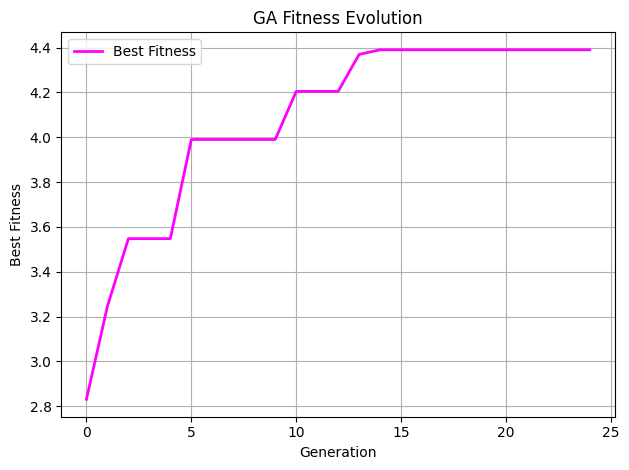

In [ ]:
!pip install pygad sympy scipy numpy

import numpy as np
import sympy as sp
from scipy.optimize import root_scalar, minimize
from scipy.integrate import quad
import pygad
import matplotlib.pyplot as plt

phi = sp.Symbol('phi')

# observables that I am comparing to.
target_ns = 0.965
target_r = 0.266
target_N = 60

def polynomial(coefficients):
    """
    Compute inflationary observables from polynomial potential coefficients.
    Returns: ns, r_val, N_val (in the order expected by fitness function)
    """
    c0, c1, c2, c3, c4 = coefficients

    # Inflationary potential skeleton which takes the form of a polynomial.
    V_phi_expr = c0 + c1*phi + c2*phi**2 + c3*phi**3 + c4*phi**4
    V_first = sp.diff(V_phi_expr, phi) # computing derivatives.
    V_second = sp.diff(V_first, phi)

    # converting to numerical functions.
    V = sp.lambdify(phi, V_phi_expr, 'numpy')
    V_1 = sp.lambdify(phi, V_first, 'numpy')
    V_2 = sp.lambdify(phi, V_second, 'numpy')



    # computing slow-roll parameters
    def epsilon(phi_val):
        """First slow-roll parameter"""
        try:
            v = V(phi_val)
            v1 = V_1(phi_val)

            # checking if it is a not valid input.
            if v <= 0 or np.isnan(v) or np.isnan(v1):
                return 1e6
            if np.abs(v1) < 1e-15:  # avoiding division by 0.
                return 1e6

            eps = 0.5 * (v1 / v)**2
            return min(eps, 1000.0)

        except Exception:
            return 1e6

    def eta(phi_val):
        """Second slow-roll parameter"""
        try:
            v = V(phi_val)
            v2 = V_2(phi_val)

            # checking if it is a not valid input.
            if v <= 0 or np.isnan(v) or np.isnan(v2):
                return 1e6

            eta_val = v2 / v
            return max(min(eta_val, 1000.0), -1000.0)

        except Exception:
            return 1e6

    # finding the scalar field value range.
    phi_start = 20.0  # starting at a higher value to widen the range at which inflation can take place.
    phi_end = 1.0     # guessing the end point since it cannot be 0. ***will keep decreasing to check what could be a great global minimum.

    # check if the evaluation can take place at these points distinctively.
    eps_start = epsilon(phi_start)
    eps_end = epsilon(phi_end)

    if eps_start >= 1e6 or eps_end >= 1e6:
        return None, None, None

    # calculating the number of e-folds through integration.
    try:
        def integrand(p):
            v = V(p)
            v1 = V_1(p)
            if np.abs(v1) < 1e-15 or v <= 0:
                return 0
            return v / v1

        # applying error handling to the integrand computed.
        try:
            N_val, _ = quad(integrand, phi_end, phi_start, limit=100)
        except:
            # fallback: using trapezoidal integration.
            phi_points = np.linspace(phi_end, phi_start, 200) # random staggering (can be changed).
            integrand_vals = [integrand(p) for p in phi_points]
            N_val = np.trapz(integrand_vals, phi_points)

        # calculating observables at horizon exit.
        eps_star = epsilon(phi_start)
        eta_star = eta(phi_start)

        if eps_star >= 1e6 or eta_star >= 1e6:
            return None, None, None

        ns = 1 - 6*eps_star + 2*eta_star
        r_val = 16*eps_star

        return ns, r_val, N_val

    except Exception:
        return None, None, None

def fitness_func(ga, solution, idx):
    """
    fitness function.
    """

    # bounds applied to the coefficients.
    if np.any(np.abs(solution) > 2.0):
        return 1e-10

    # evaluating the model.
    result = polynomial(solution)

    if result[0] is None:
        return 1e-10

    ns, r_val, N_val = result

    # more physical constraints.
    if not (50 <= N_val <= 60):
        return 1e-10
    if not (0.6 <= ns <= 1):
        return 1e-10
    if r_val < 0 or r_val > 0.6:
        return 1e-10

    # weighted error calculation (prioritizing getting closer to targets).
    ns_error = abs(ns - target_ns) / 0.1  # scaling by typical uncertainty.
    r_error = abs(r_val - target_r) / 0.1
    N_error = abs(N_val - target_N) / 20.0  # scaling N errors differently since it is in a different range.

    # penalizing extreme values more heavily ---> hence why the absolute value was found.
    if abs(ns - target_ns) > 0.5:
        ns_error *= 10
    if abs(r_val - target_r) > 0.5:
        r_error *= 10
    if abs(N_val - target_N) > 40:
        N_error *= 10

    # regularization.
    regularization = 1e-5 * np.sum(np.square(solution))

    total_error = ns_error + r_error + N_error + regularization

    fitness = 1.0 / (total_error + 1e-8)

    # enchance logging for good solutions
    if fitness > 1.0:
        print(f"Promising solution: ns={ns:.3f}, r={r_val:.3f}, N={N_val:.1f}, fitness={fitness:.2f}")

    return fitness

# set up genetic algorithm with better parameters
num_genes = 5 # number of genes.
ga = pygad.GA(
    num_generations=500, # max. number of generations GA will run for.
    sol_per_pop=1000, # number of chromosomes in each population.
    num_parents_mating=40, # number of parents which are selected in each generation to mate.
    num_genes=num_genes,
    fitness_func=fitness_func,
    init_range_low=-1.0, # initial value for the genes starts wihtin this rnage (completely random).
    init_range_high=1.0,
    mutation_percent_genes=52.1, # 20% of the genes in each offspring will be mutated.
    mutation_by_replacement=True,
    random_mutation_min_val=-1.0,
    random_mutation_max_val=1.0,
    crossover_type="single_point",
    mutation_type="random",
    parent_selection_type="tournament",
    K_tournament=3,
    keep_parents=5, # after mating, keeping only 5 parents.
    save_best_solutions=True,
    stop_criteria=["saturate_10"]  # stop if no improvement for 10 generations
)

# running the genetic algorithm.
ga.run()

# printing the best solution.
solution, fitness, idx = ga.best_solution()
print(f"\nBest Coefficients: {solution}")
print(f"Fitness Score: {fitness:.2f}")

# evaluating the best solution with error testing.
result = polynomial(solution)
if result[0] is not None:
    ns_best, r_best, N_best = result
    print(f"\nFinal Results:")
    print(f"n_s: {ns_best:.4f} (target: {target_ns})")
    print(f"r: {r_best:.4f} (target: {target_r})")
    print(f"N: {N_best:.1f} (target: {target_N})")

    print(f"\nErrors:")
    print(f"Δn_s: {abs(ns_best - target_ns):.4f}")
    print(f"Δr: {abs(r_best - target_r):.4f}")
    print(f"ΔN: {abs(N_best - target_N):.1f}")

    # checking if this is a good solution.
    if (abs(ns_best - target_ns) < 0.1 and
        abs(r_best - target_r) < 0.1 and
        abs(N_best - target_N) < 10):
        print("YASSSSS")
    else:
        print("sad face X0X0")
        print("   - Running for more generations")
        print("   - Trying different target values")
        print("   - Using a different potential form")
else:
    print("\nERROR: Best solution failed to evaluate!")
    print("The optimization may need different constraints or initialization.")

# plotting fitness evolution.
fitness_values = ga.best_solutions_fitness

plt.plot(fitness_values, color='magenta', linewidth=2, label='Best Fitness')
plt.title("GA Fitness Evolution")
plt.xlabel("Generation")
plt.ylabel("Best Fitness")
plt.legend()
plt.grid(True)
plt.tight_layout()




** (for 20% mutation rate) The graph above displays how the best fitness evolves with the genetic algortihm which was computed. The best fitness starts at about 3.4 and then increases up until 4.6 where a plateou is reached. This steady increase suggests great model optimization. At about the 17th generation, the fitness stops evolving, which could be improved.
 **try increasing mutation rate* bold text**

 *tried increasing mutation rate and fitness evolution is smoother.

In [ ]:
!pip install pysr

from pysr import PySRRegressor


phi_values = np.linspace(1, 20, 100)
V_values = solution[0] + solution[1]*phi_values + solution[2]*phi_values**2 +solution[3]*phi_values**3 + solution[4]*phi_values**4


model = PySRRegressor(
    niterations=500,
    binary_operators=["+", "*", "-", "/"],
    unary_operators=["exp", "log", "sin", "cos"],
    loss="loss(x, y) = (x - y)^2"
)

model.fit(phi_values.reshape(-1, 1), V_values)

best_inflationary_potential = model.get_best()["sympy_format"]
print("Best inflationary potential:")
print(best_inflationary_potential)

Detected IPython. Loading juliacall extension. See https://juliapy.github.io/PythonCall.jl/stable/compat/#IPython


/usr/local/lib/python3.11/dist-packages/pysr/sr.py:1036: FutureWarning: `loss` has been renamed to `elementwise_loss` in PySRRegressor. Please use that instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2811: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
Compiling Julia backend...
INFO:pysr.sr:Compiling Julia backend...
[ Info: Started!



Expressions evaluated per second: 7.190e+04
Progress: 296 / 15500 total iterations (1.910%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           4.602e+06  0.000e+00  y = 1804.3
3           1.632e+06  3.673e-01  y = x₀ * 210.16
4           1.014e+06  3.801e-01  y = exp(x₀ * 0.46201)
5           1.576e+05  1.766e+00  y = x₀ * (x₀ * x₀)
6           2.882e+04  1.688e+00  y = exp((x₀ * 0.22079) - -4.5777)
7           1.186e+04  8.853e-01  y = ((x₀ * x₀) - 32.156) * x₀
9           4.300e+03  5.067e-01  y = x₀ * (x₀ * ((x₀ * 1.2479) + -6.1502))
11          1.050e+03  7.046e-01  y = x₀ * ((((x₀ * 1.4986) + -13.347) * x₀) + 48.206)
13          1.045e+03  2.321e-03  y = (x₀ * ((((x₀ * 1.4986) + -13.347) * x₀) + 48.206)) - 0...
                                      .61772
14          1.037e+03  

[ Info: Final population:
[ Info: Results saved to:


Best inflationary potential:
0.67267805 - x0*(x0 - (1.484044 - x0)/x0)*(x0*(x0*(-0.032883175) - 0.22557342) - 1*0.7340003)
  - outputs/20250716_105458_xrbZBN/hall_of_fame.csv
